In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib import rc
from drawing_statistics_functions import box_plot, bar_plot, bar_plot_inverse, scatter_plot
from base_functions import linear_regression
from scipy import stats

font = {'family': 'DejaVu Sans',
        'size': 16}
rc('font', **font)

In [2]:
folder_name = '/platooned_data/03-12-2020' 
file = open(os.getcwd() + folder_name + '/oscillation_info', 'rb')
oscillation_info = pickle.load(file)
file.close()

#OSCILLATION INFO
#0 HV
#1 ACC1
#2 ACC2
#3 SCENARIO
#4 HV_BEFORE_OSCILLATION_SPEED
#5 ACC1_BEFORE_OSCILLATION_SPEED
#6 SPACING(HV-ACC1)_BEFORE_OSCILLATION_SPEED

#Detailed oscillation info
#0: minimum speed time stamp
#1: minimum speed
#2 deceleration start
#3 deceleration start speed
#4 acceleration end
#5 acceleration end speed
#6 deceleration end
#7 deceleration end speed
#8 acceleration begin
#9 acceleration begin speed
#10 minimum deceleration rate
#11 maximum acceleration rate
#12 deceleration duration
#13 avg decleration rate
#14 accelereation duration
#15 avg deceleration rate
#16 idle duration

#SCENARIO
#0 headway
#1 engine mode
#2 magnitude
#3 brake pattern
#4 cruise
#5 oscillation_ID
#6 speed level

#Features
oscillation_features = []
comprehensive_oscillation_features_with_delay = []
for osc in oscillation_info:
    #evaluate the spacing before oscillation, exclude the ones with noisy spacing
    TH1 = 10 #sec before the stablization
    HV_speed = osc[4]
    ACC1_speed = osc[5]
    speed_diff = [HV_speed[i] - ACC1_speed[i] for i in range(len(HV_speed))]
    spacing_from_speed = [sum(speed_diff[:i+1]) * 0.44704 / 10 for i in range(len(speed_diff))]
    spacing_from_speed = [l - spacing_from_speed[-1] for l in spacing_from_speed]
    spacing_from_speed = [l - spacing_from_speed[-1] for l in spacing_from_speed[- TH1 * 10:]]
    spacing = osc[6]
    spacing = [l - spacing[-1] for l in spacing[- TH1 * 10:]]
    TH2 = 2
    if max([abs(s) for s in spacing]) > TH2 and max([abs(s) for s in spacing_from_speed]) > TH2:
#     if max([abs(s) for s in spacing]) > TH2:
        print('excluded:', osc[3])
#         plt.figure()
#         plt.subplot(211)
#         plt.plot(spacing)
#         plt.subplot(212)
#         plt.plot(spacing_from_speed)
#         plt.xlabel(str(osc[3][5]))
        continue

    #basic information
    vehs = [osc[i] for i in range(3)]
    scenario = osc[3]
    oscillation_ID = scenario[5]
    spacing_before_deceleartion = osc[6]
    spacing = osc[7]
    
    #Influential factor
    speed_level = scenario[6]
    cruise = scenario[4]
    headway = scenario[0]
    magnitude = scenario[2]
    
    #oscillation growth
    minimum_speed = [veh[1] for veh in vehs]
    deceleration_end_time_veh1 = vehs[0][6]
    amp1 = minimum_speed[1] - minimum_speed[0]
    amp2 = minimum_speed[2] - minimum_speed[0]
    if amp1 < 0 and amp2 < amp1:
        oscillation_pattern = 'amp - amp'
    elif amp1 < 0 and amp2 >= amp1:
        oscillation_pattern = 'amp - damp'
    elif amp1 >= 0 and amp2 < amp1:
        oscillation_pattern = 'damp - amp'
    else:
        oscillation_pattern = 'damp - damp'
    
    #delay
    delay_lower_bound = -100
    d_start = [veh[2] for veh in vehs]
    d_start_delay1 = round(max(d_start[1] - d_start[0], delay_lower_bound), 1)
    d_start_delay2 = round(max(d_start[2] - d_start[1], delay_lower_bound), 1)
    d_end = [veh[6] for veh in vehs]
    d_end_delay1 = round(max(d_end[1] - d_end[0], delay_lower_bound), 1)
    d_end_delay2 = round(max(d_end[2] - d_end[1], delay_lower_bound), 1)
    a_start = [veh[8] for veh in vehs]
    a_start_delay1 = round(max(a_start[1] - a_start[0], delay_lower_bound), 1)
    a_start_delay2 = round(max(a_start[2] - a_start[1], delay_lower_bound), 1)
    a_end = [veh[4] for veh in vehs]
    a_end_delay1 = round(max(a_end[1] - a_end[0], delay_lower_bound), 1)
    a_end_delay2 = round(max(a_end[2] - a_end[1], delay_lower_bound), 1)
    delay = ([d_start_delay1, d_end_delay1, a_start_delay1, a_end_delay1], [d_start_delay2, d_end_delay2, a_start_delay2, a_end_delay2])
    delay_of_first_pair = delay[0]
    
    #acceleration and deceleartion
    d_avg = [veh[13] for veh in vehs]
    d_min = [veh[10] for veh in vehs]
    a_avg = [veh[15] for veh in vehs]
    a_max = [veh[11] for veh in vehs]
    rate_info = (d_avg, d_min, a_avg, a_max)
    
    #classify the brake pattern by deceleration rate
    if rate_info[1][0] >= 1.2:
        brake_pattern_threshold = 'strong'
    else:
        brake_pattern_threshold = 'mild'
        
    oscillation_features.append([amp1, amp2, oscillation_ID, speed_level, 
                                 oscillation_pattern, delay, rate_info, cruise, 
                                 headway, magnitude, brake_pattern_threshold])

    #comprehensive oscillation features with delay
    comprehensive_oscillation_features_with_delay.append([amp1, amp2, oscillation_ID, speed_level, 
                                 oscillation_pattern, delay, rate_info, cruise, 
                                 headway, magnitude, brake_pattern_threshold]
                                                         + delay_of_first_pair
                                                         + [spacing_before_deceleartion, spacing, 
                                                            deceleration_end_time_veh1]) 

    

excluded: ['1', 'Normal', 'mild', 'mild', 'no', 70, 'low']
excluded: ['1', 'Normal', 'strong', 'strong', 'long', 75, 'low']
excluded: ['3', 'Normal', 'mild', 'strong', 'no', 82, 'low']


mid -0.55 low -0.48 p-value 0.6357537971619195
high 0.09 mid -0.55 p-value 2.3992563802656065e-06


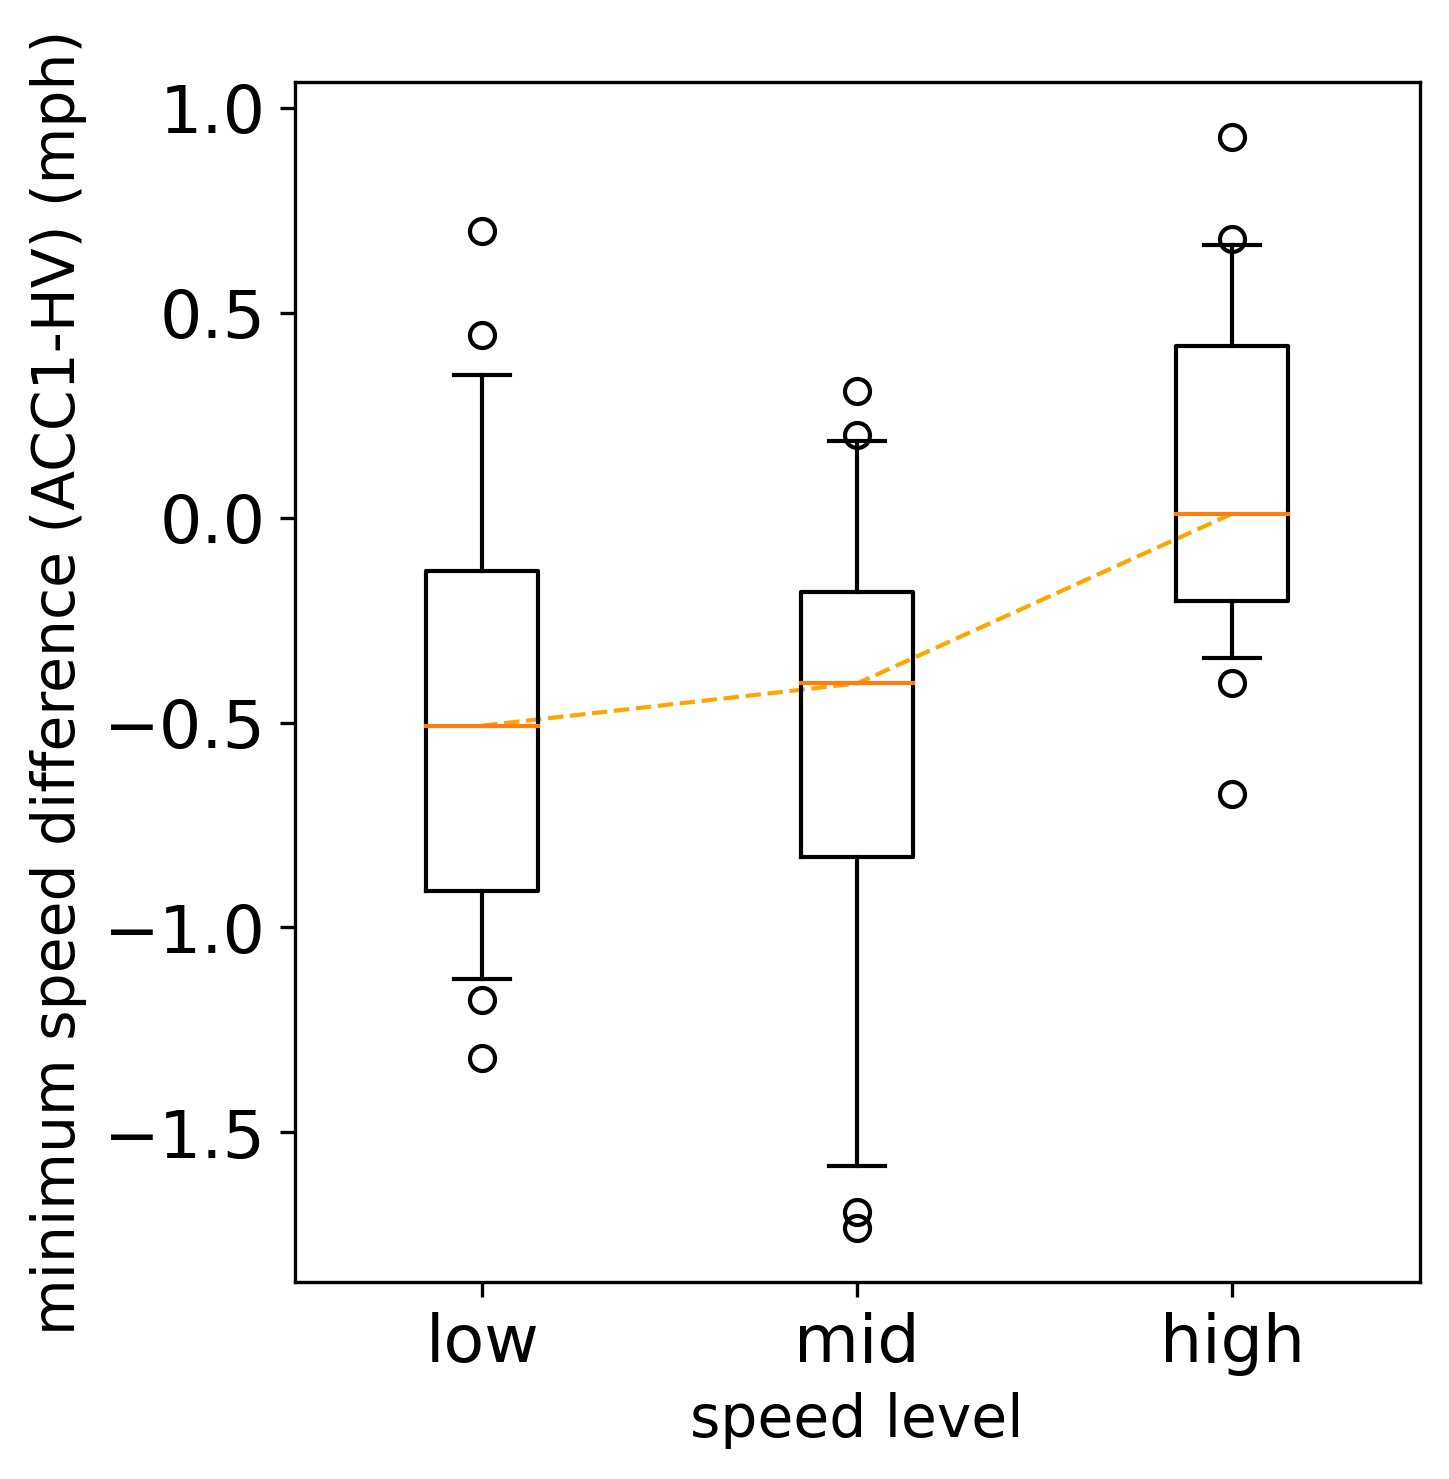

In [3]:
#1.1 oscillation growth - speed level
label_column = 3
y_column = 0
group_label = ['low', 'mid', 'high']
x_label = 'speed level'
y_label = 'minimum speed difference (ACC1-HV) (mph)'
mean_value_info = box_plot(oscillation_features, label_column, y_column, group_label, x_label, y_label)  

mid -0.82 low -0.71 p-value 0.5853490983295341
high -0.16 mid -0.82 p-value 0.0004227852660237437


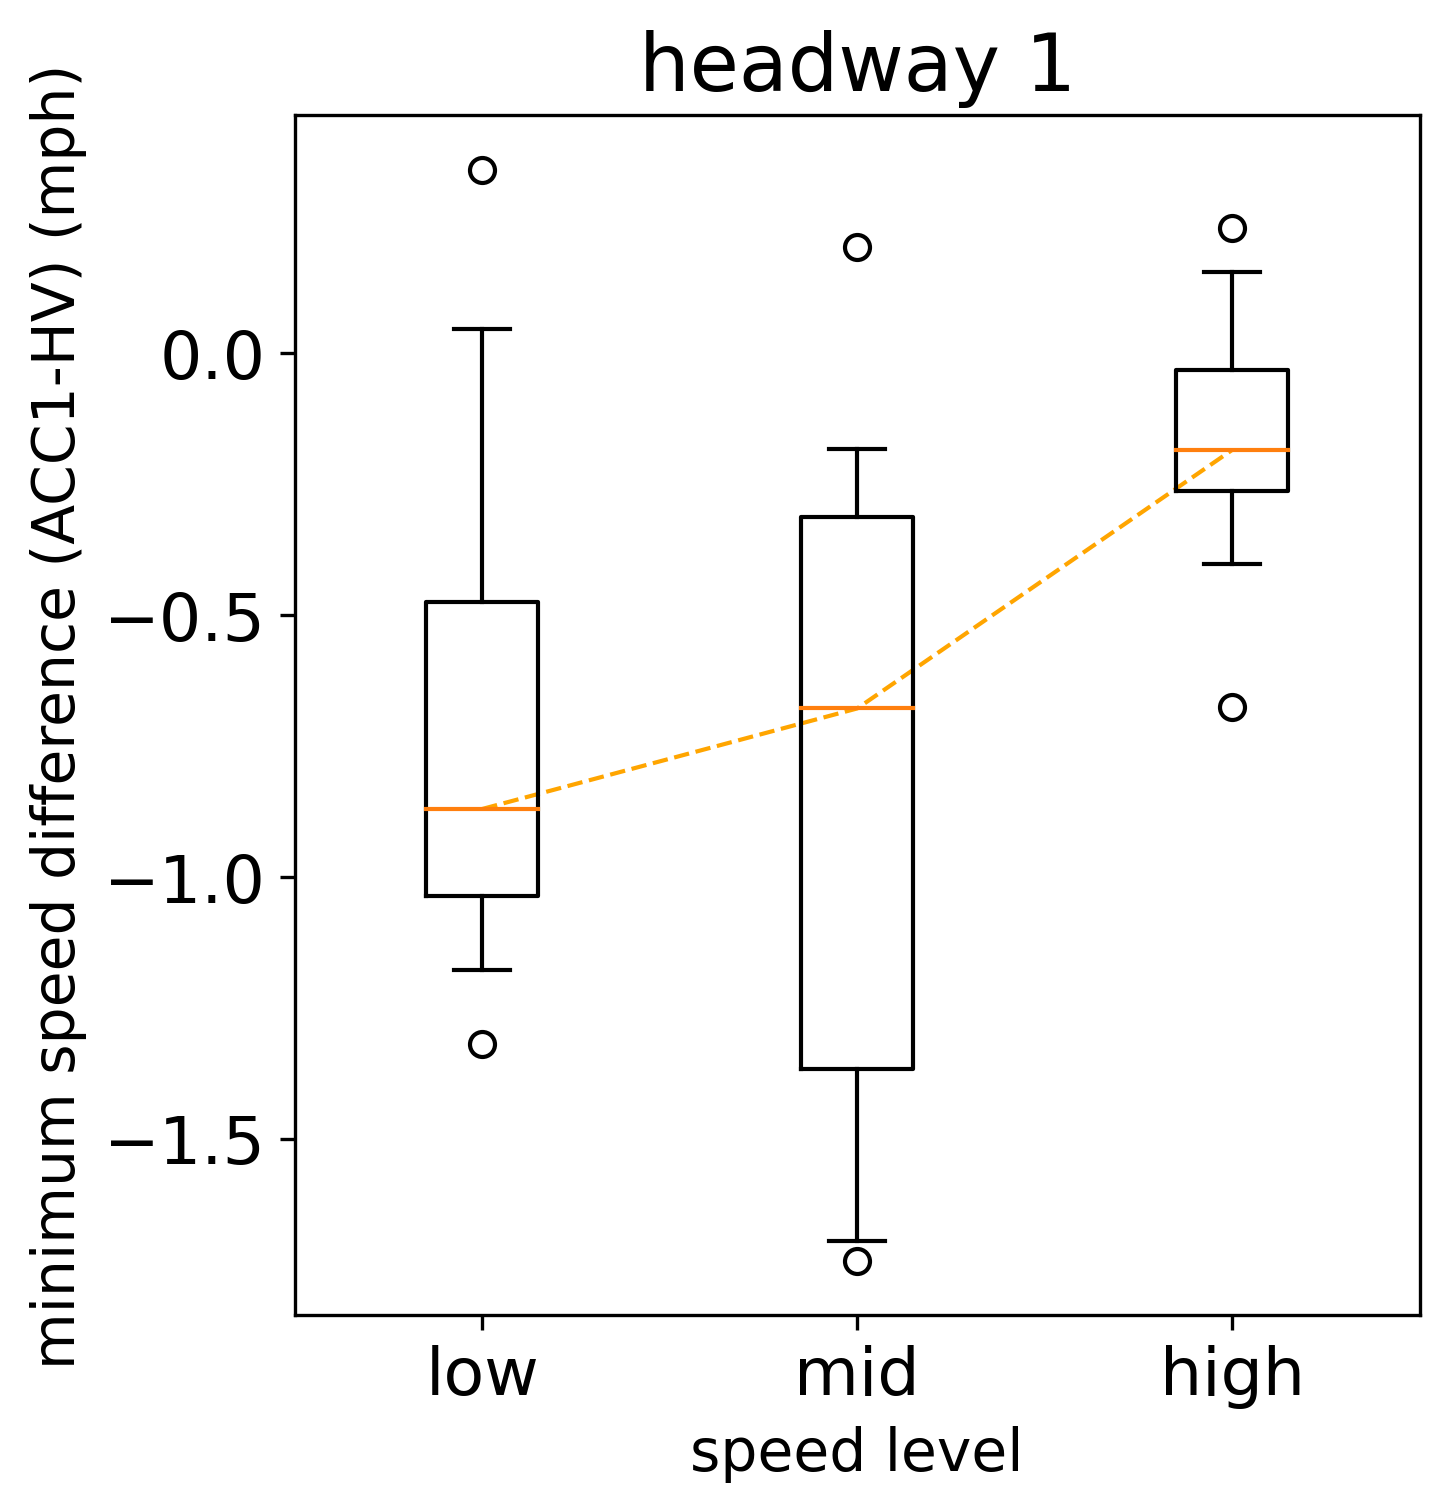

In [4]:
#1.1 oscillation growth - speed level - headway 1
oscillation_features_headway_1 = [o for o in oscillation_features if o[8] == '1']

label_column = 3
y_column = 0
group_label = ['low', 'mid', 'high']
x_label = 'speed level'
y_label = 'minimum speed difference (ACC1-HV) (mph)'
mean_value_info = box_plot(oscillation_features_headway_1, label_column, y_column, group_label, x_label, y_label, title='headway 1')  

mid -0.28 low -0.25 p-value 0.8767614724806871
high 0.33 mid -0.28 p-value 3.5611914917792855e-05


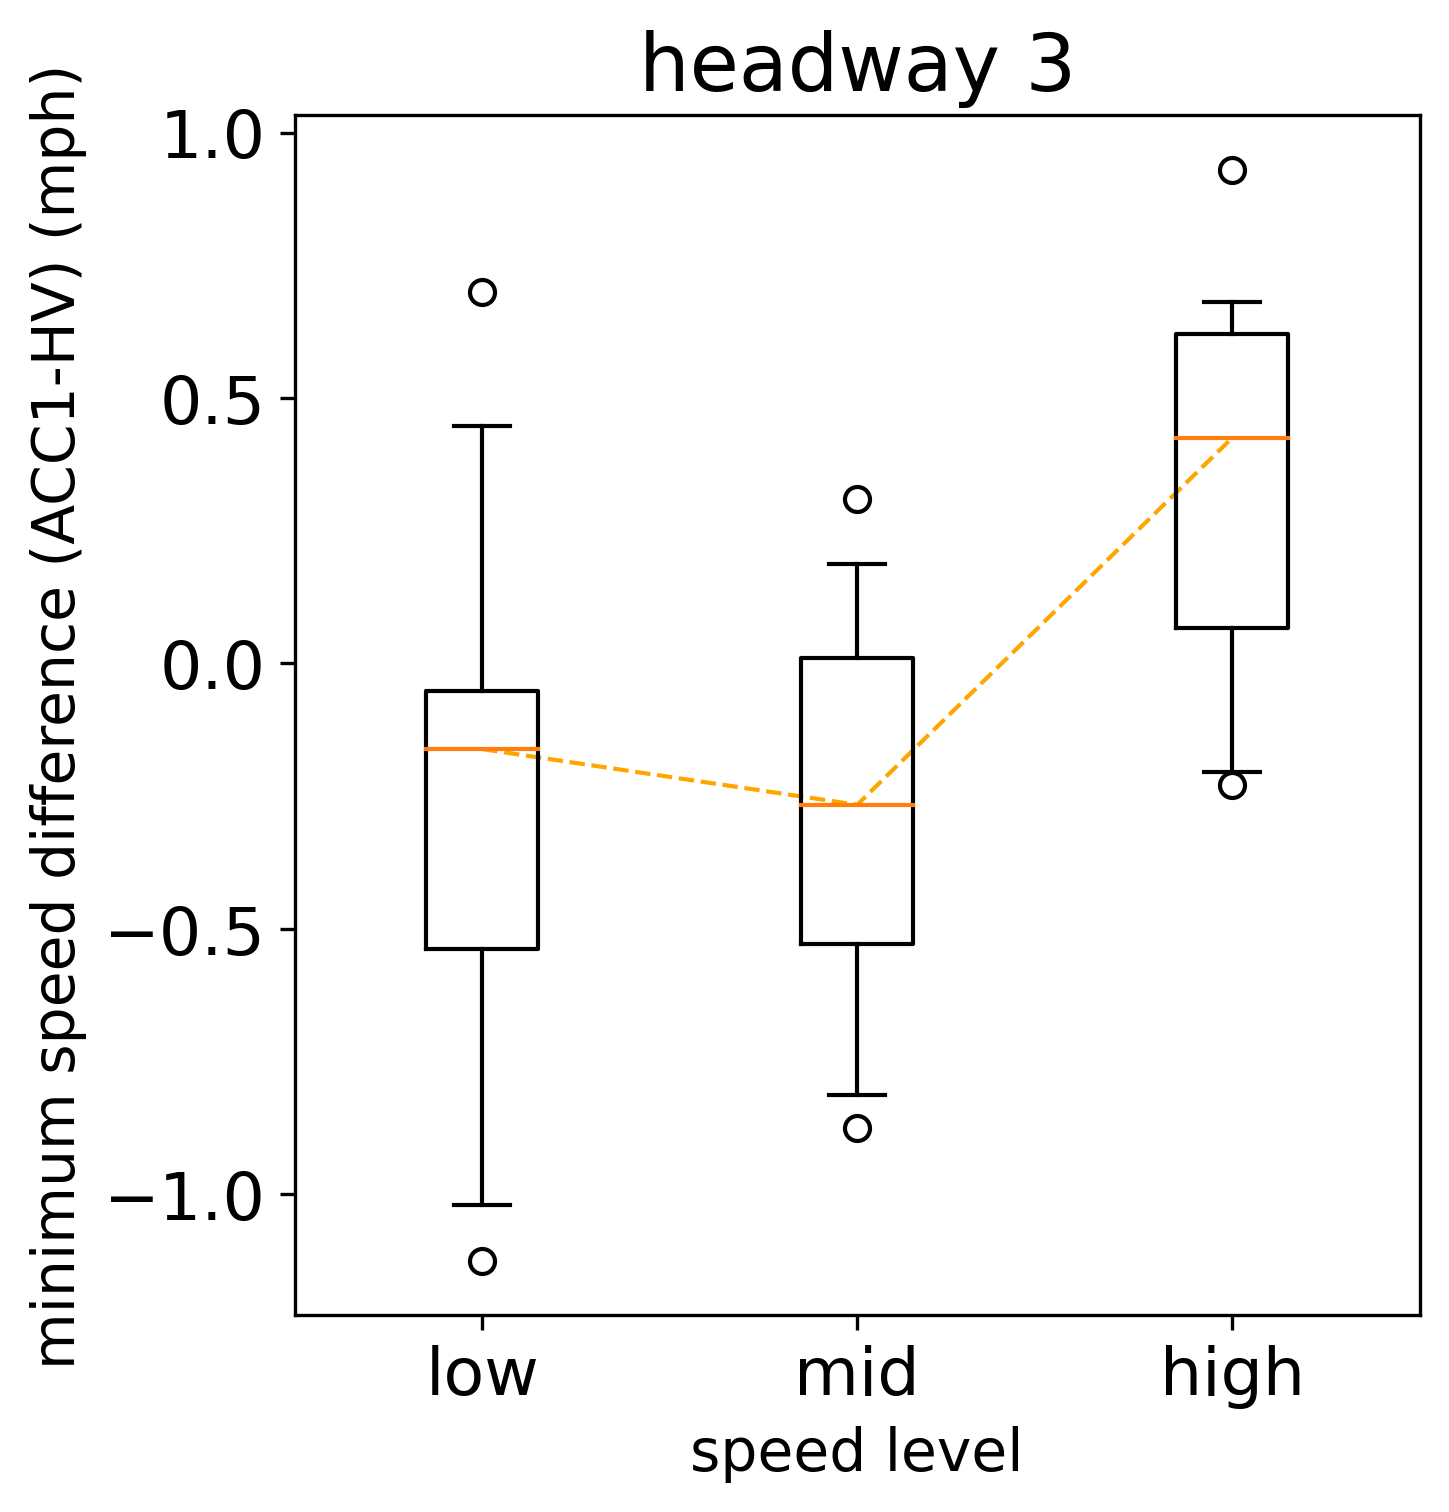

In [5]:
#1.1 oscillation growth - speed level - headway 3
oscillation_features_headway_3 = [o for o in oscillation_features if o[8] == '3']

label_column = 3
y_column = 0
group_label = ['low', 'mid', 'high']
x_label = 'speed level'
y_label = 'minimum speed difference (ACC1-HV) (mph)'
mean_value_info = box_plot(oscillation_features_headway_3, label_column, y_column, group_label, x_label, y_label, title='headway 3')  

long -0.32 no -0.3 p-value 0.8684408469047318


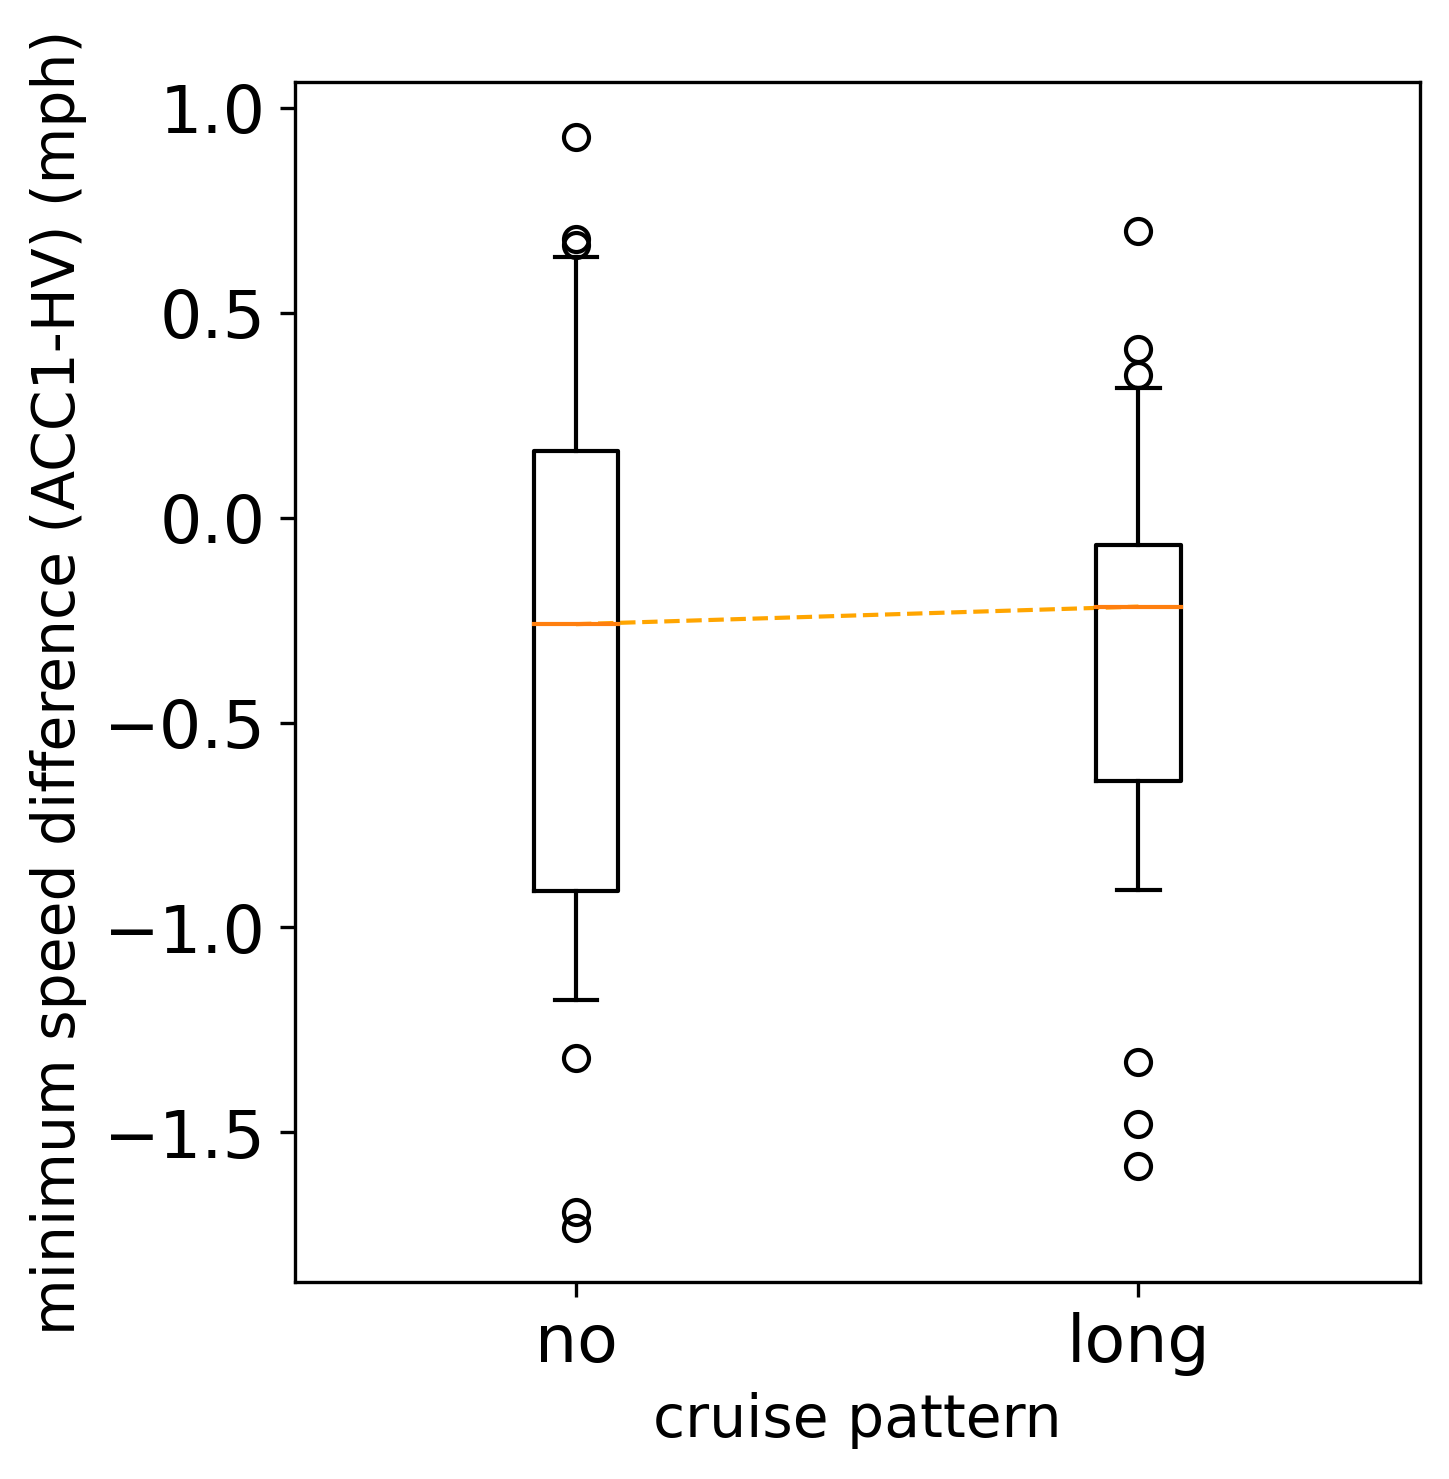

In [6]:
#1.2 oscillation growth - cruise pattern
label_column = 7
y_column = 0
group_label = ['no', 'long']
x_label = 'cruise pattern'
y_label = 'minimum speed difference (ACC1-HV) (mph)'
mean_value_info = box_plot(oscillation_features, label_column, y_column, group_label, x_label, y_label)  

3 -0.06 1 -0.56 p-value 7.12083706949467e-06


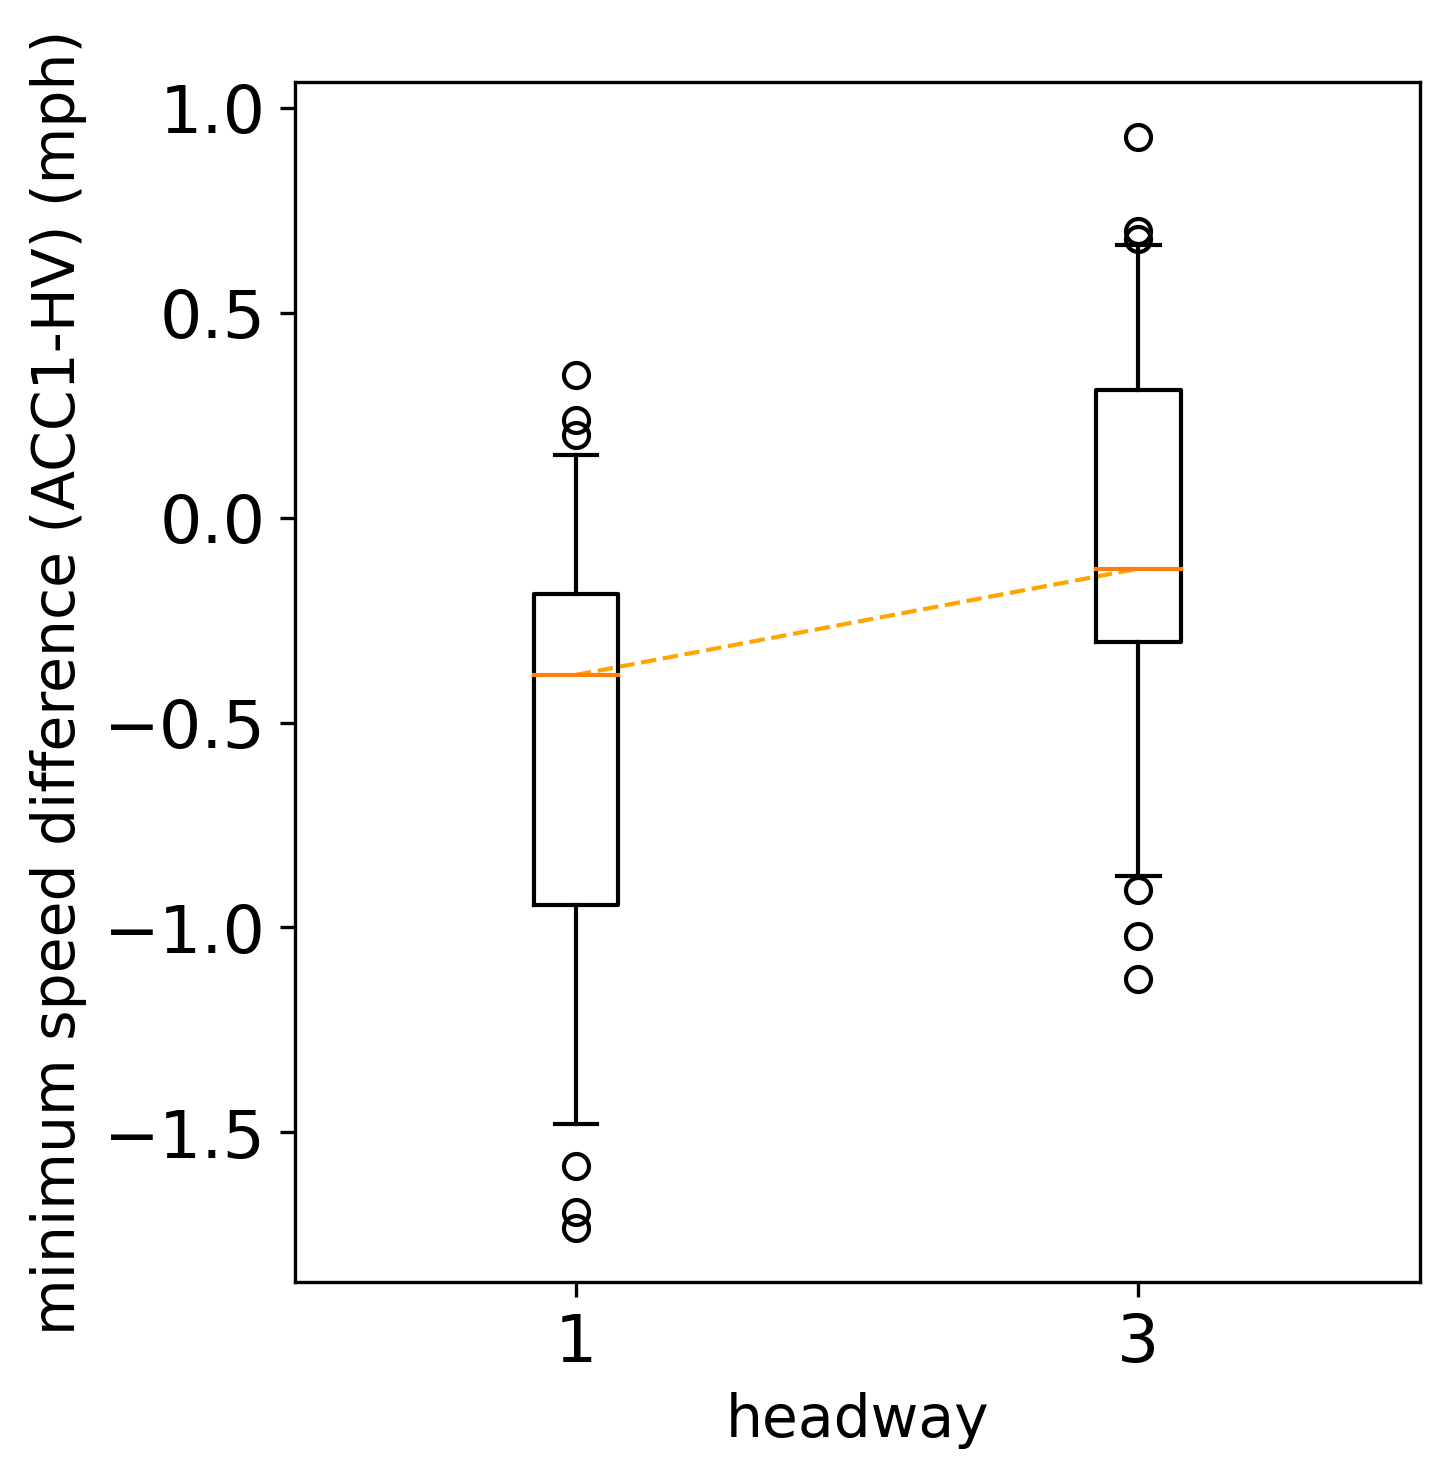

In [7]:
#1.3 oscillation growth - headway
label_column = 8
y_column = 0
group_label = ['1', '3']
x_label = 'headway'
y_label = 'minimum speed difference (ACC1-HV) (mph)'
mean_value_info = box_plot(oscillation_features, label_column, y_column, group_label, x_label, y_label)  

mild -0.13 strong -0.5 p-value 0.0012672704346846568


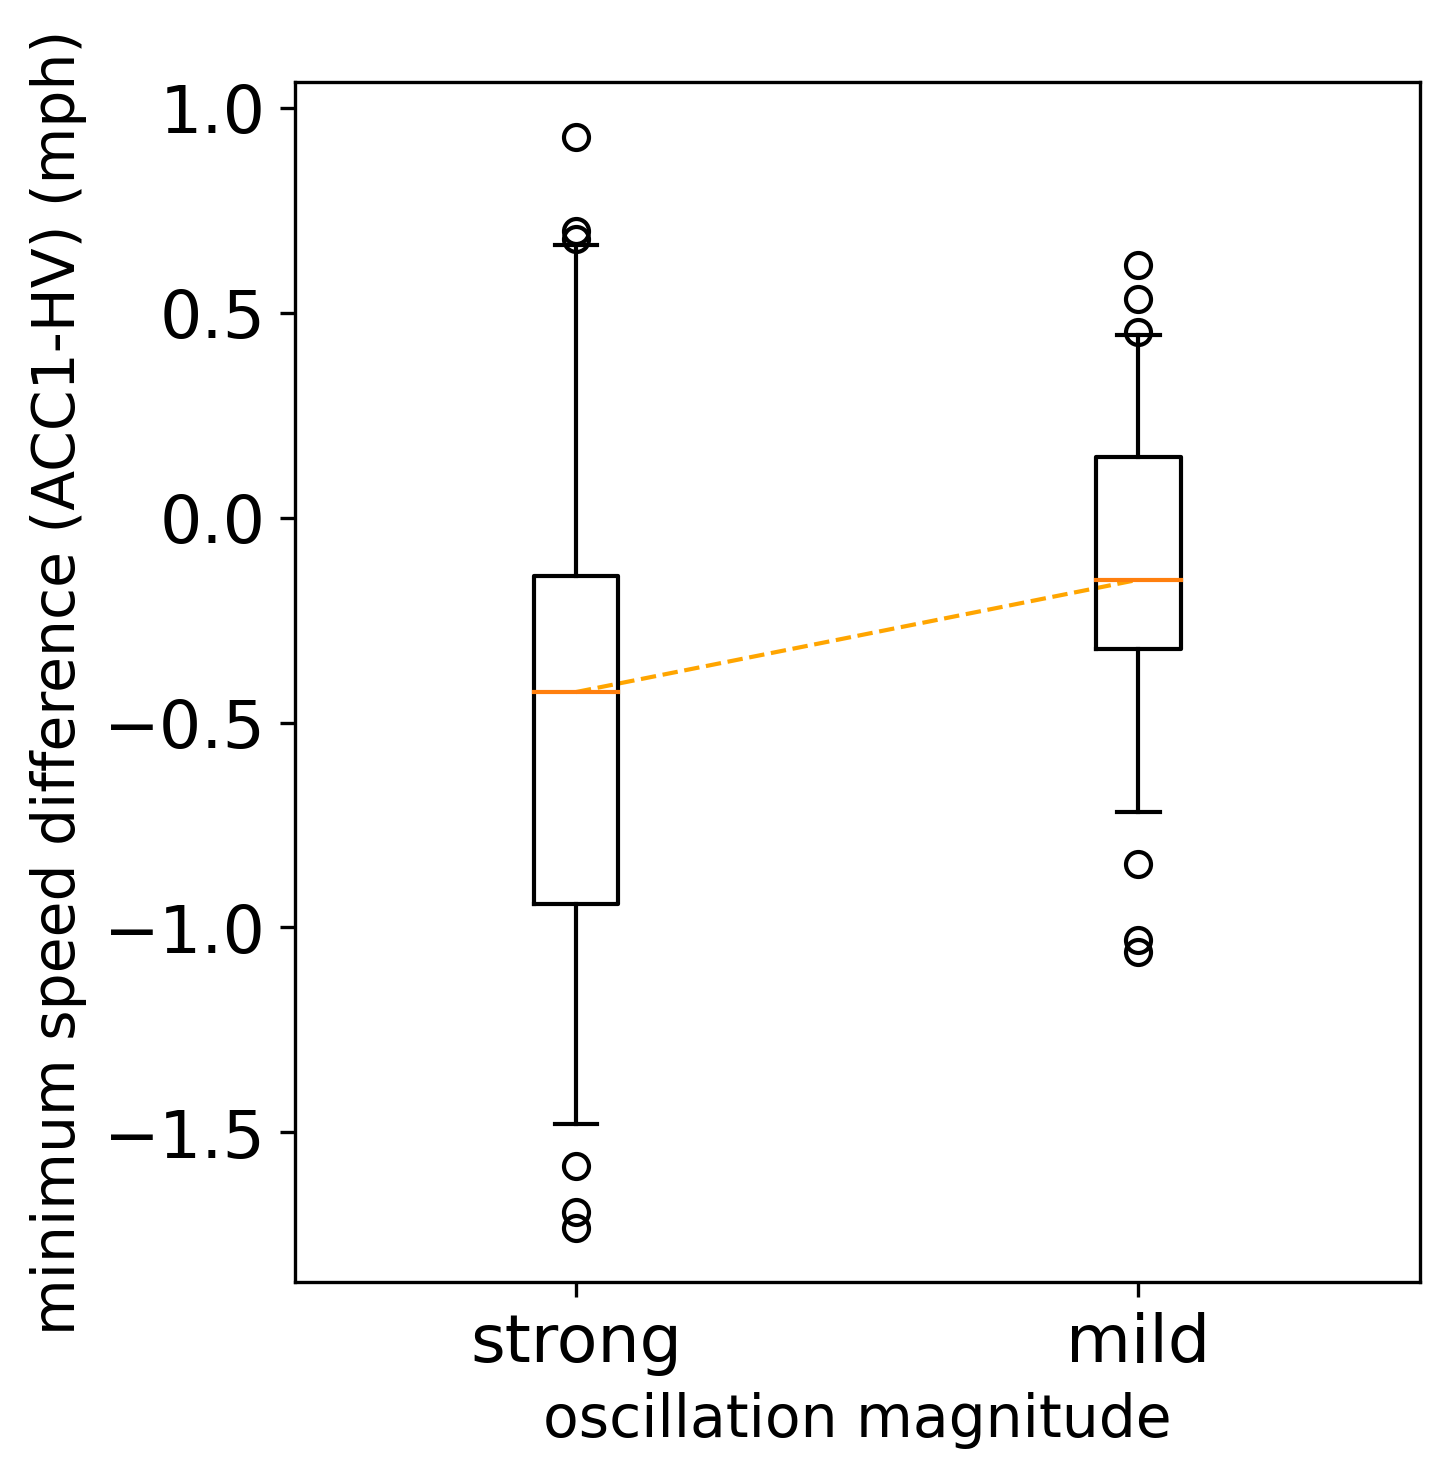

In [8]:
#1.4 oscillation growth - magnitude
label_column = 9
y_column = 0
group_label = ['strong', 'mild']
x_label = 'oscillation magnitude'
y_label = 'minimum speed difference (ACC1-HV) (mph)'
mean_value_info = box_plot(oscillation_features, label_column, y_column, group_label, x_label, y_label)  

mild -0.17 strong -0.67 p-value 4.838927113518826e-05


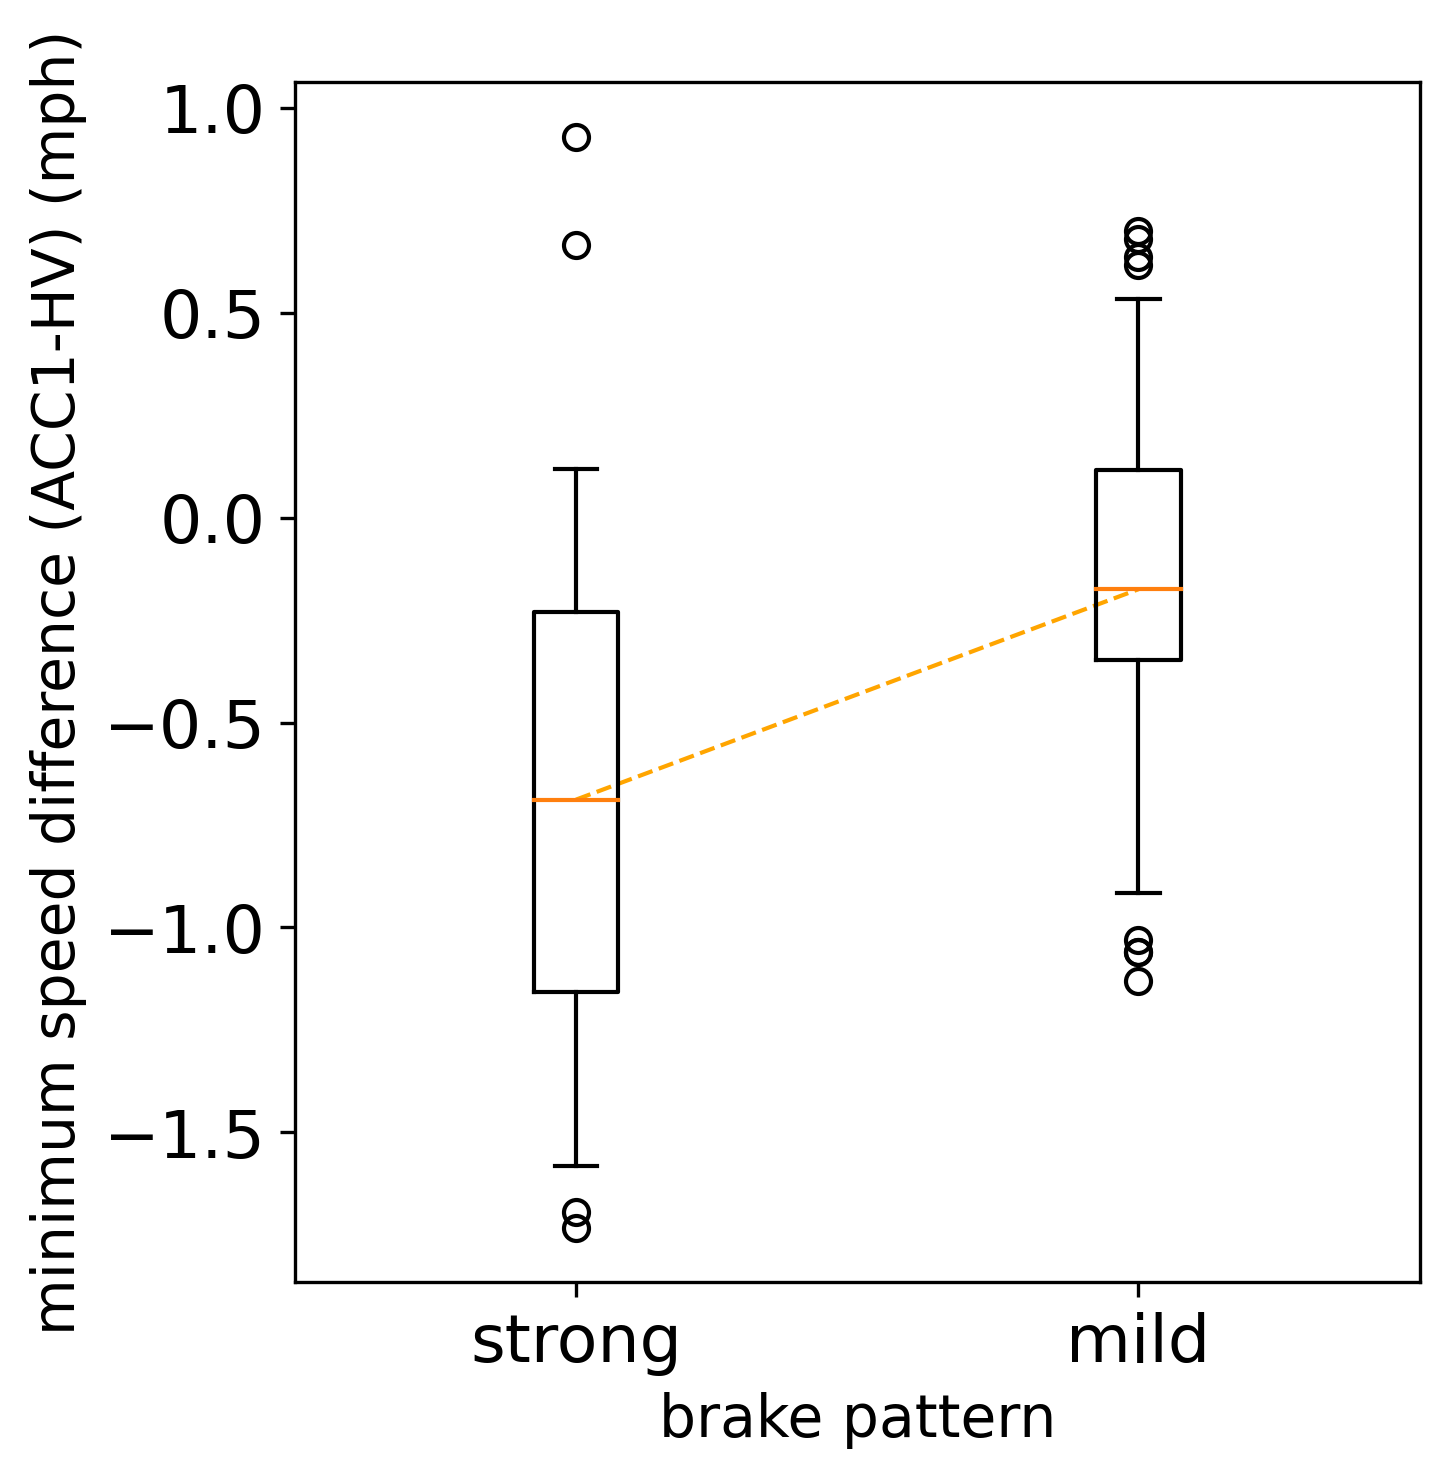

In [9]:
#1.5 oscillation growth - brake pattern
label_column = 10
y_column = 0
group_label = ['strong', 'mild']
x_label = 'brake pattern'
y_label = 'minimum speed difference (ACC1-HV) (mph)'
mean_value_info = box_plot(oscillation_features, label_column, y_column, group_label, x_label, y_label)  

Text(0, 0.5, 'frequency')

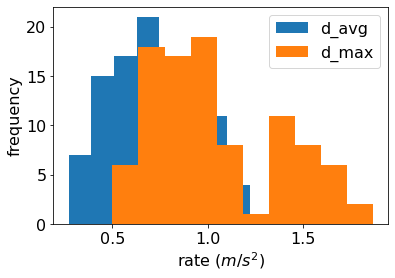

In [17]:
#1.5 - cont.
#d_avg
plt.hist([i[6][0][0] for i in oscillation_features],label='d_avg')
#d_max
plt.hist([i[6][1][0] for i in oscillation_features],label='d_max')
plt.legend()
plt.xlabel('rate ($m$/$s^2$)')
plt.ylabel('frequency')

#use d_max to distinguish strong and mild

Text(0, 0.5, 'frequency')

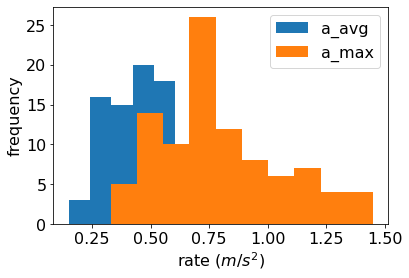

In [18]:
#1.5 - cont.
#a_avg
plt.hist([i[6][2][0] for i in oscillation_features],label='a_avg')
#a_max
plt.hist([i[6][3][0] for i in oscillation_features],label='a_max')
plt.legend()
plt.xlabel('rate ($m$/$s^2$)')
plt.ylabel('frequency')


low Deceleration
end 1.23 Deceleration
start 1.19 p-value 0.765


low Acceleration
start 1.07 Deceleration
end 1.23 p-value 0.099


low Acceleration
end 1.51 Acceleration
start 1.07 p-value 0.547


mid Deceleration
end 1.62 Deceleration
start 1.41 p-value 0.002


mid Acceleration
start 1.55 Deceleration
end 1.62 p-value 0.278


mid Acceleration
end 1.89 Acceleration
start 1.55 p-value 0.209


high Deceleration
end 1.82 Deceleration
start 1.79 p-value 0.77


high Acceleration
start 1.84 Deceleration
end 1.82 p-value 0.846


high Acceleration
end 3.32 Acceleration
start 1.84 p-value 0.001


Deceleration
start mid 1.41 low 1.19 p-value 0.072


Deceleration
end mid 1.62 low 1.23 p-value 0.0


Acceleration
start mid 1.55 low 1.07 p-value 0.0


Acceleration
end mid 1.89 low 1.51 p-value 0.608


Deceleration
start high 1.79 mid 1.41 p-value 0.0


Deceleration
start high 1.79 low 1.19 p-value 0.0


Deceleration
end high 1.82 mid 1.62 p-value 0.015


Deceleration
end high 1.82 low 1.23 p-value 

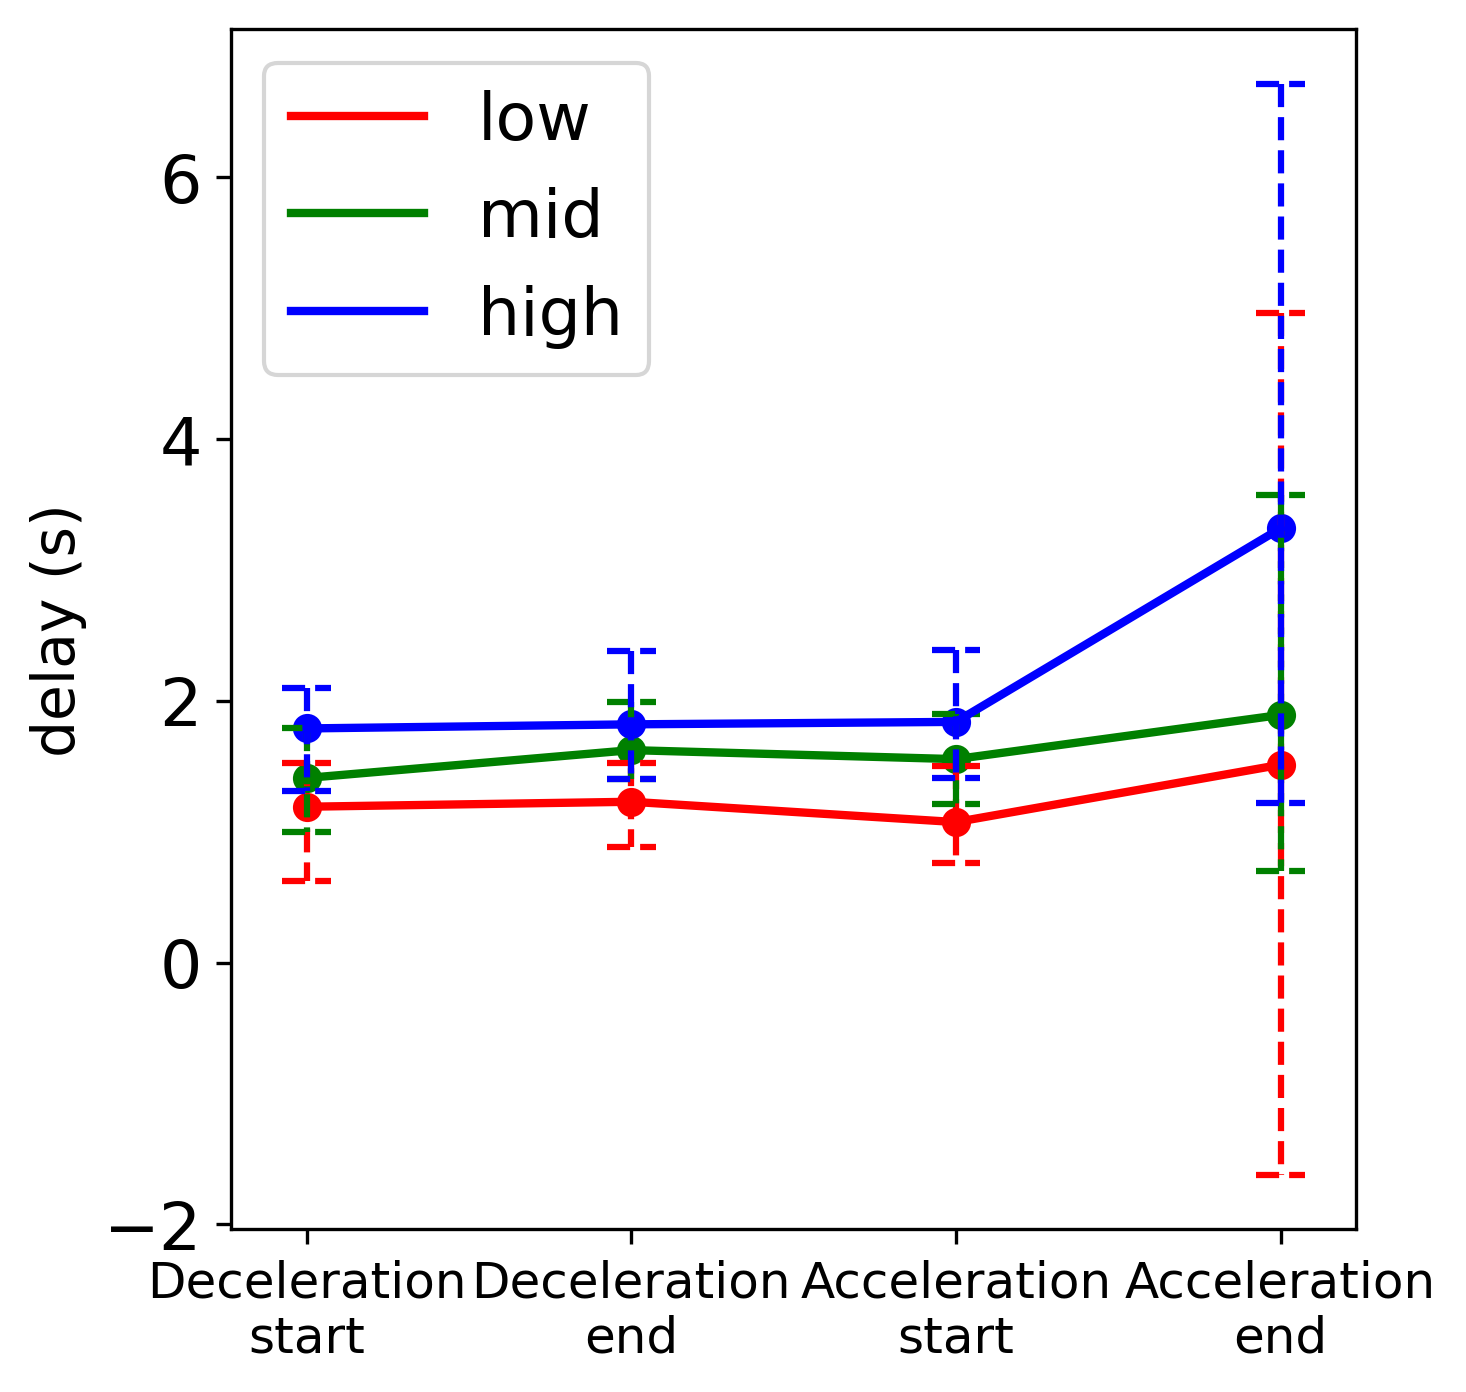

In [4]:
#2.1 delay - speed level
oscillation_features_copy = oscillation_features.copy()
for i in range(len(oscillation_features_copy)):
    oscillation_features_copy[i] = oscillation_features_copy[i] + oscillation_features_copy[i][5][0]

impact_factor_column = 3
impact_factor_group_label = ['low', 'mid', 'high']
feature_column_group = [11, 12, 13, 14]
feature_column_group_label = ['Deceleration\nstart', 'Deceleration\nend', 'Acceleration\nstart', 'Acceleration\nend']
x_label = ''
y_label = 'delay (s)'

bar_plot(oscillation_features_copy, impact_factor_column, feature_column_group,impact_factor_group_label, feature_column_group_label, 
         x_label, y_label, bar=True)



no Deceleration
end 1.49 Deceleration
start 1.45 p-value 0.7173117188972125


no Acceleration
start 1.66 Deceleration
end 1.49 p-value 0.023847054678044762


no Acceleration
end 2.51 Acceleration
start 1.66 p-value 0.02490712434804711


long Deceleration
end 1.64 Deceleration
start 1.49 p-value 0.12574534468201495


long Acceleration
start 1.35 Deceleration
end 1.64 p-value 0.0031166855569626202


long Acceleration
end 2.02 Acceleration
start 1.35 p-value 0.13328983360028035


Deceleration
start long 1.49 no 1.45 p-value 0.7638911691035583


Deceleration
end long 1.64 no 1.49 p-value 0.05500670439188098


Acceleration
start long 1.35 no 1.66 p-value 0.0011833431155605866


Acceleration
end long 2.02 no 2.51 p-value 0.4026115462522267




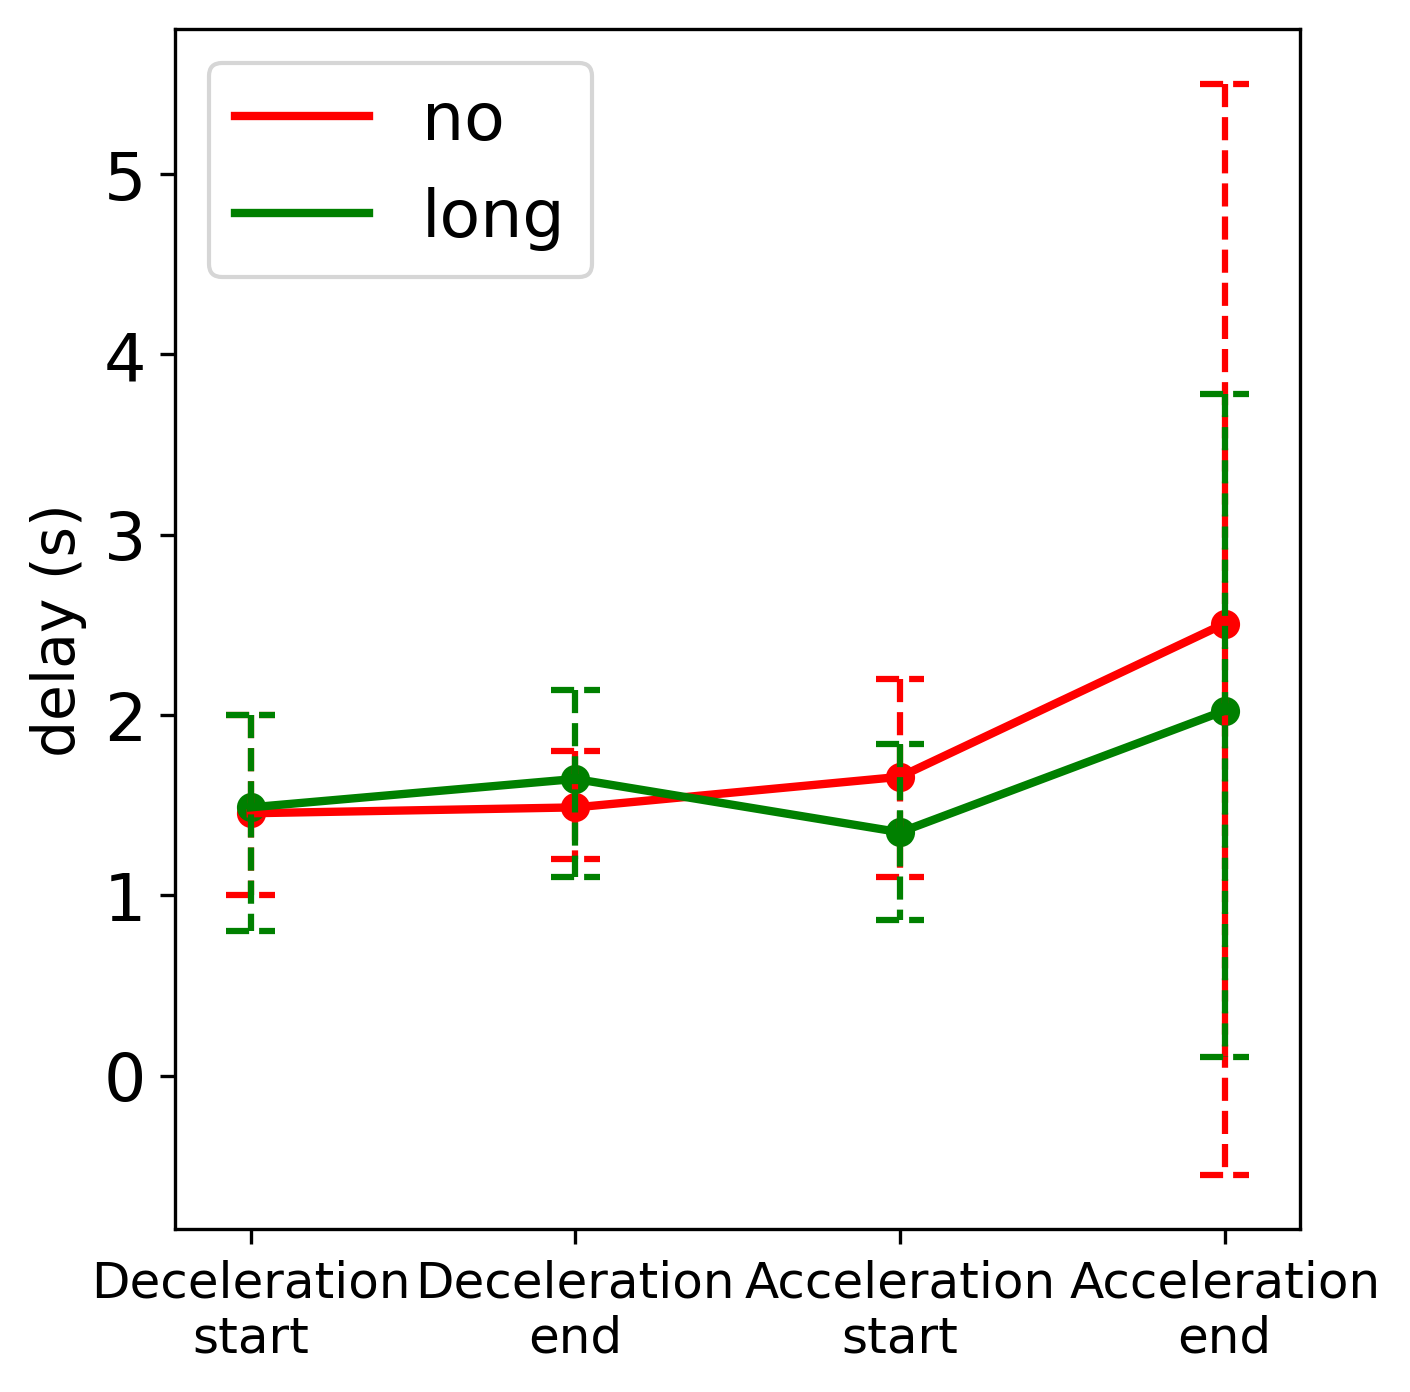

In [9]:
#2.2 delay - cruise pattern
oscillation_features_copy = oscillation_features.copy()
for i in range(len(oscillation_features_copy)):
    oscillation_features_copy[i] = oscillation_features_copy[i] + oscillation_features_copy[i][5][0]

impact_factor_column = 7
impact_factor_group_label = ['no', 'long']
feature_column_group = [11, 12, 13, 14]
feature_column_group_label = ['Deceleration\nstart', 'Deceleration\nend', 'Acceleration\nstart', 'Acceleration\nend']
x_label = ''
y_label = 'delay (s)'

bar_plot(oscillation_features_copy, impact_factor_column, feature_column_group,impact_factor_group_label, feature_column_group_label, 
         x_label, y_label, bar=True)

1 Deceleration
end 1.42 Deceleration
start 1.39 p-value 0.8


1 Acceleration
start 1.42 Deceleration
end 1.42 p-value 1.0


1 Acceleration
end 1.97 Acceleration
start 1.42 p-value 0.126


3 Deceleration
end 1.71 Deceleration
start 1.55 p-value 0.078


3 Acceleration
start 1.59 Deceleration
end 1.71 p-value 0.193


3 Acceleration
end 2.55 Acceleration
start 1.59 p-value 0.037


Deceleration
start 3 1.55 1 1.39 p-value 0.148


Deceleration
end 3 1.71 1 1.42 p-value 0.0


Acceleration
start 3 1.59 1 1.42 p-value 0.079


Acceleration
end 3 2.55 1 1.97 p-value 0.308




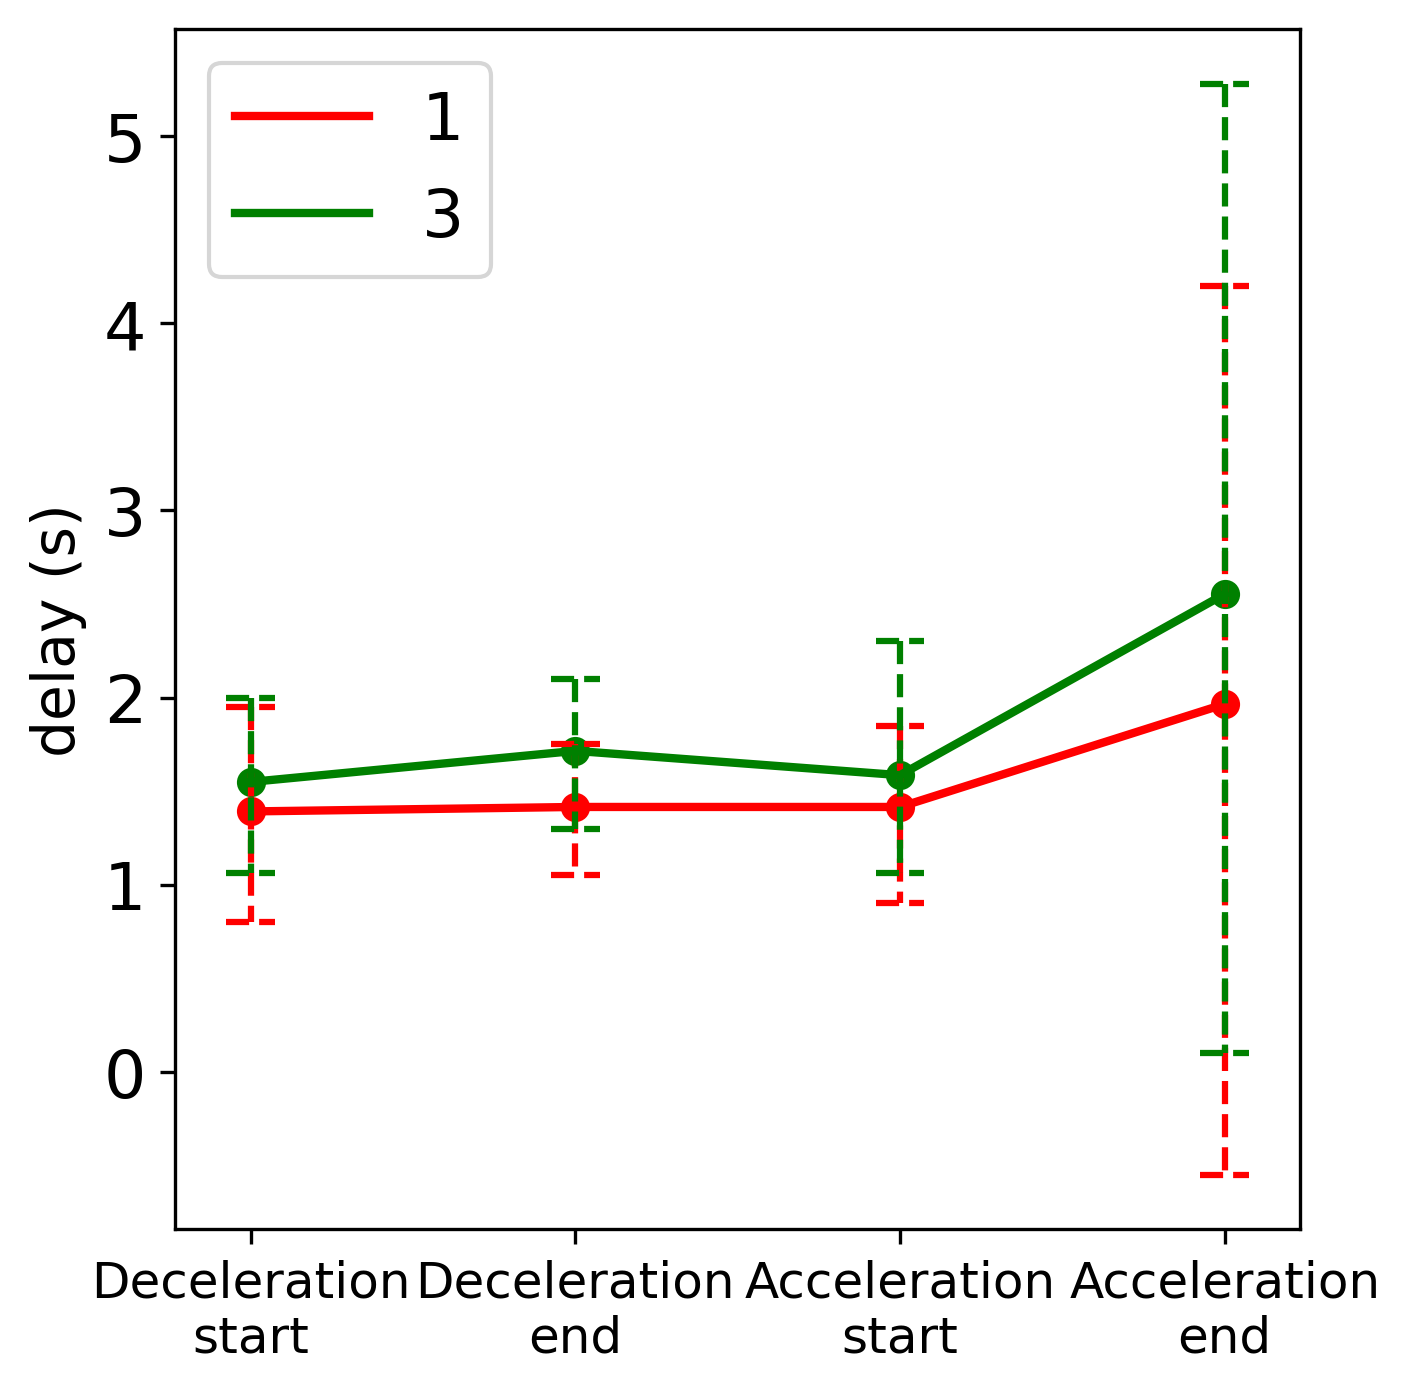

In [5]:
#2.3 delay - headway
oscillation_features_copy = oscillation_features.copy()
for i in range(len(oscillation_features_copy)):
    oscillation_features_copy[i] = oscillation_features_copy[i] + oscillation_features_copy[i][5][0]

impact_factor_column = 8
impact_factor_group_label = ['1', '3']
feature_column_group = [11, 12, 13, 14]
feature_column_group_label = ['Deceleration\nstart', 'Deceleration\nend', 'Acceleration\nstart', 'Acceleration\nend']
x_label = ''
y_label = 'delay (s)'

bar_plot(oscillation_features_copy, impact_factor_column, feature_column_group,impact_factor_group_label, feature_column_group_label, 
         x_label, y_label, bar=True)

strong Deceleration
end 1.52 Deceleration
start 1.44 p-value 0.47351144518788346


strong Acceleration
start 1.48 Deceleration
end 1.52 p-value 0.6865054983260654


strong Acceleration
end 2.0 Acceleration
start 1.48 p-value 0.1602548785187849


mild Deceleration
end 1.6 Deceleration
start 1.39 p-value 0.09176638743828061


mild Acceleration
start 1.51 Deceleration
end 1.6 p-value 0.35525621016798115


mild Acceleration
end 2.56 Acceleration
start 1.51 p-value 0.01802566960809706


Deceleration
start mild 1.39 strong 1.44 p-value 0.7442341116595237


Deceleration
end mild 1.6 strong 1.52 p-value 0.30433584911730666


Acceleration
start mild 1.51 strong 1.48 p-value 0.7609759529318493


Acceleration
end mild 2.56 strong 2.0 p-value 0.3233653771965409




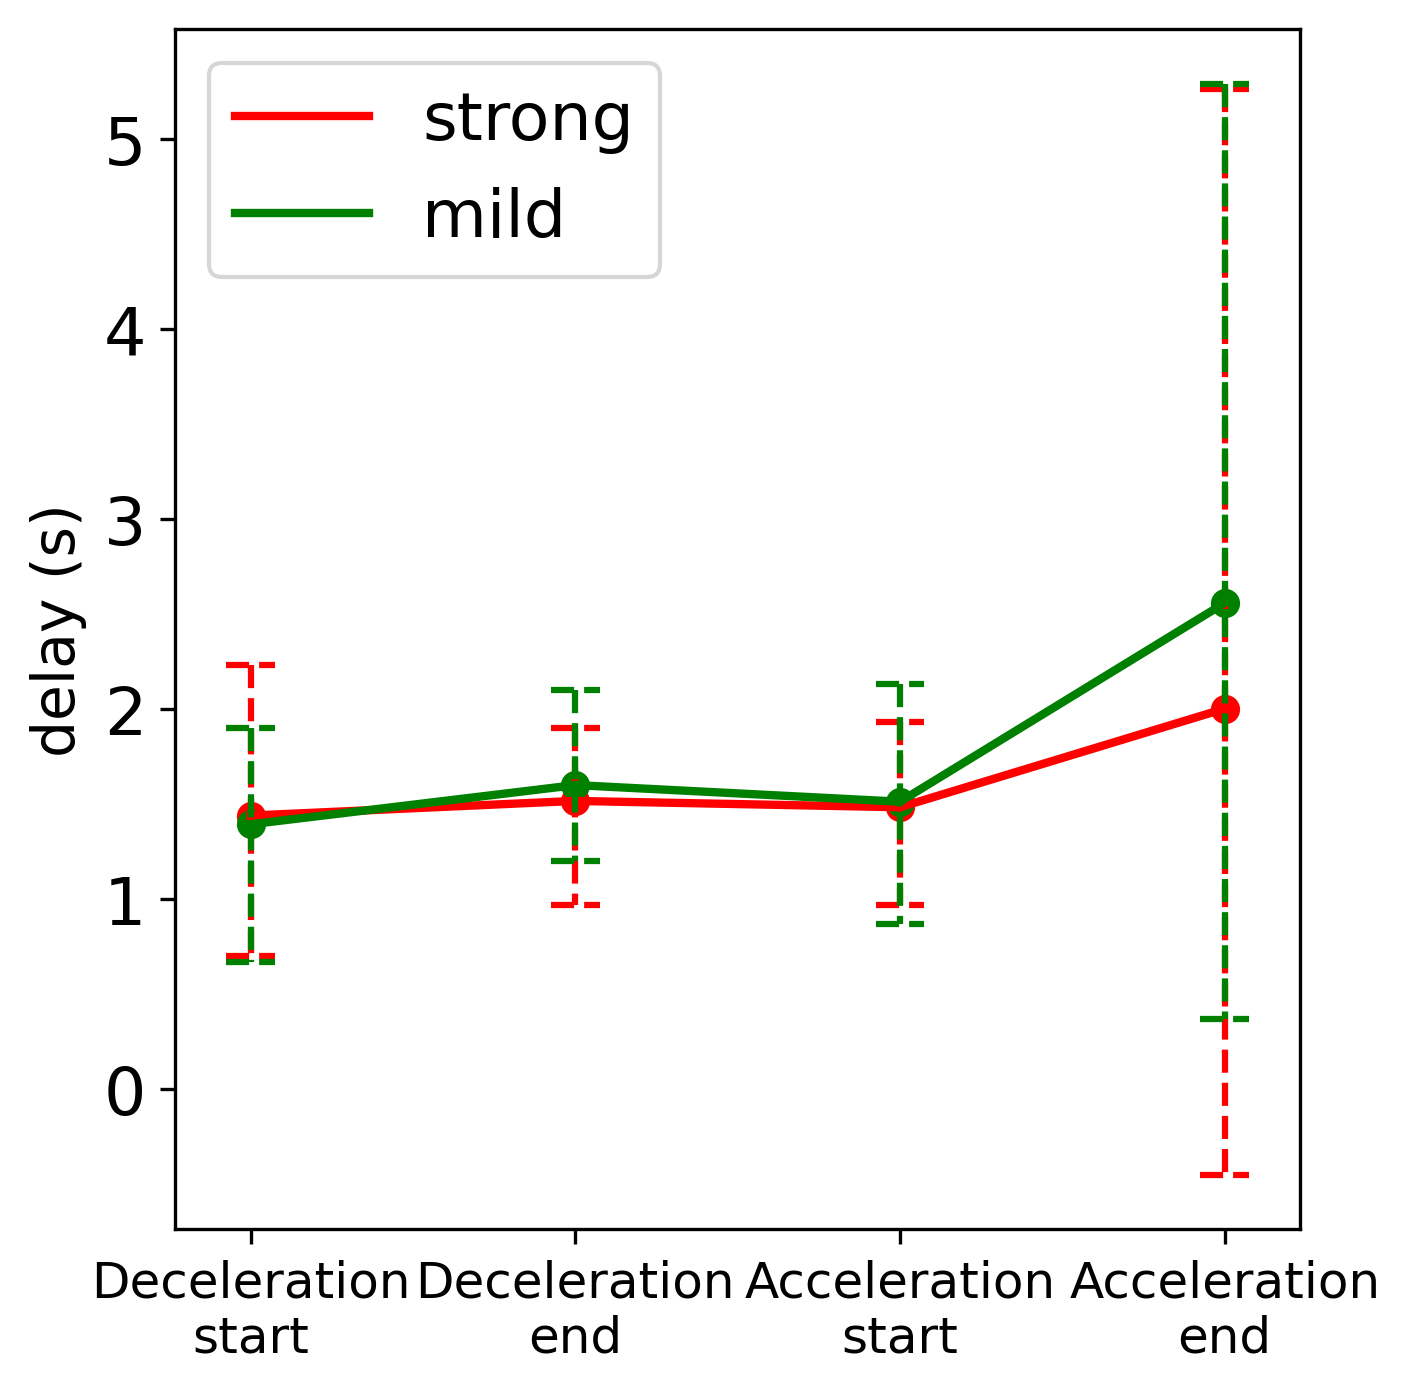

In [13]:
#2.4 delay - magnitude
oscillation_features_copy = oscillation_features.copy()
for i in range(len(oscillation_features_copy)):
    oscillation_features_copy[i] = oscillation_features_copy[i] + oscillation_features_copy[i][5][0]

impact_factor_column = 9
impact_factor_group_label = ['strong', 'mild']
feature_column_group = [11, 12, 13, 14]
feature_column_group_label = ['Deceleration\nstart', 'Deceleration\nend', 'Acceleration\nstart', 'Acceleration\nend']
x_label = ''
y_label = 'delay (s)'

bar_plot(oscillation_features_copy, impact_factor_column, feature_column_group,impact_factor_group_label, feature_column_group_label, 
         x_label, y_label, bar=True)

strong Deceleration
end 1.6 Deceleration
start 1.25 p-value 0.007882225348124527


strong Acceleration
start 1.5 Deceleration
end 1.6 p-value 0.3446989232857469


strong Acceleration
end 2.79 Acceleration
start 1.5 p-value 0.007997912725397432


mild Deceleration
end 1.54 Deceleration
start 1.48 p-value 0.5785235799262252


mild Acceleration
start 1.5 Deceleration
end 1.54 p-value 0.5681985505898655


mild Acceleration
end 2.07 Acceleration
start 1.5 p-value 0.10428750495635436


Deceleration
start mild 1.48 strong 1.25 p-value 0.13401158746101152


Deceleration
end mild 1.54 strong 1.6 p-value 0.47486476242767894


Acceleration
start mild 1.5 strong 1.5 p-value 0.9396794443545953


Acceleration
end mild 2.07 strong 2.79 p-value 0.24228370312320324




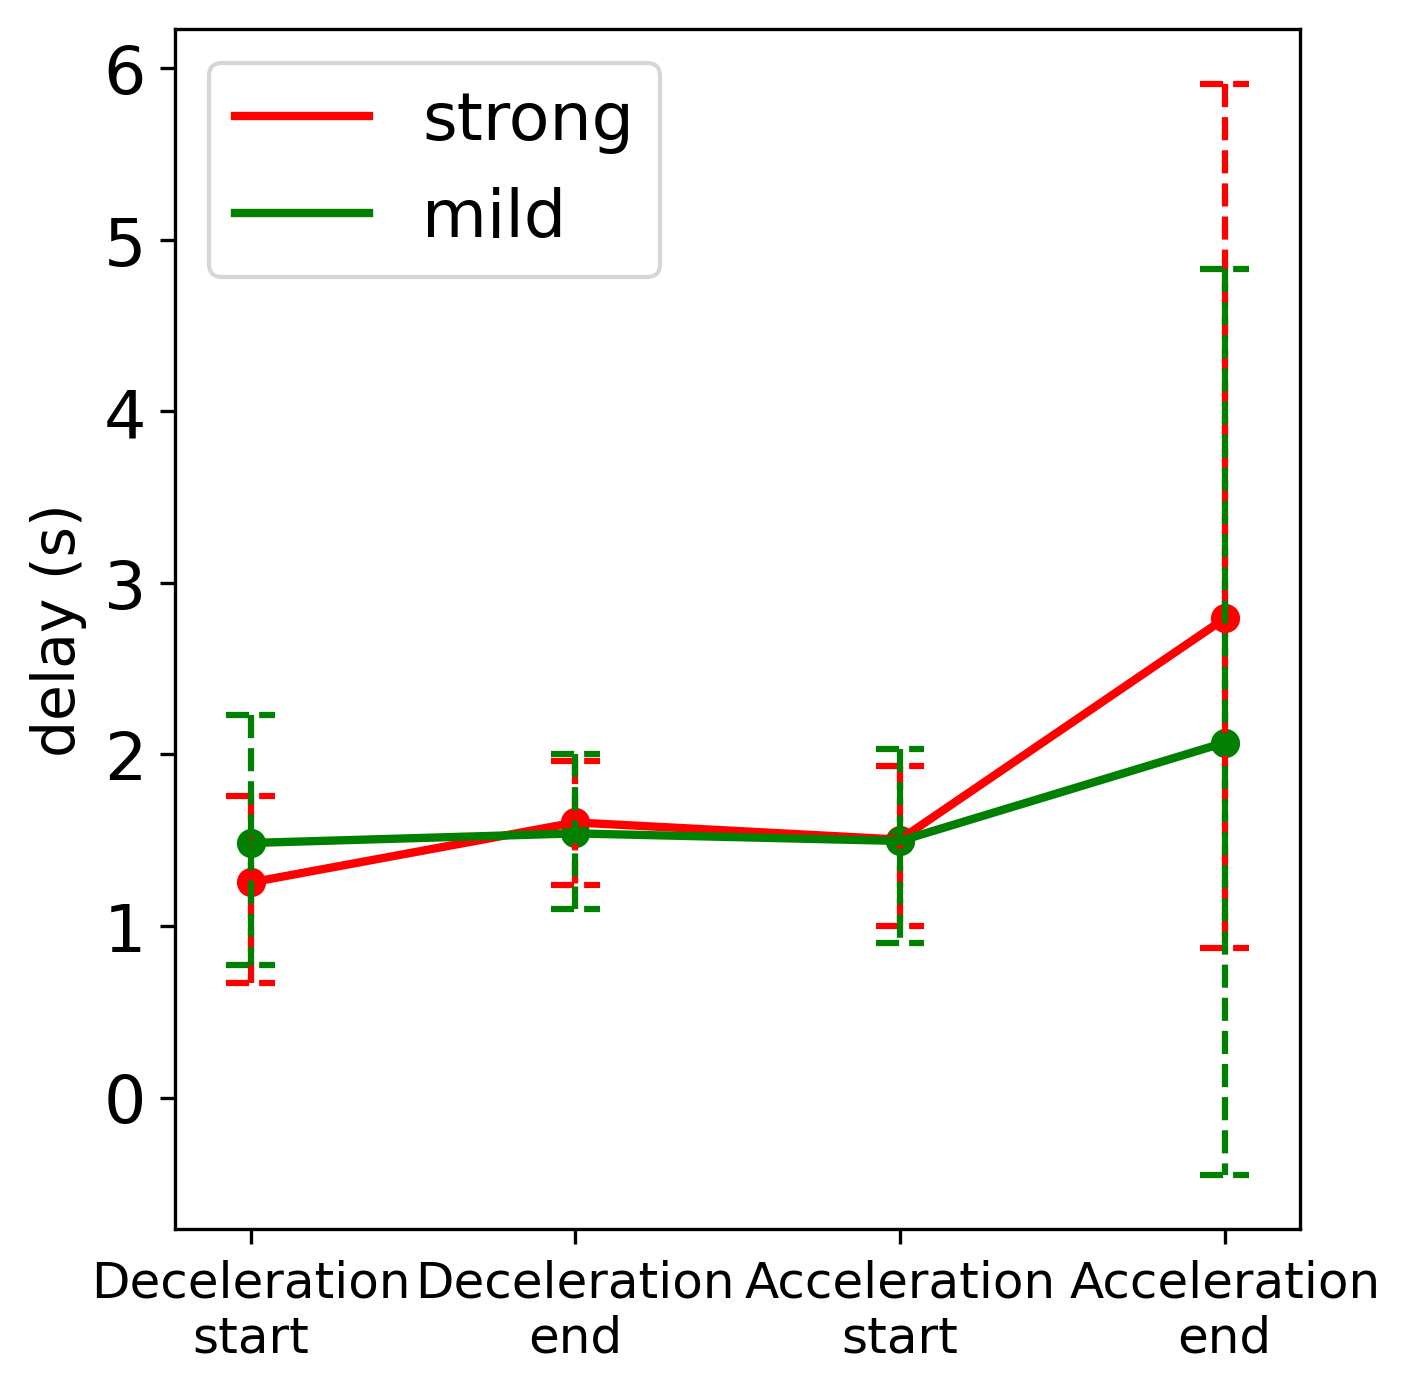

In [14]:
#2.5 delay - brake pattern
oscillation_features_copy = oscillation_features.copy()
for i in range(len(oscillation_features_copy)):
    oscillation_features_copy[i] = oscillation_features_copy[i] + oscillation_features_copy[i][5][0]

impact_factor_column = 10
impact_factor_group_label = ['strong', 'mild']
feature_column_group = [11, 12, 13, 14]
feature_column_group_label = ['Deceleration\nstart', 'Deceleration\nend', 'Acceleration\nstart', 'Acceleration\nend']
x_label = ''
y_label = 'delay (s)'

bar_plot(oscillation_features_copy, impact_factor_column, feature_column_group,impact_factor_group_label, feature_column_group_label, 
         x_label, y_label, bar=True)

HV mid 1.09 low 1.08 p-value 0.8817859454189708


HV high 0.97 mid 1.09 p-value 0.1413954814244765


ACC1 mid 1.14 low 1.21 p-value 0.4653488552098518


ACC1 high 0.92 mid 1.14 p-value 0.02111657689108553


low ACC1 1.21 HV 1.08 p-value 0.1411624214027784


mid ACC1 1.14 HV 1.09 p-value 0.6211364338441093


high ACC1 0.92 HV 0.97 p-value 0.5953449630510312




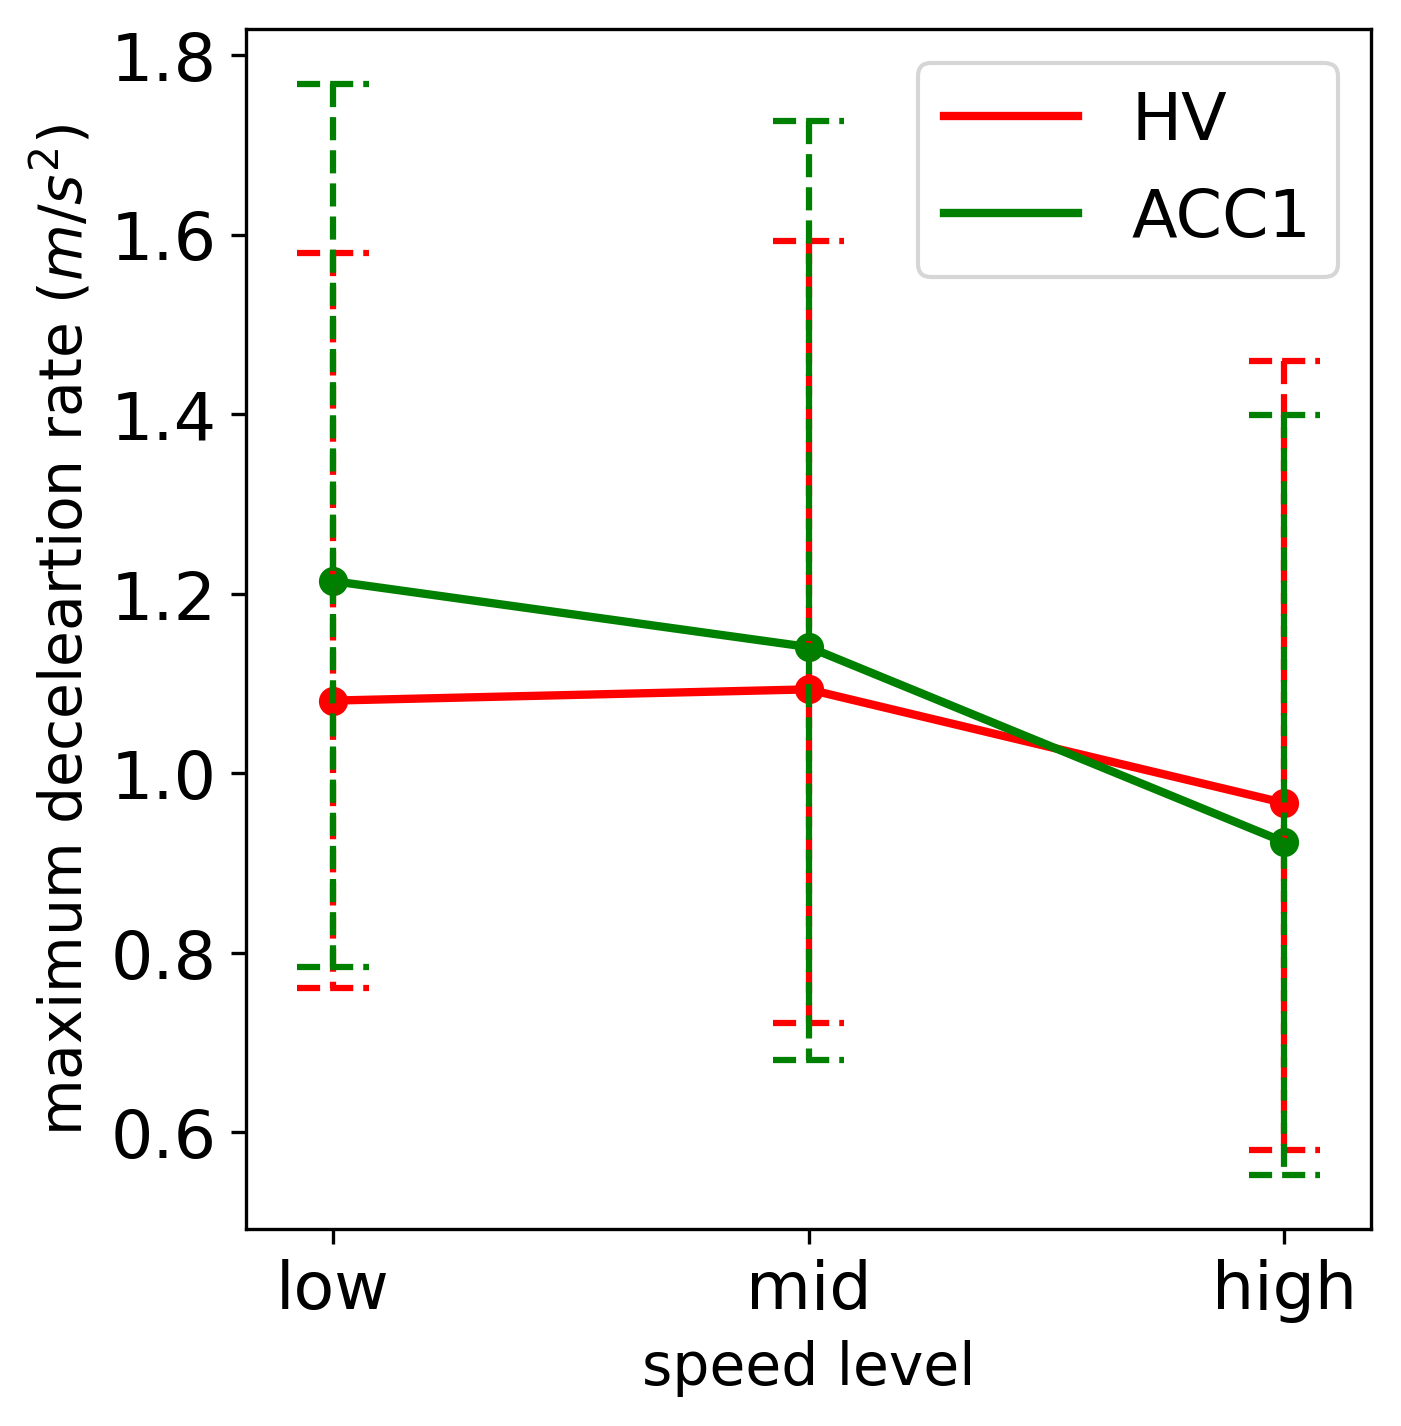

HV mid 0.84 low 0.82 p-value 0.7537874583480926


HV high 0.73 mid 0.84 p-value 0.09094627798187296


ACC1 mid 0.86 low 0.8 p-value 0.21079871168488884


ACC1 high 0.69 mid 0.86 p-value 0.0003634291941892964


low ACC1 0.8 HV 0.82 p-value 0.7683609086191179


mid ACC1 0.86 HV 0.84 p-value 0.6406577102647874


high ACC1 0.69 HV 0.73 p-value 0.5356527429562874




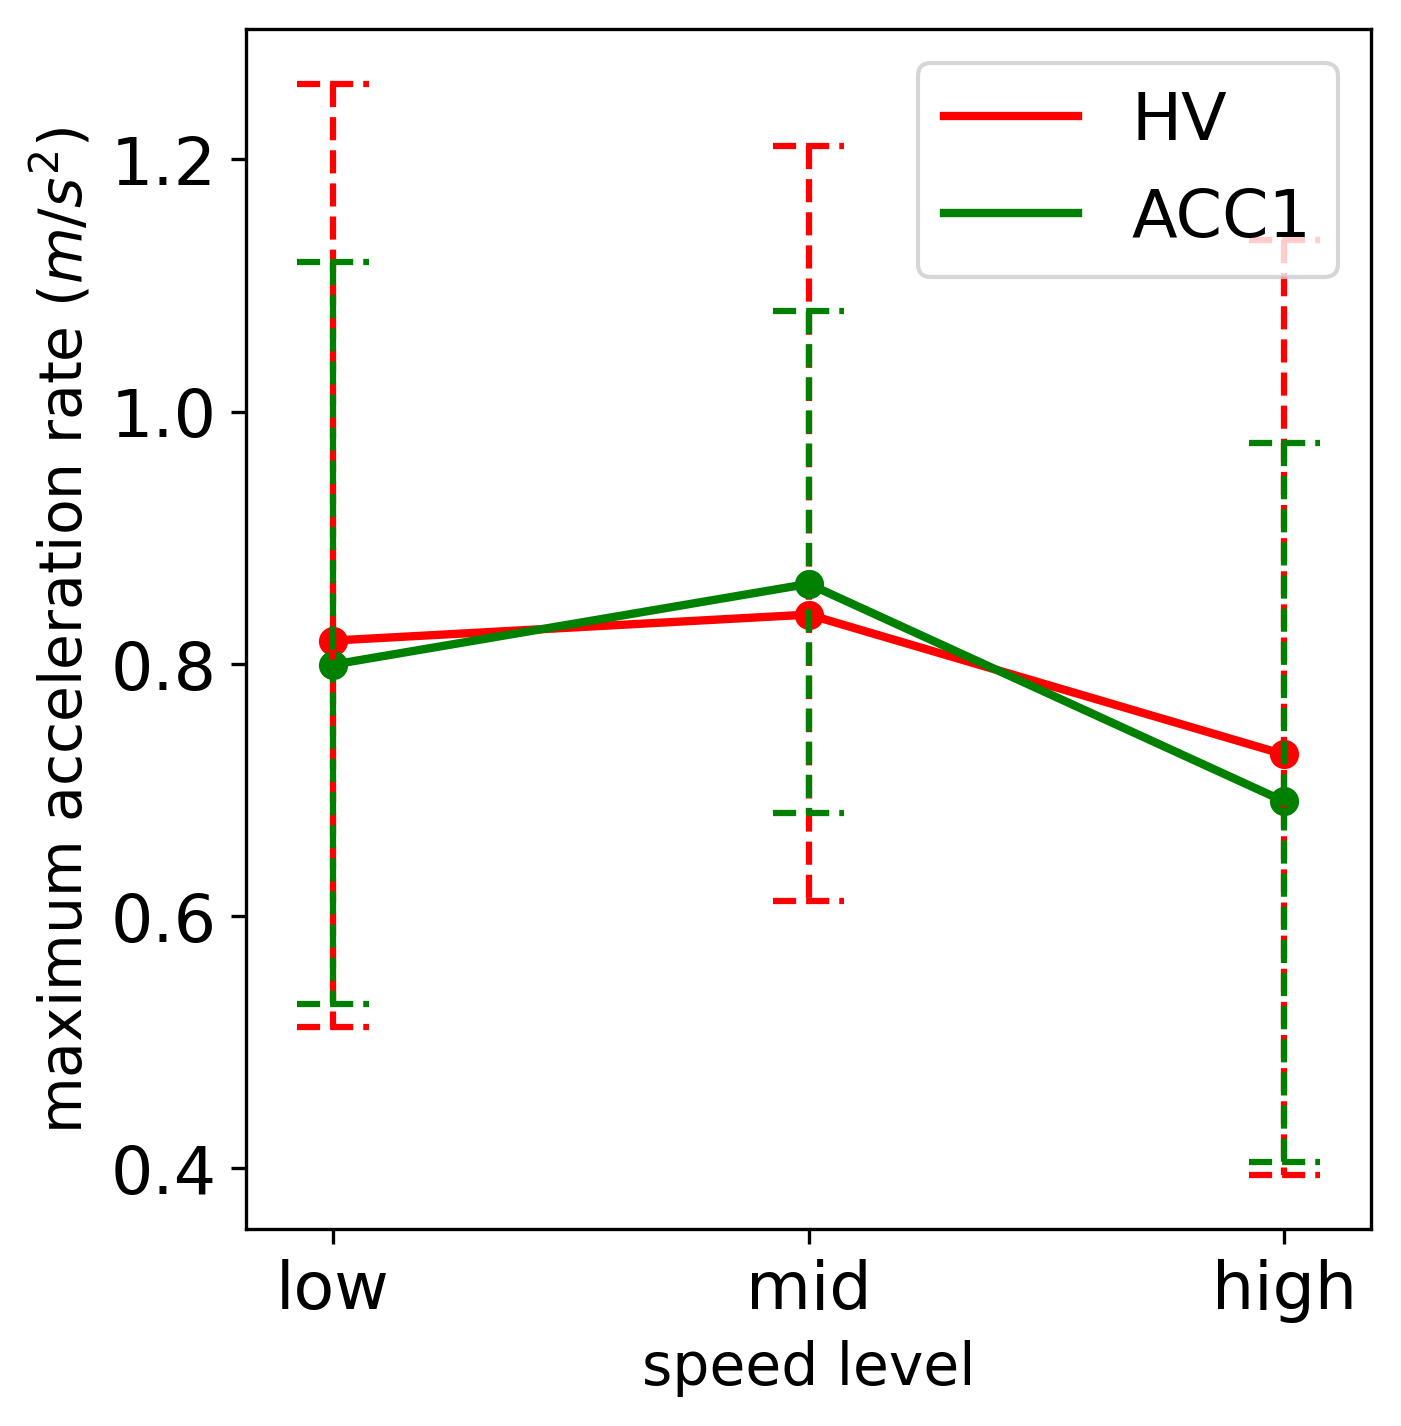

HV mid 0.74 low 0.72 p-value 0.7250154756033105


HV high 0.65 mid 0.74 p-value 0.12316044357070759


ACC1 mid 0.75 low 0.8 p-value 0.41456118011005283


ACC1 high 0.6 mid 0.75 p-value 0.012139767575661879


low ACC1 0.8 HV 0.72 p-value 0.20001775072421485


mid ACC1 0.75 HV 0.74 p-value 0.9249035674003686


high ACC1 0.6 HV 0.65 p-value 0.30983790162716485




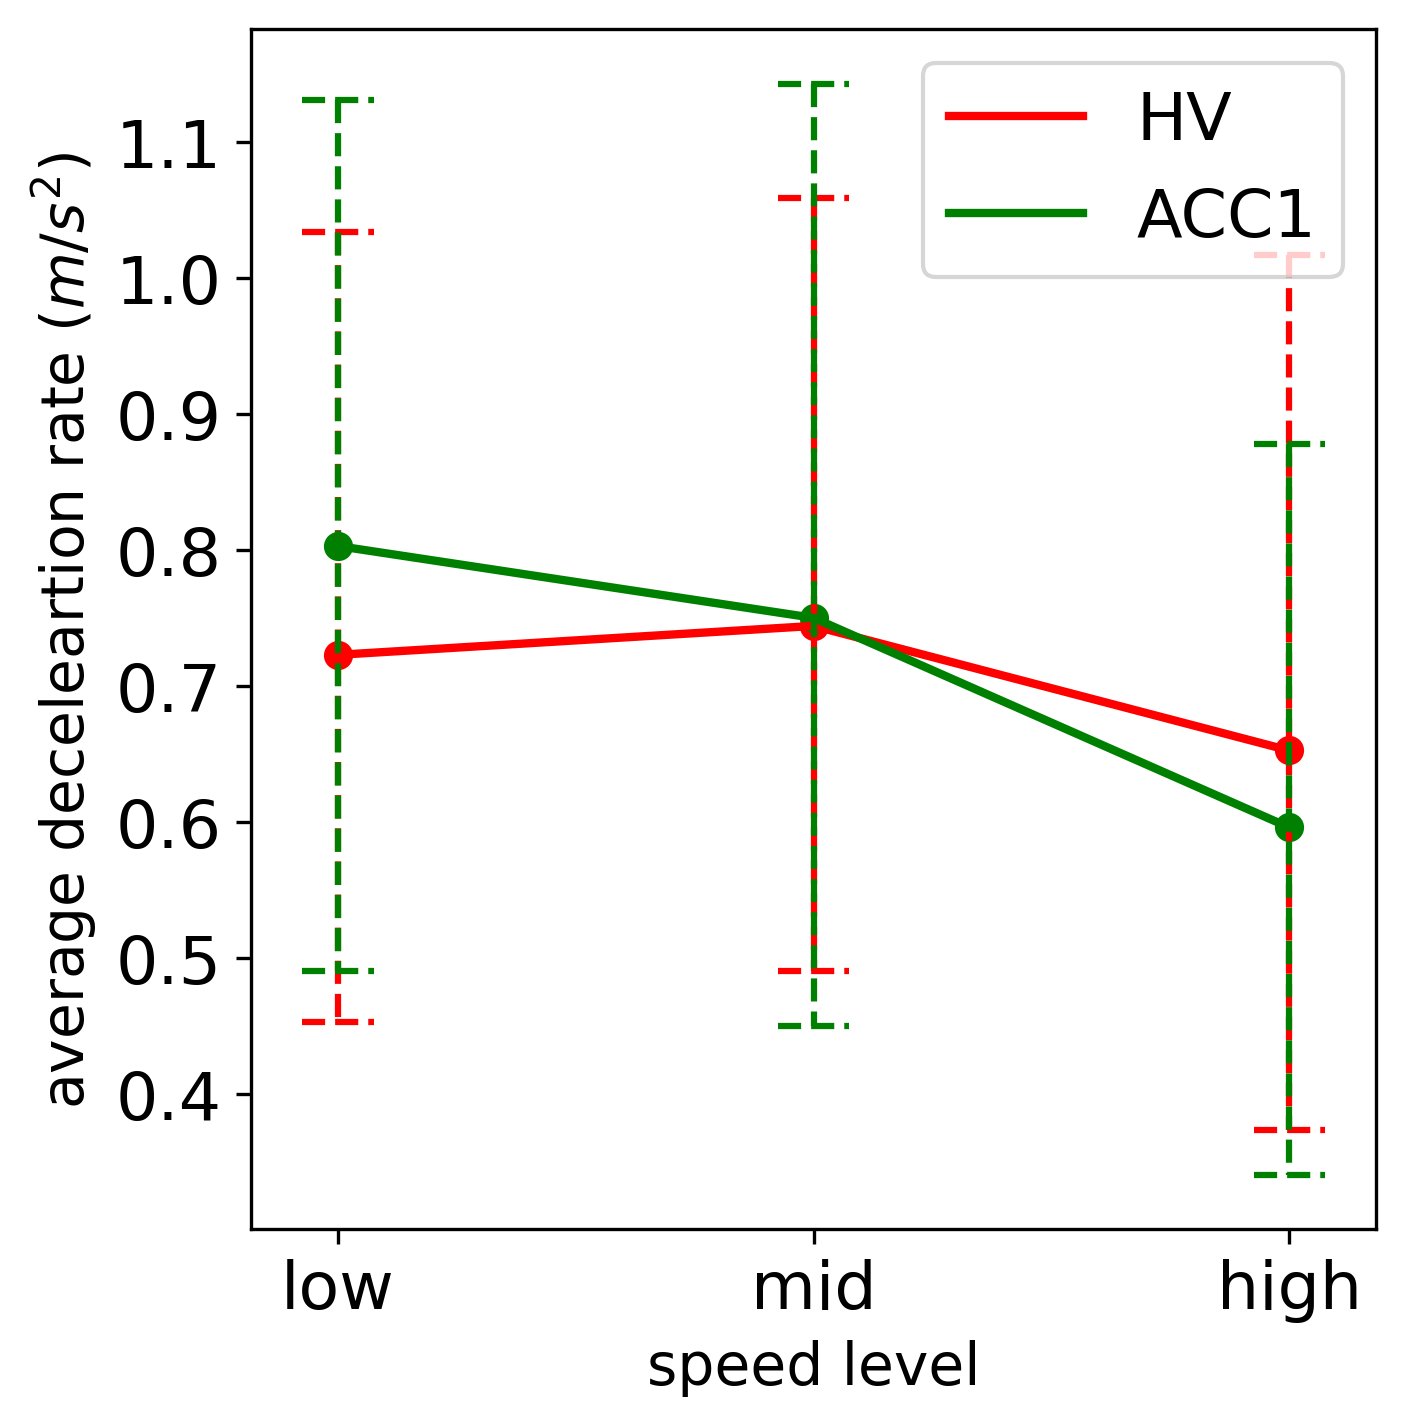

HV mid 0.53 low 0.53 p-value 0.9697964678843776


HV high 0.46 mid 0.53 p-value 0.1316763728478398


ACC1 mid 0.53 low 0.52 p-value 0.8898110433981201


ACC1 high 0.36 mid 0.53 p-value 4.929073230038328e-06


low ACC1 0.52 HV 0.53 p-value 0.8922525008213016


mid ACC1 0.53 HV 0.53 p-value 0.9464520656742137


high ACC1 0.36 HV 0.46 p-value 0.007195634064732268




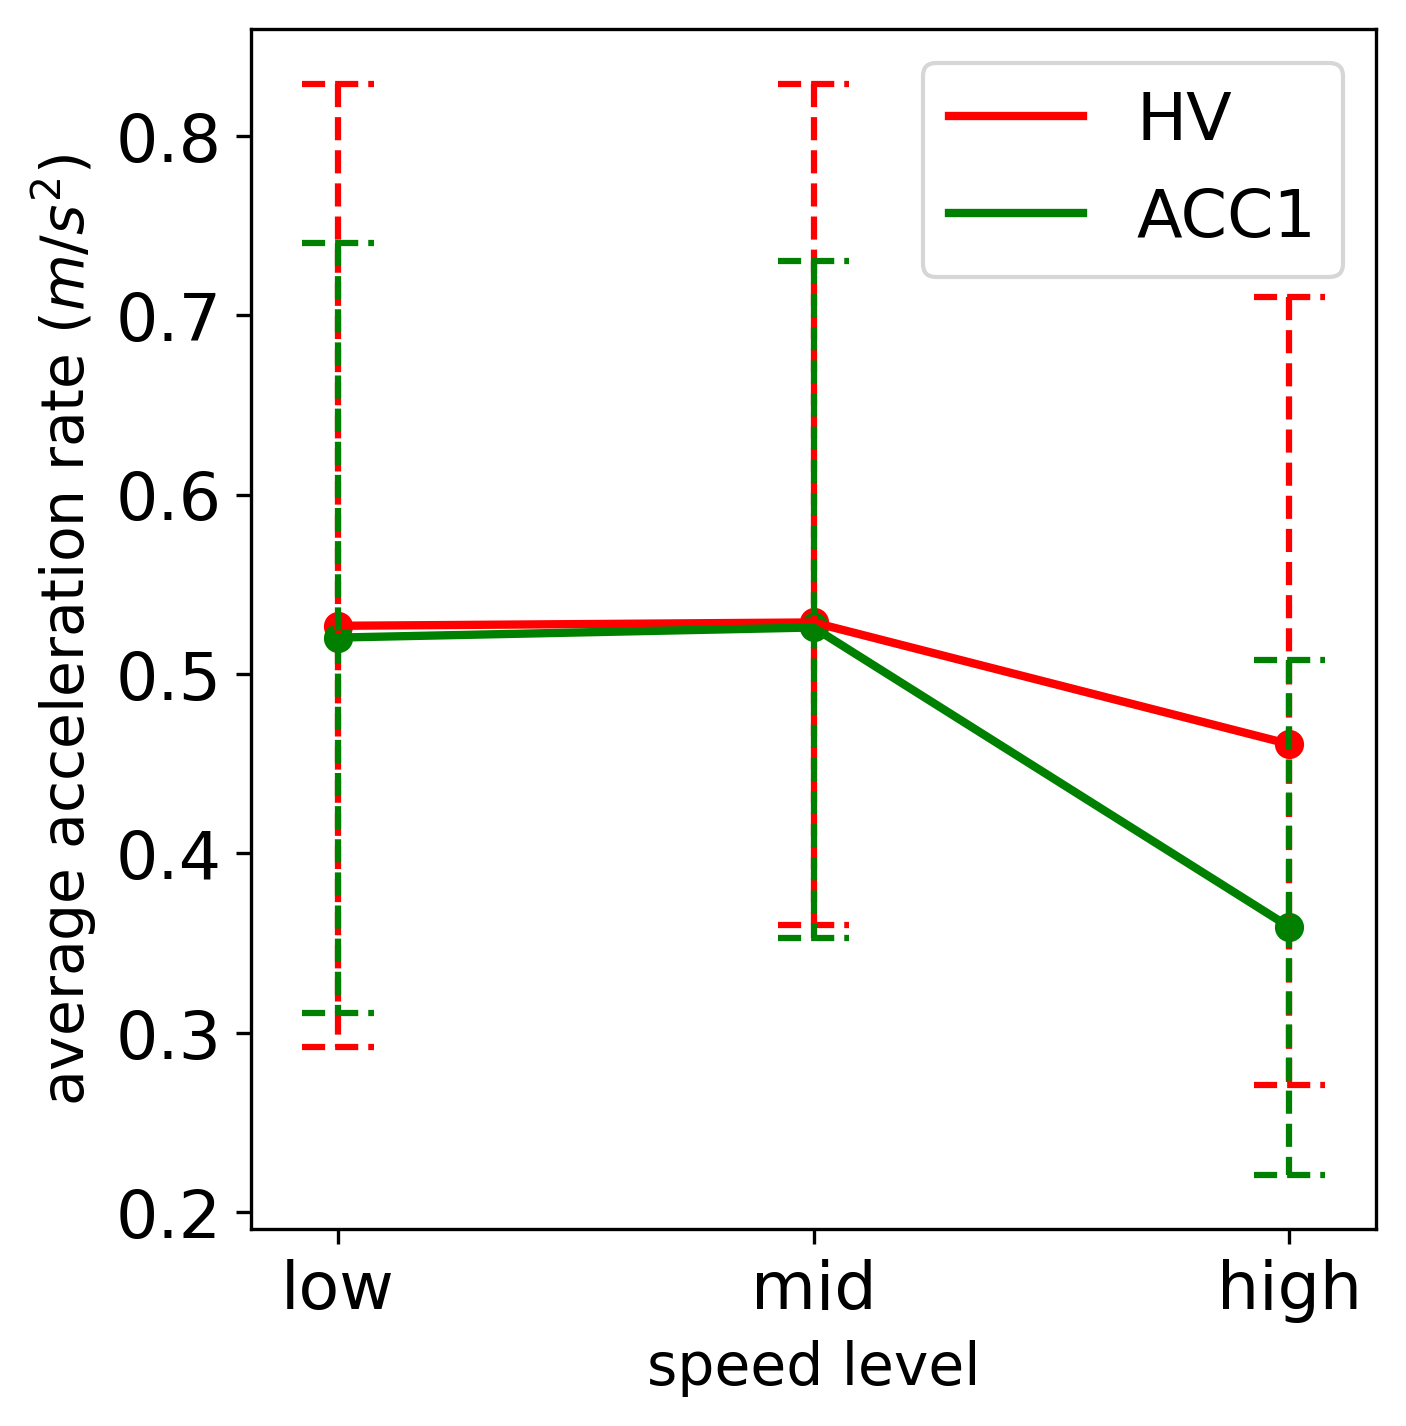

In [5]:
#3.1 deceleration & acceleration rate - speed level
oscillation_features_copy = oscillation_features.copy()
for i in range(len(oscillation_features_copy)):
    oscillation_features_copy[i] = oscillation_features_copy[i] + oscillation_features_copy[i][6][0][:2]\
                                    + oscillation_features_copy[i][6][2][:2] \
                                    + oscillation_features_copy[i][6][1][:2] \
                                    + oscillation_features_copy[i][6][3][:2]

impact_factor_column = 3
impact_factor_group_label = ['low', 'mid', 'high']
x_label = 'speed level'

feature_column_group = [15, 16]
feature_column_group_label = ['HV', 'ACC1']
y_label = 'maximum deceleartion rate ($m$/$s^2$)'
bar_plot_inverse(oscillation_features_copy, impact_factor_column, feature_column_group,impact_factor_group_label, feature_column_group_label, 
         x_label, y_label, bar=True)

feature_column_group = [17, 18]
feature_column_group_label = ['HV', 'ACC1']
y_label = 'maximum acceleration rate ($m$/$s^2$)'
bar_plot_inverse(oscillation_features_copy, impact_factor_column, feature_column_group,impact_factor_group_label, feature_column_group_label, 
         x_label, y_label, bar=True)

feature_column_group = [11, 12]
feature_column_group_label = ['HV', 'ACC1']
y_label = 'average deceleartion rate ($m$/$s^2$)'
bar_plot_inverse(oscillation_features_copy, impact_factor_column, feature_column_group,impact_factor_group_label, feature_column_group_label, 
         x_label, y_label, bar=True)

feature_column_group = [13, 14]
feature_column_group_label = ['HV', 'ACC1']
y_label = 'average acceleration rate ($m$/$s^2$)'
bar_plot_inverse(oscillation_features_copy, impact_factor_column, feature_column_group,impact_factor_group_label, feature_column_group_label, 
         x_label, y_label, bar=True)

HV long 1.03 no 1.06 p-value 0.6170406425848827


ACC1 long 1.08 no 1.11 p-value 0.677796716747302


no ACC1 1.11 HV 1.06 p-value 0.5538901238913995


long ACC1 1.08 HV 1.03 p-value 0.5310193870572404




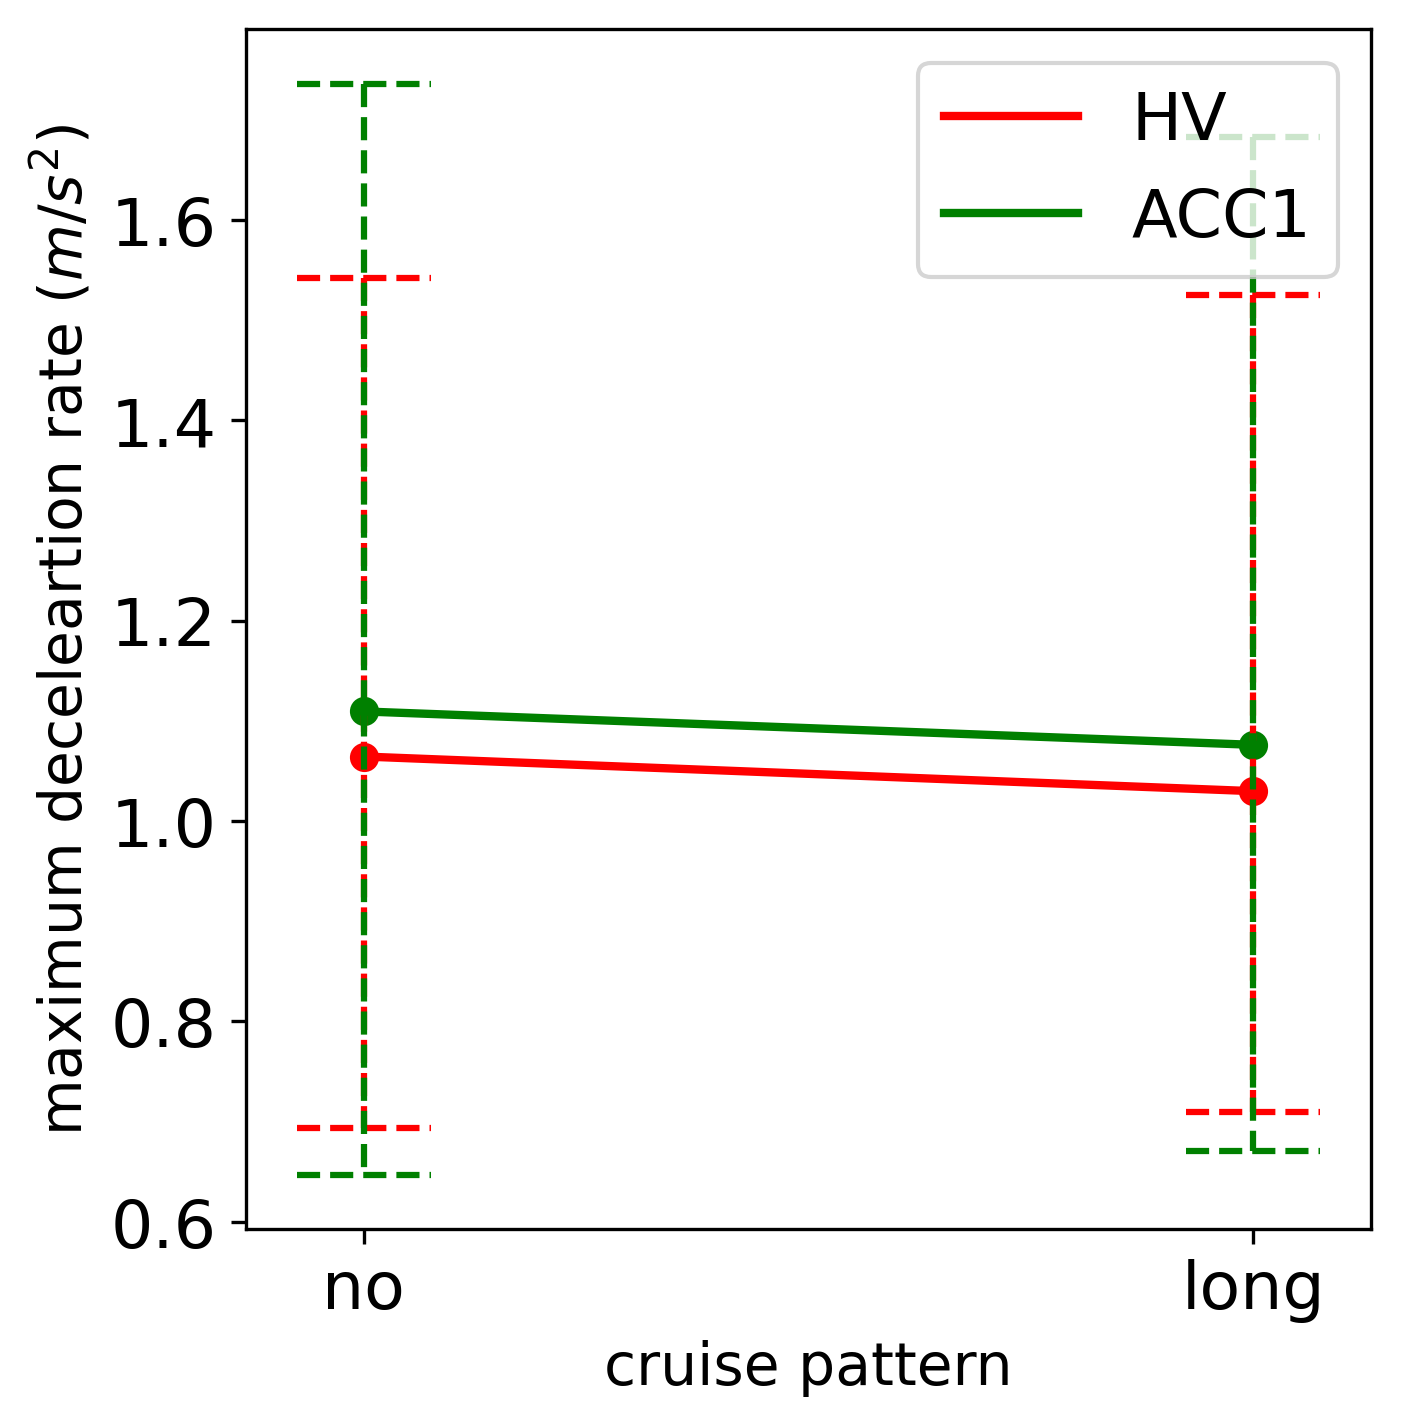

HV long 0.81 no 0.78 p-value 0.6078926109637193


ACC1 long 0.79 no 0.78 p-value 0.9324378868870429


no ACC1 0.78 HV 0.78 p-value 0.9757592769543826


long ACC1 0.79 HV 0.81 p-value 0.6568155506662782




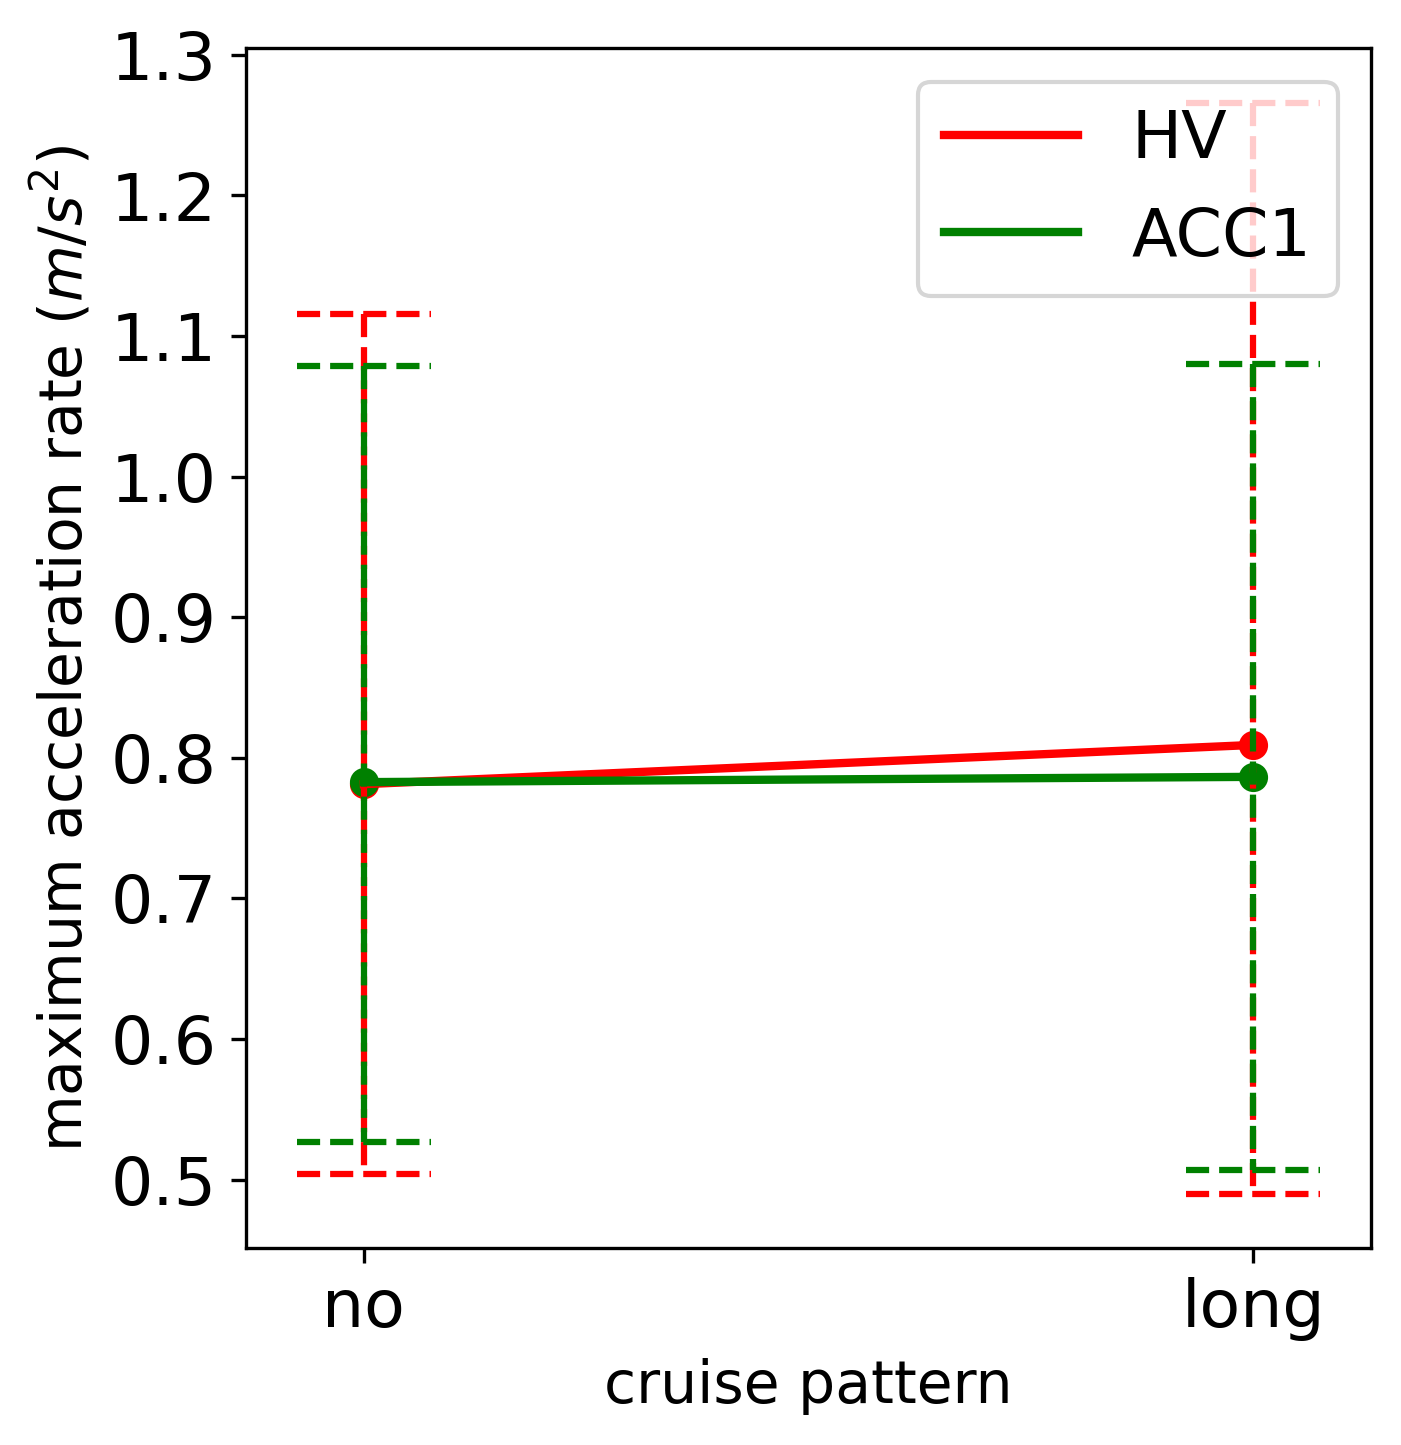

HV long 0.69 no 0.72 p-value 0.48965589694778067


ACC1 long 0.69 no 0.74 p-value 0.2981879764472773


no ACC1 0.74 HV 0.72 p-value 0.6997060834680524


long ACC1 0.69 HV 0.69 p-value 0.9932692610481597




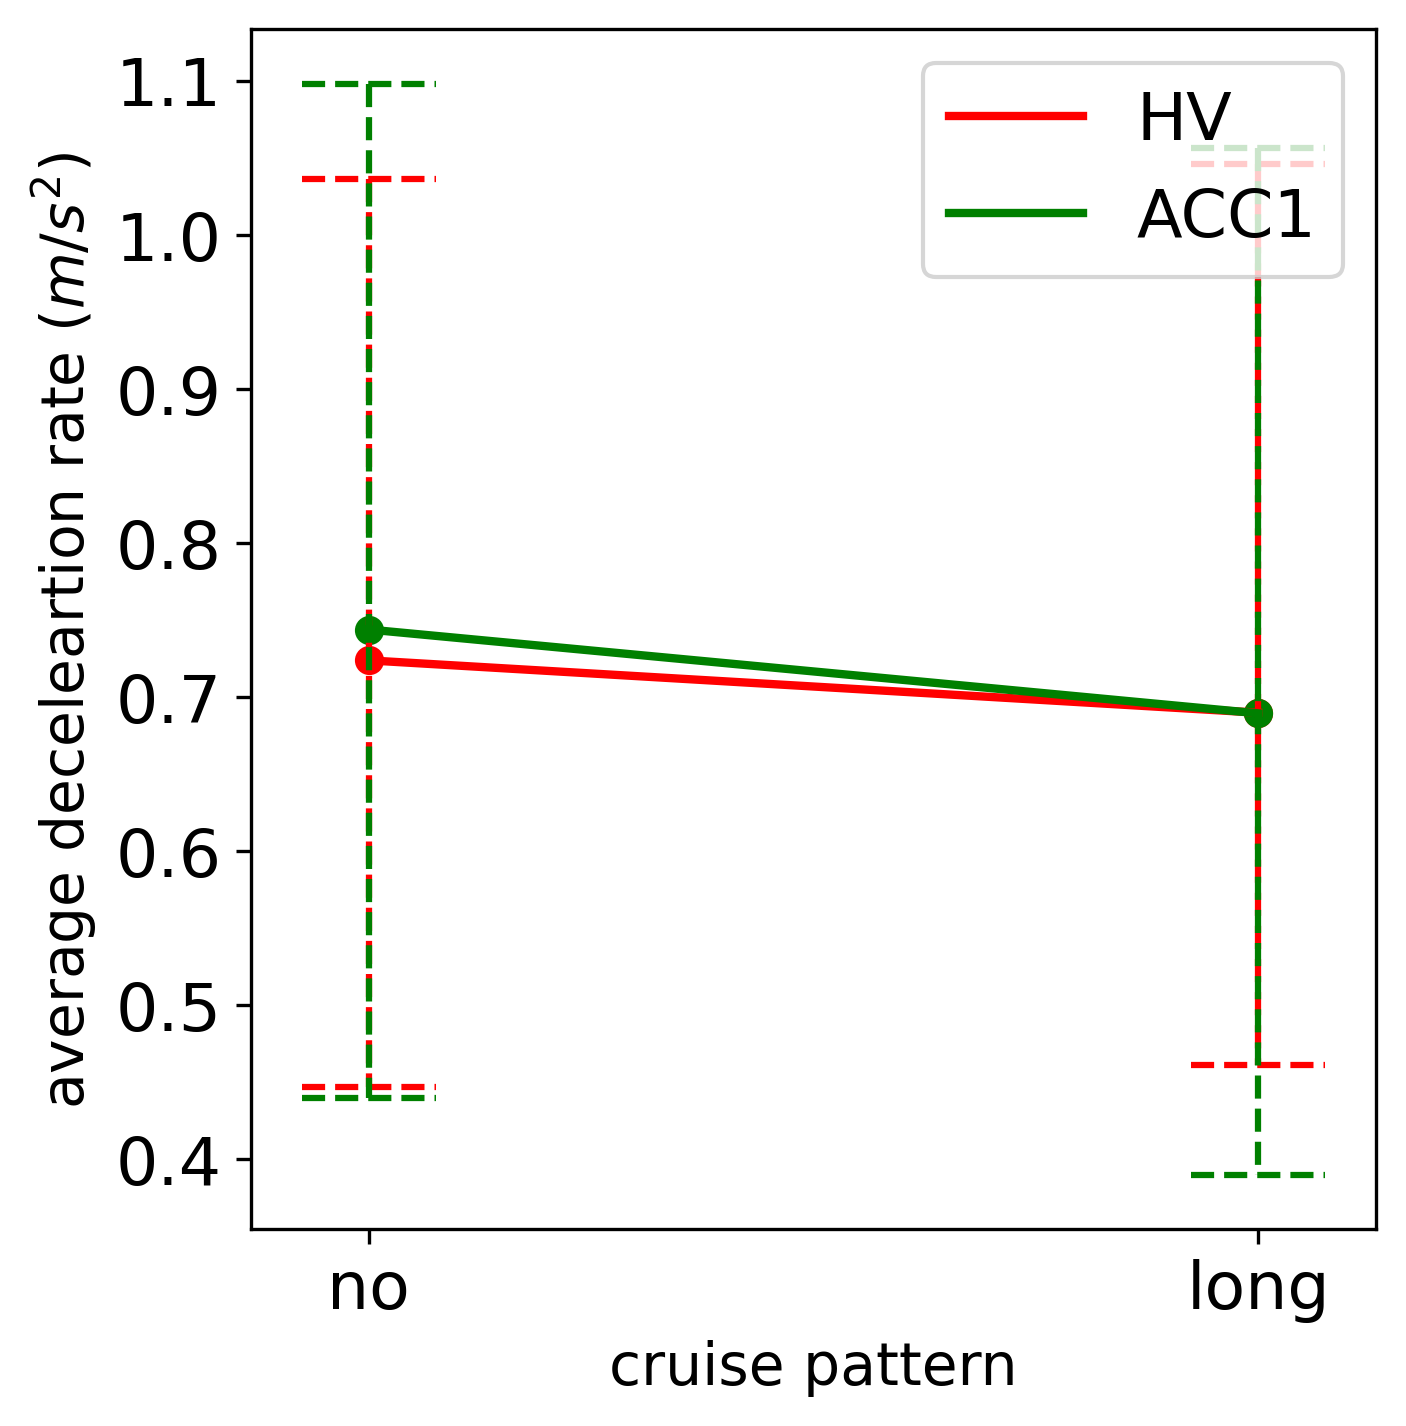

HV long 0.51 no 0.5 p-value 0.7601601771735531


ACC1 long 0.47 no 0.46 p-value 0.7291105464784158


no ACC1 0.46 HV 0.5 p-value 0.29597724609995857


long ACC1 0.47 HV 0.51 p-value 0.32898021455602733




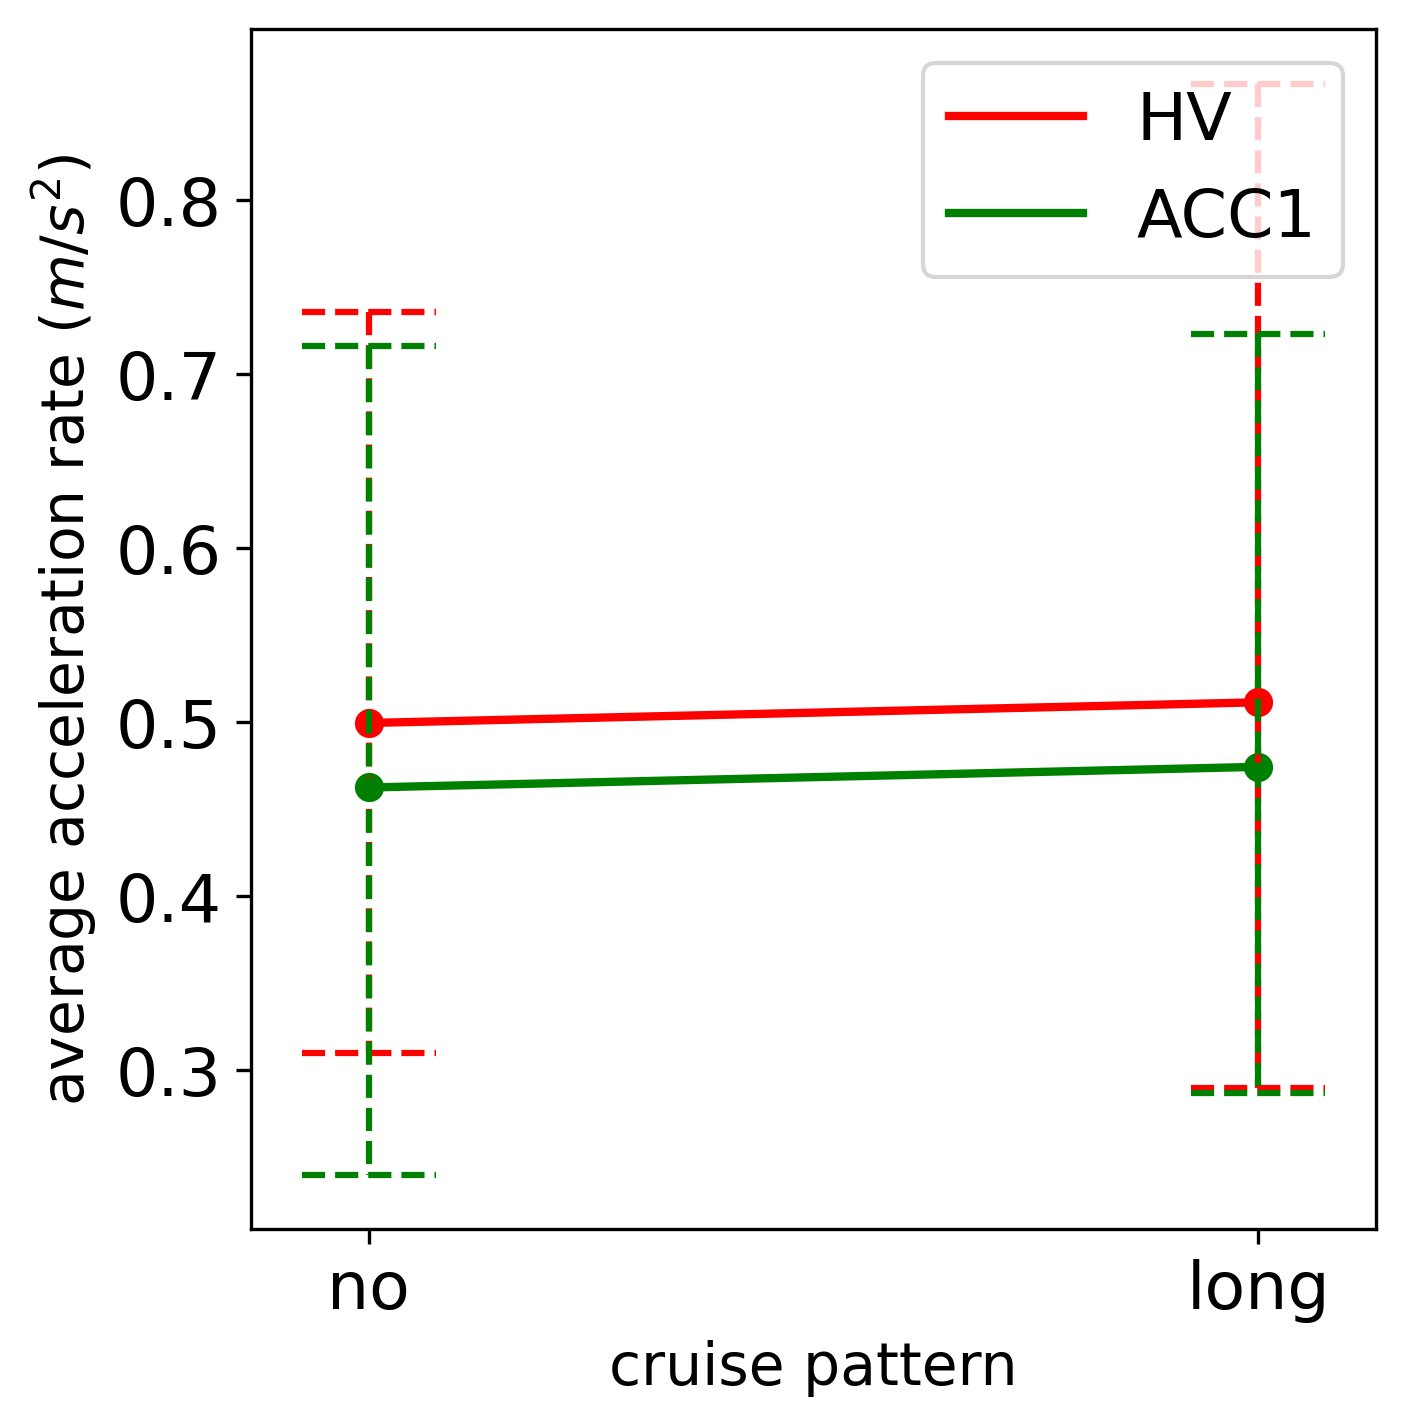

In [25]:
#3.2 deceleration & acceleration rate - cruise pattern
oscillation_features_copy = oscillation_features.copy()
for i in range(len(oscillation_features_copy)):
    oscillation_features_copy[i] = oscillation_features_copy[i] + oscillation_features_copy[i][6][0][:2]\
                                    + oscillation_features_copy[i][6][2][:2] \
                                    + oscillation_features_copy[i][6][1][:2] \
                                    + oscillation_features_copy[i][6][3][:2]

impact_factor_column = 7
impact_factor_group_label = ['no', 'long']
x_label = 'cruise pattern'

feature_column_group = [15, 16]
feature_column_group_label = ['HV', 'ACC1']
y_label = 'maximum deceleartion rate ($m$/$s^2$)'
bar_plot_inverse(oscillation_features_copy, impact_factor_column, feature_column_group,impact_factor_group_label, feature_column_group_label, 
         x_label, y_label, bar=True)

feature_column_group = [17, 18]
feature_column_group_label = ['HV', 'ACC1']
y_label = 'maximum acceleration rate ($m$/$s^2$)'
bar_plot_inverse(oscillation_features_copy, impact_factor_column, feature_column_group,impact_factor_group_label, feature_column_group_label, 
         x_label, y_label, bar=True)

feature_column_group = [11, 12]
feature_column_group_label = ['HV', 'ACC1']
y_label = 'average deceleartion rate ($m$/$s^2$)'
bar_plot_inverse(oscillation_features_copy, impact_factor_column, feature_column_group,impact_factor_group_label, feature_column_group_label, 
         x_label, y_label, bar=True)

feature_column_group = [13, 14]
feature_column_group_label = ['HV', 'ACC1']
y_label = 'average acceleration rate ($m$/$s^2$)'
bar_plot_inverse(oscillation_features_copy, impact_factor_column, feature_column_group,impact_factor_group_label, feature_column_group_label, 
         x_label, y_label, bar=True)

HV 3 1.05 1 1.05 p-value 0.9567867095597419


ACC1 3 1.04 1 1.14 p-value 0.1996283376510755


1 ACC1 1.14 HV 1.05 p-value 0.2270275353586764


3 ACC1 1.04 HV 1.05 p-value 0.9576372860193996




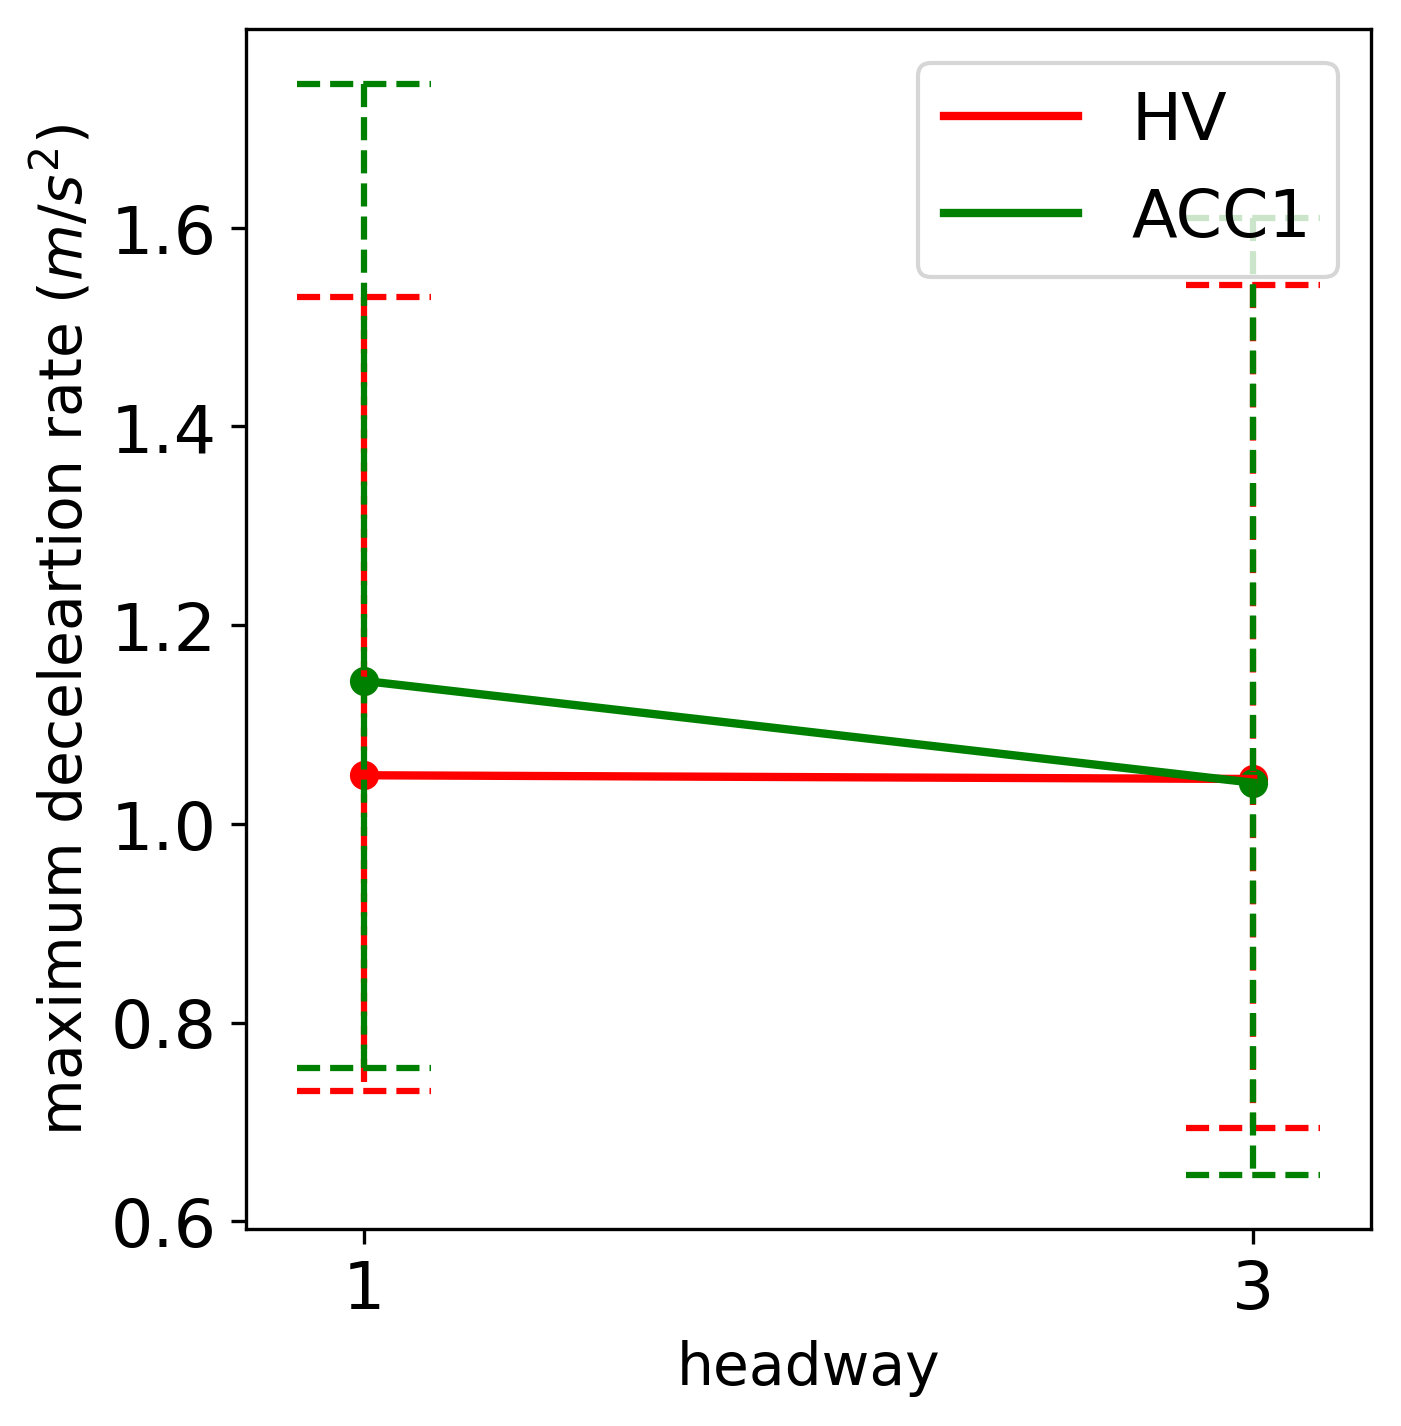

HV 3 0.78 1 0.81 p-value 0.5248733689450106


ACC1 3 0.74 1 0.83 p-value 0.039615973074348464


1 ACC1 0.83 HV 0.81 p-value 0.7184883598686488


3 ACC1 0.74 HV 0.78 p-value 0.4509049808801786




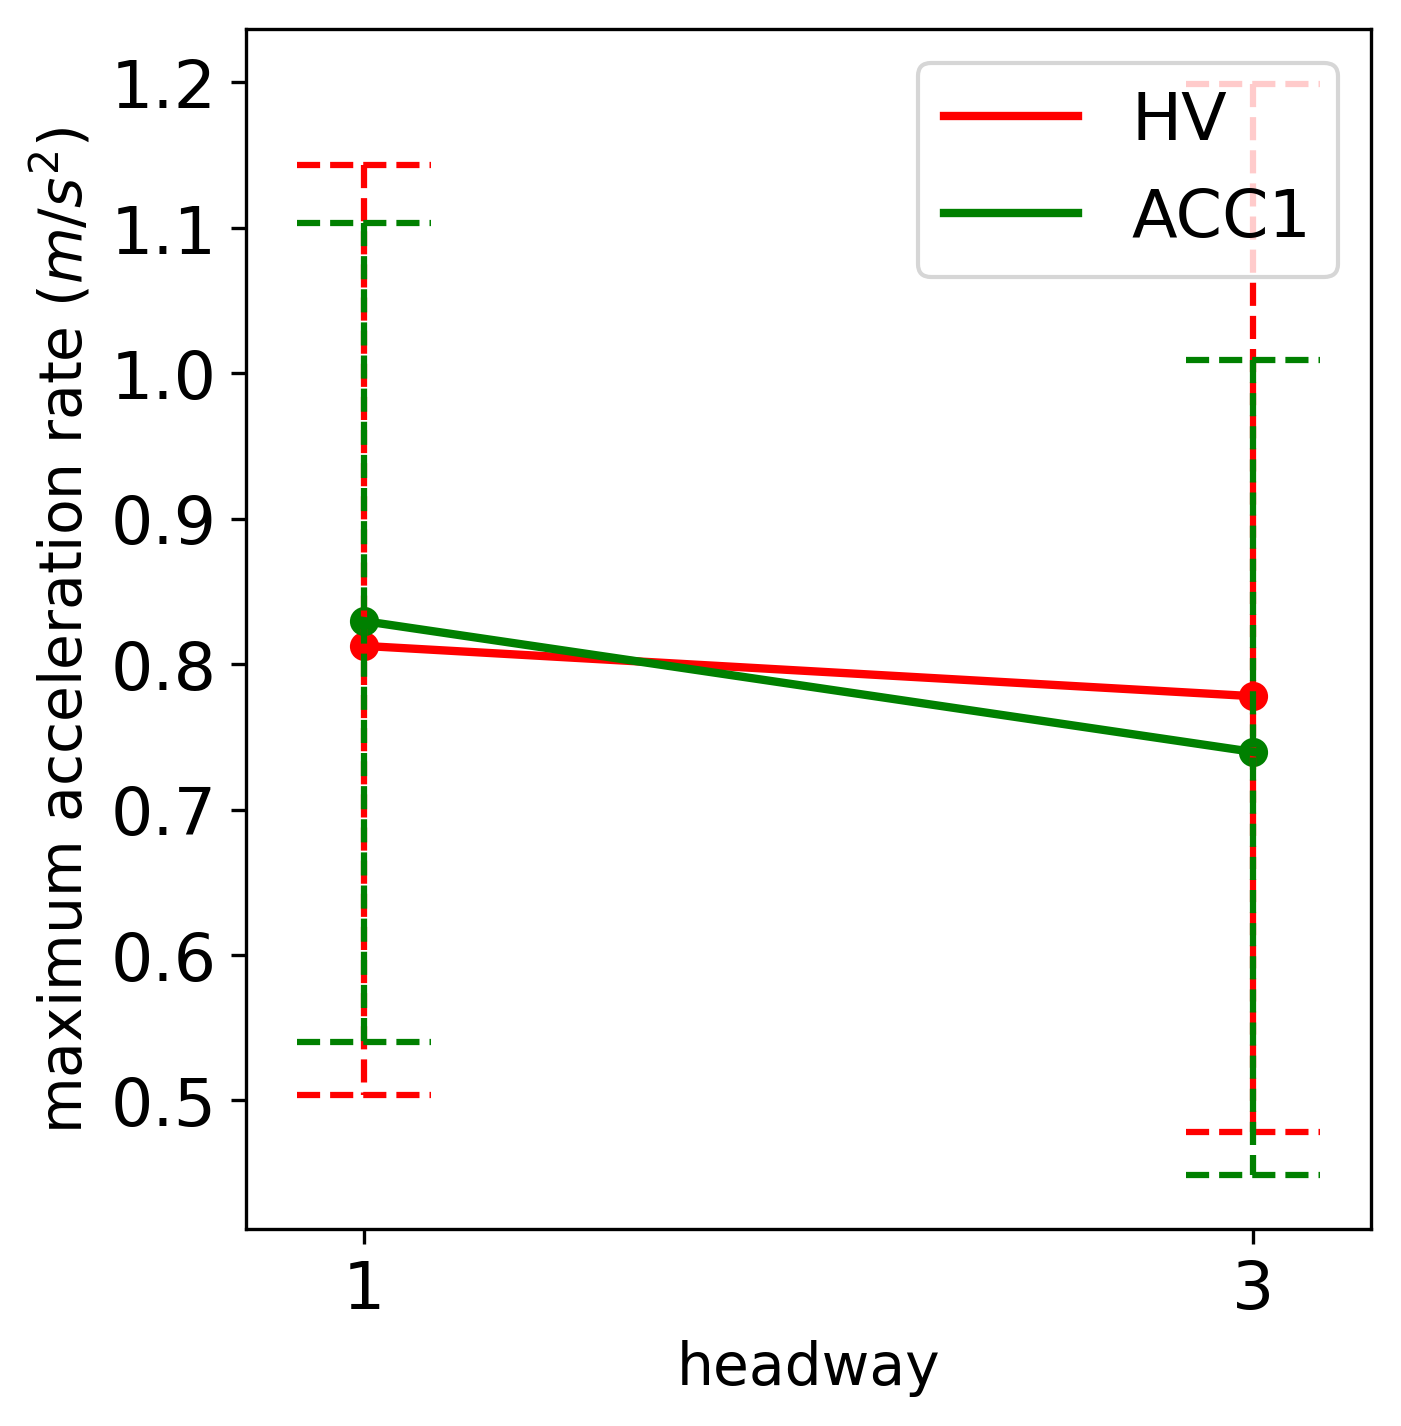

HV 3 0.7 1 0.71 p-value 0.835666551568337


ACC1 3 0.68 1 0.75 p-value 0.15840903182691873


1 ACC1 0.75 HV 0.71 p-value 0.4575987008966911


3 ACC1 0.68 HV 0.7 p-value 0.6254057978016525




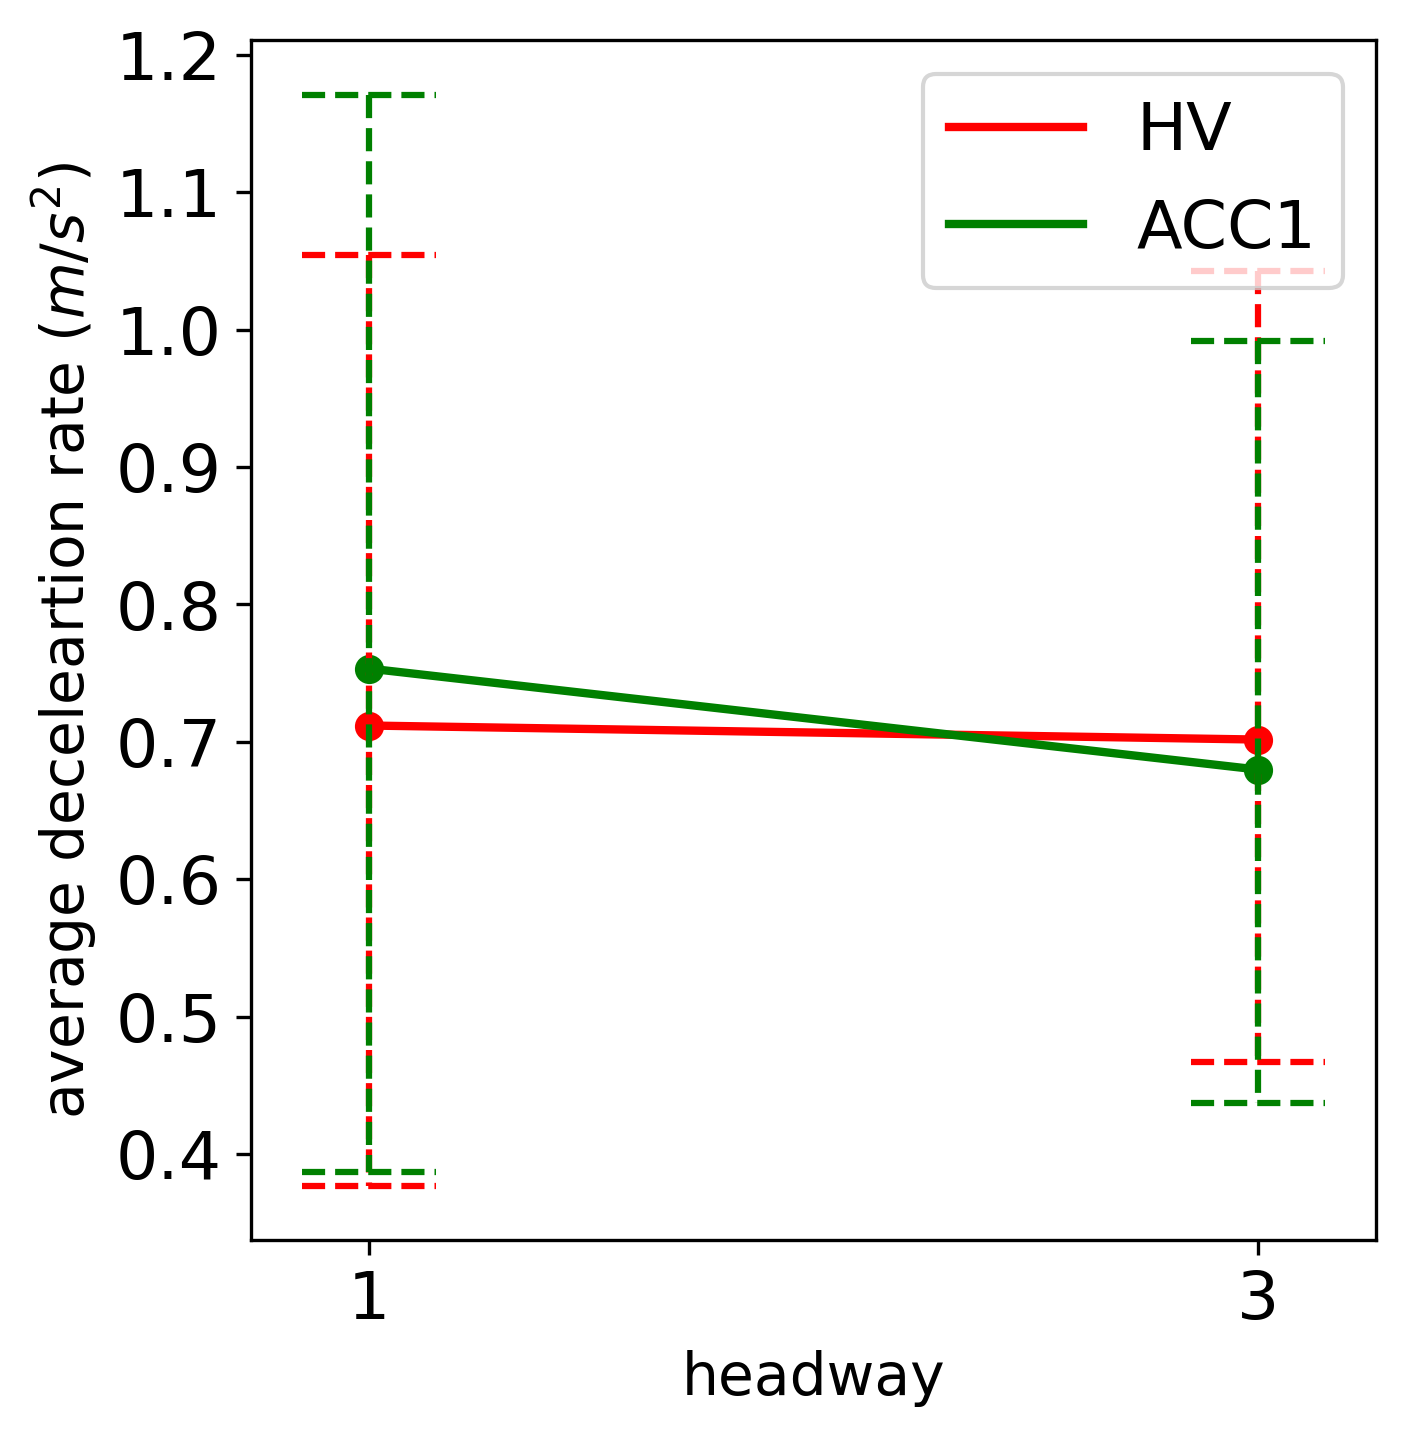

HV 3 0.49 1 0.52 p-value 0.5591192137509925


ACC1 3 0.44 1 0.5 p-value 0.0767236826436024


1 ACC1 0.5 HV 0.52 p-value 0.6012116996471142


3 ACC1 0.44 HV 0.49 p-value 0.14040272202799306




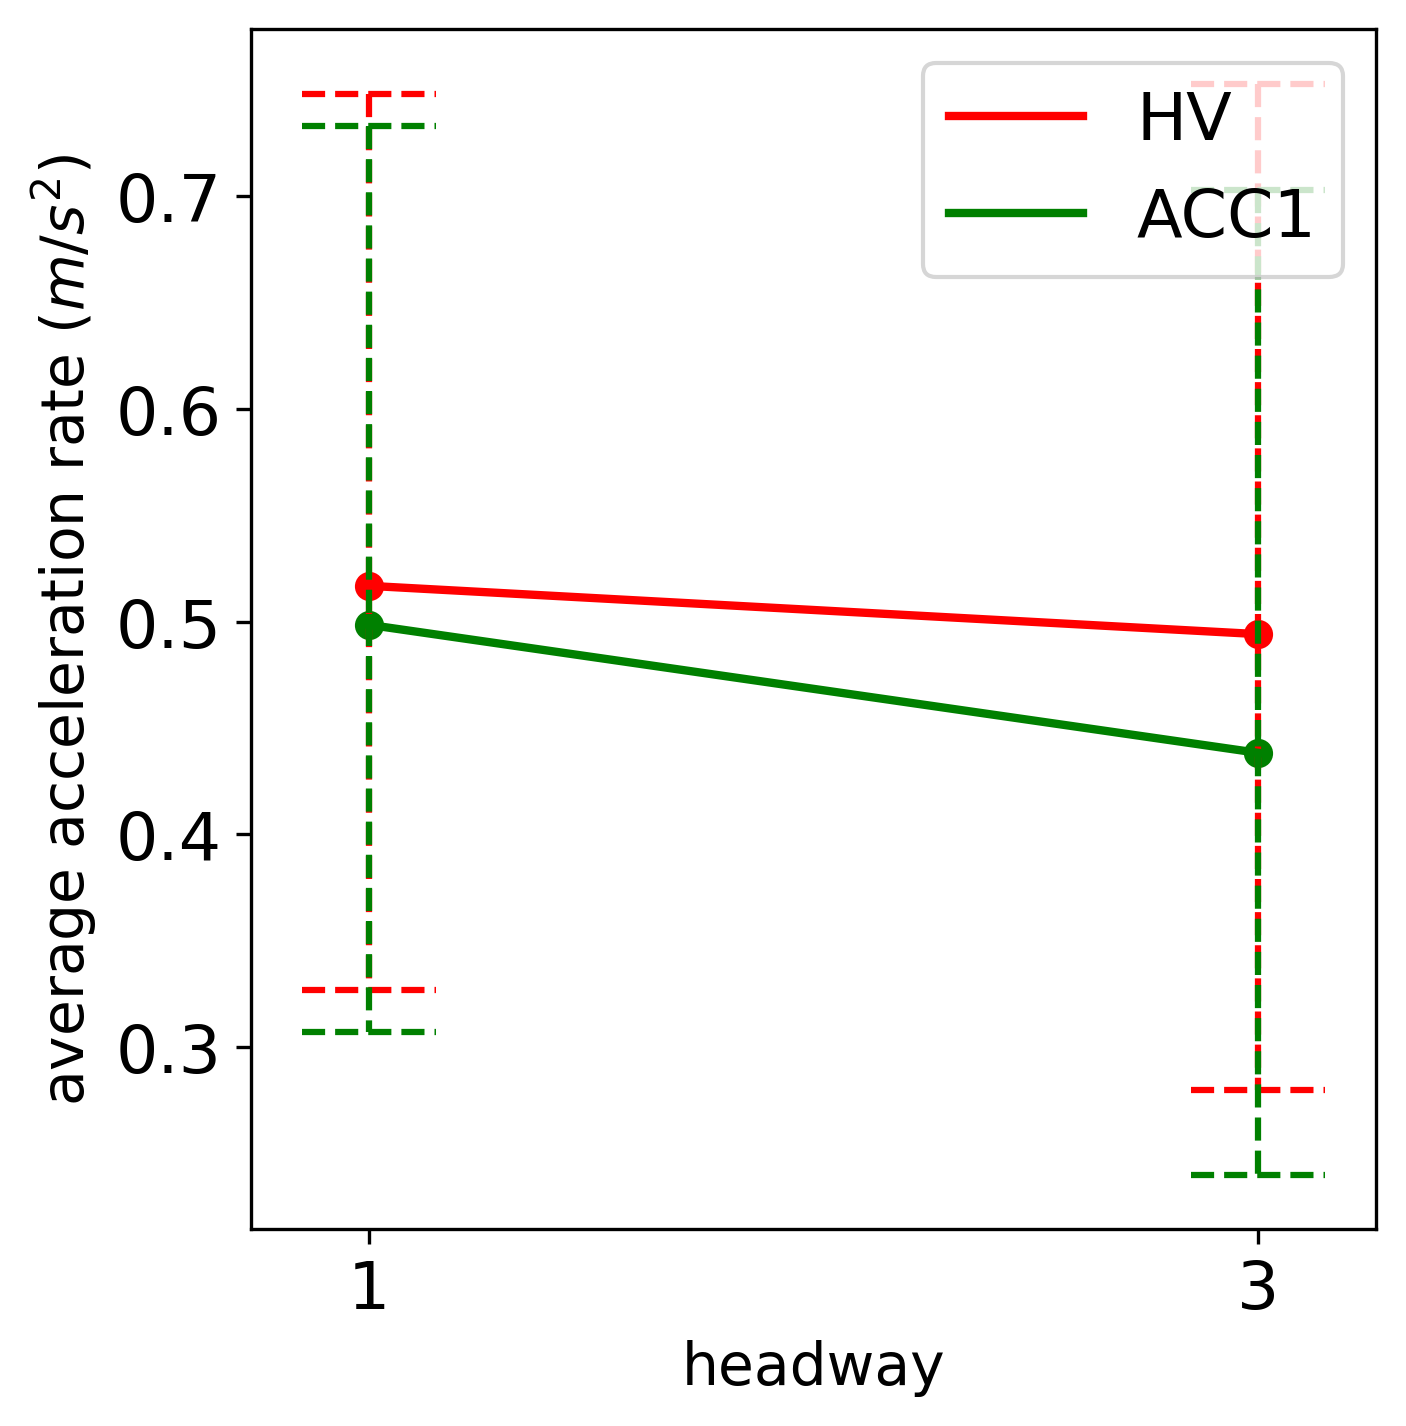

In [23]:
#3.3 deceleration & acceleration rate - headway
oscillation_features_copy = oscillation_features.copy()
for i in range(len(oscillation_features_copy)):
    oscillation_features_copy[i] = oscillation_features_copy[i] + oscillation_features_copy[i][6][0][:2]\
                                    + oscillation_features_copy[i][6][2][:2] \
                                    + oscillation_features_copy[i][6][1][:2] \
                                    + oscillation_features_copy[i][6][3][:2]

impact_factor_column = 8
impact_factor_group_label = ['1', '3']
x_label = 'headway'

feature_column_group = [15, 16]
feature_column_group_label = ['HV', 'ACC1']
y_label = 'maximum deceleartion rate ($m$/$s^2$)'
bar_plot_inverse(oscillation_features_copy, impact_factor_column, feature_column_group,impact_factor_group_label, feature_column_group_label, 
         x_label, y_label, bar=True)

feature_column_group = [17, 18]
feature_column_group_label = ['HV', 'ACC1']
y_label = 'maximum acceleration rate ($m$/$s^2$)'
bar_plot_inverse(oscillation_features_copy, impact_factor_column, feature_column_group,impact_factor_group_label, feature_column_group_label, 
         x_label, y_label, bar=True)

feature_column_group = [11, 12]
feature_column_group_label = ['HV', 'ACC1']
y_label = 'average deceleartion rate ($m$/$s^2$)'
bar_plot_inverse(oscillation_features_copy, impact_factor_column, feature_column_group,impact_factor_group_label, feature_column_group_label, 
         x_label, y_label, bar=True)

feature_column_group = [13, 14]
feature_column_group_label = ['HV', 'ACC1']
y_label = 'average acceleration rate ($m$/$s^2$)'
bar_plot_inverse(oscillation_features_copy, impact_factor_column, feature_column_group,impact_factor_group_label, feature_column_group_label, 
         x_label, y_label, bar=True)

HV mild 0.82 strong 1.27 p-value 1.3800067805087904e-13


ACC1 mild 0.82 strong 1.37 p-value 8.267244175053078e-16


strong ACC1 1.37 HV 1.27 p-value 0.1579073305717984


mild ACC1 0.82 HV 0.82 p-value 0.861188458157129




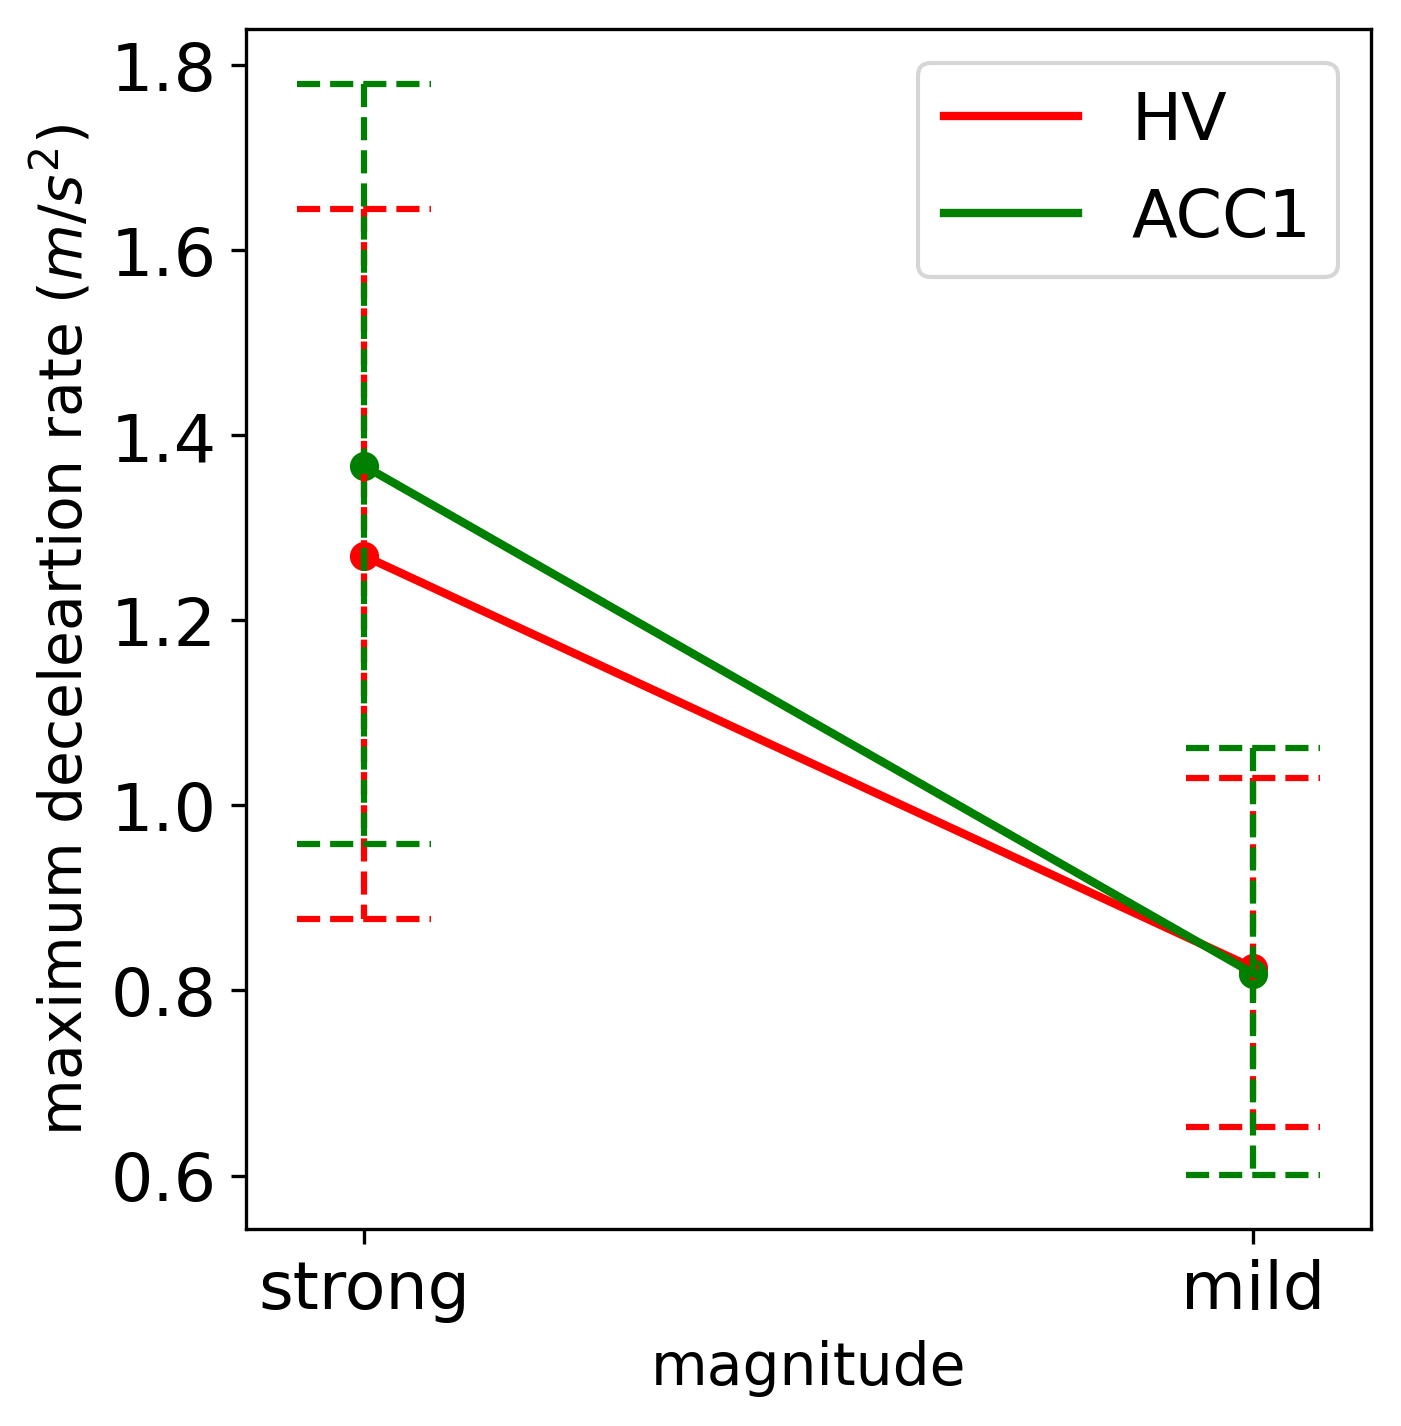

HV mild 0.66 strong 0.93 p-value 2.7289840456117753e-07


ACC1 mild 0.65 strong 0.92 p-value 1.0604337507618195e-11


strong ACC1 0.92 HV 0.93 p-value 0.8743102368042225


mild ACC1 0.65 HV 0.66 p-value 0.6767535521957257




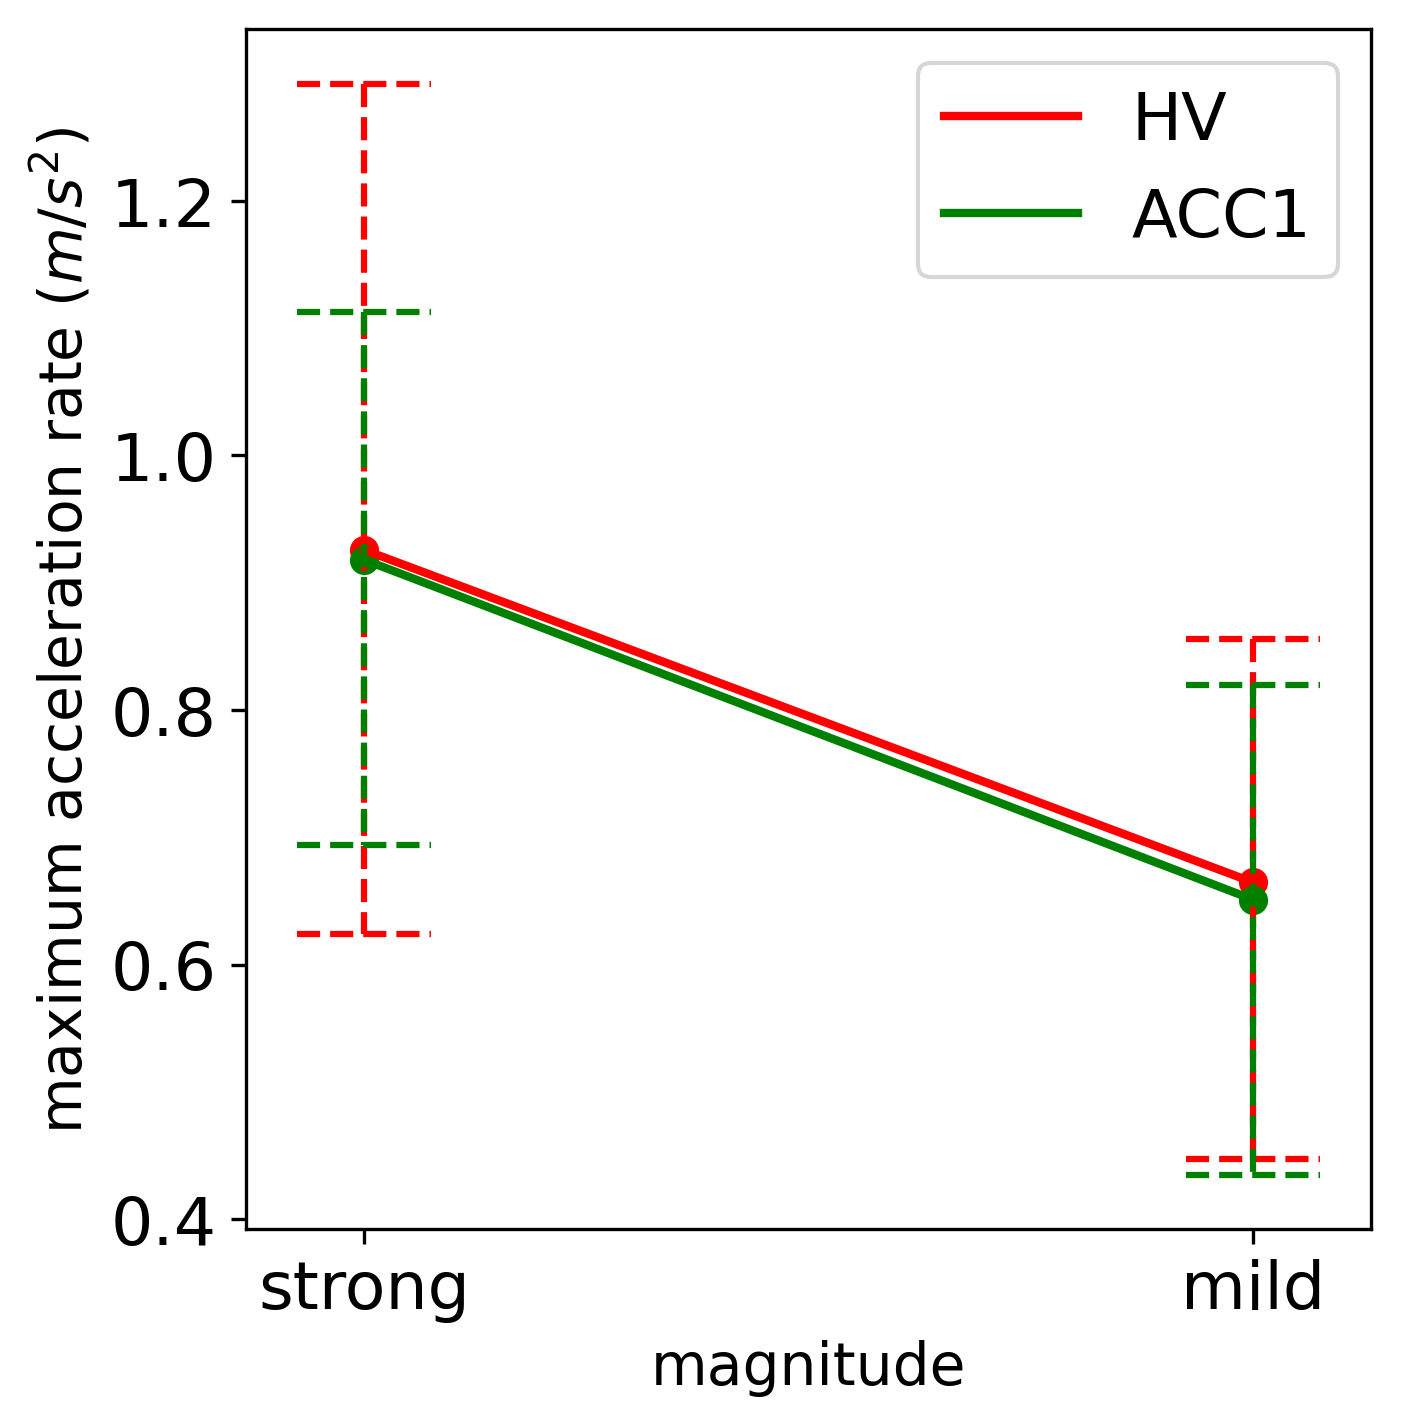

HV mild 0.57 strong 0.85 p-value 4.075610422124745e-10


ACC1 mild 0.56 strong 0.87 p-value 1.47176231502888e-11


strong ACC1 0.87 HV 0.85 p-value 0.5569525776380964


mild ACC1 0.56 HV 0.57 p-value 0.7865289076329438




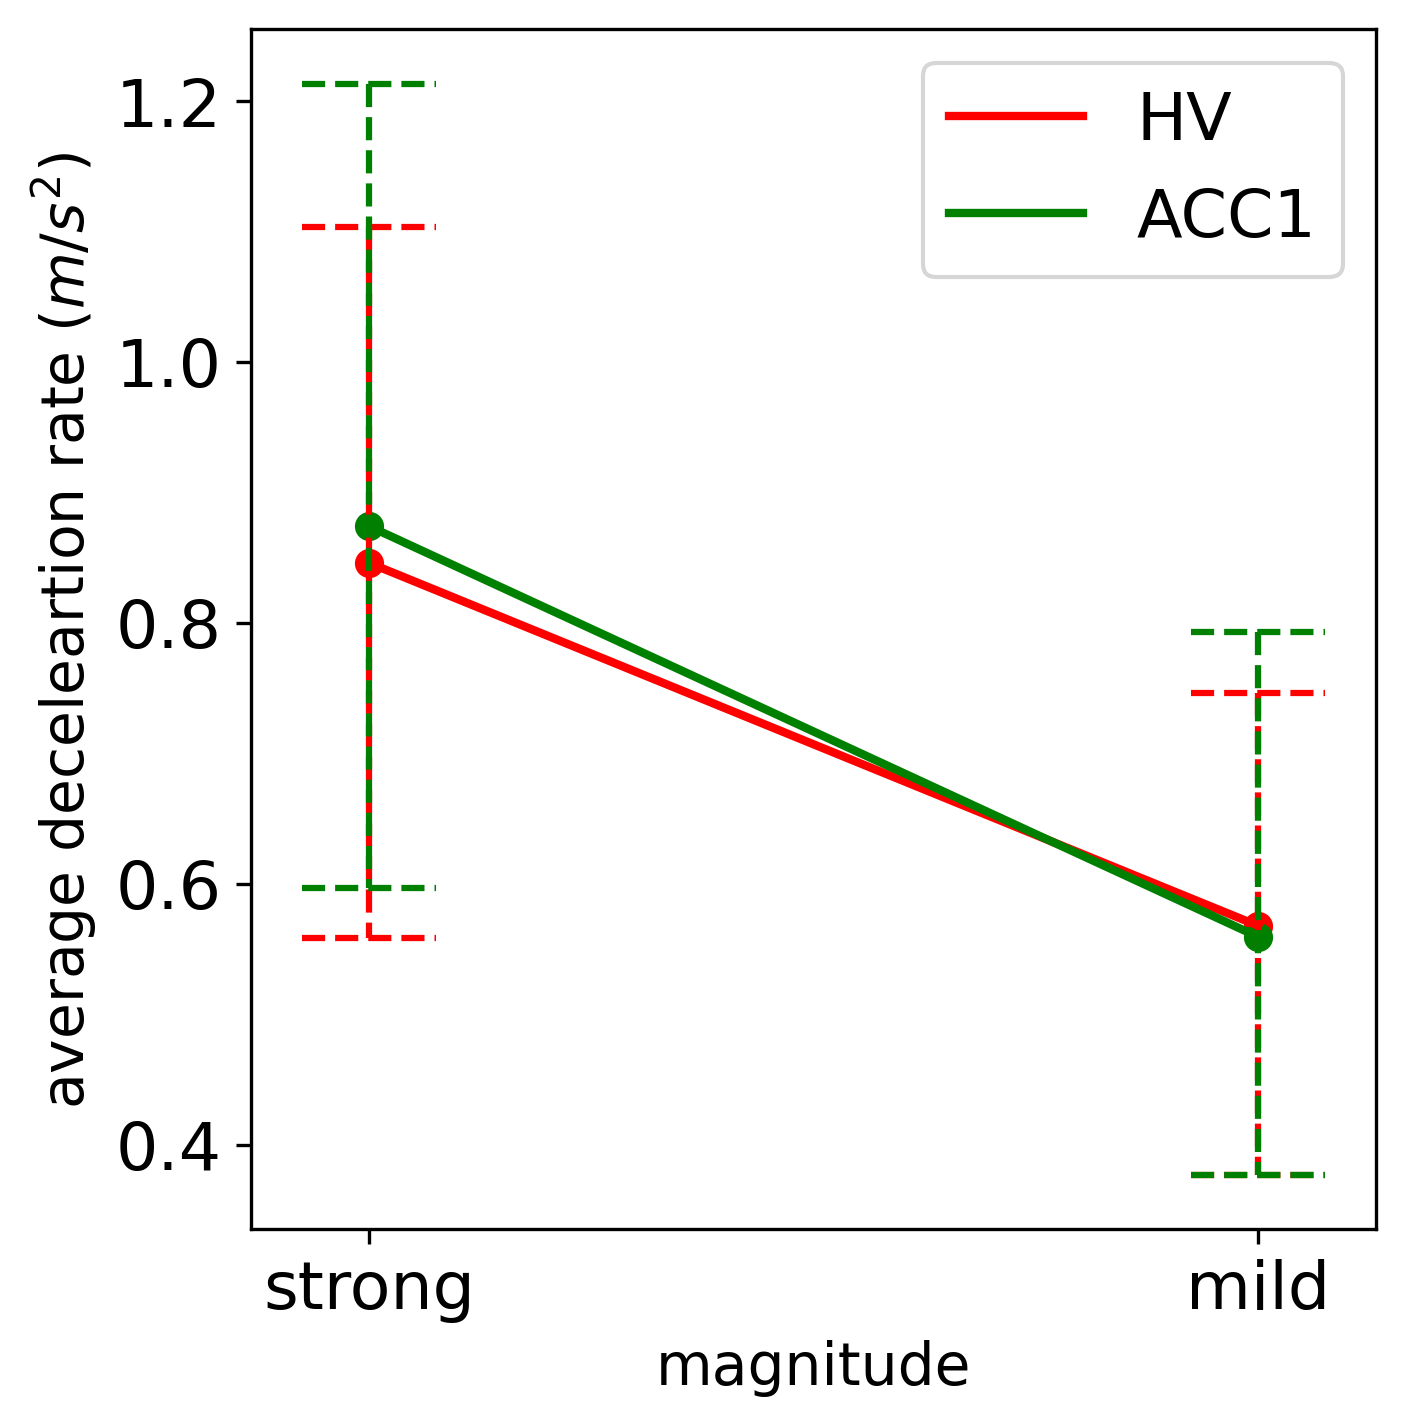

HV mild 0.43 strong 0.58 p-value 0.00010295195302493535


ACC1 mild 0.38 strong 0.56 p-value 1.6920908030520602e-08


strong ACC1 0.56 HV 0.58 p-value 0.5896796446322095


mild ACC1 0.38 HV 0.43 p-value 0.040131420772606036




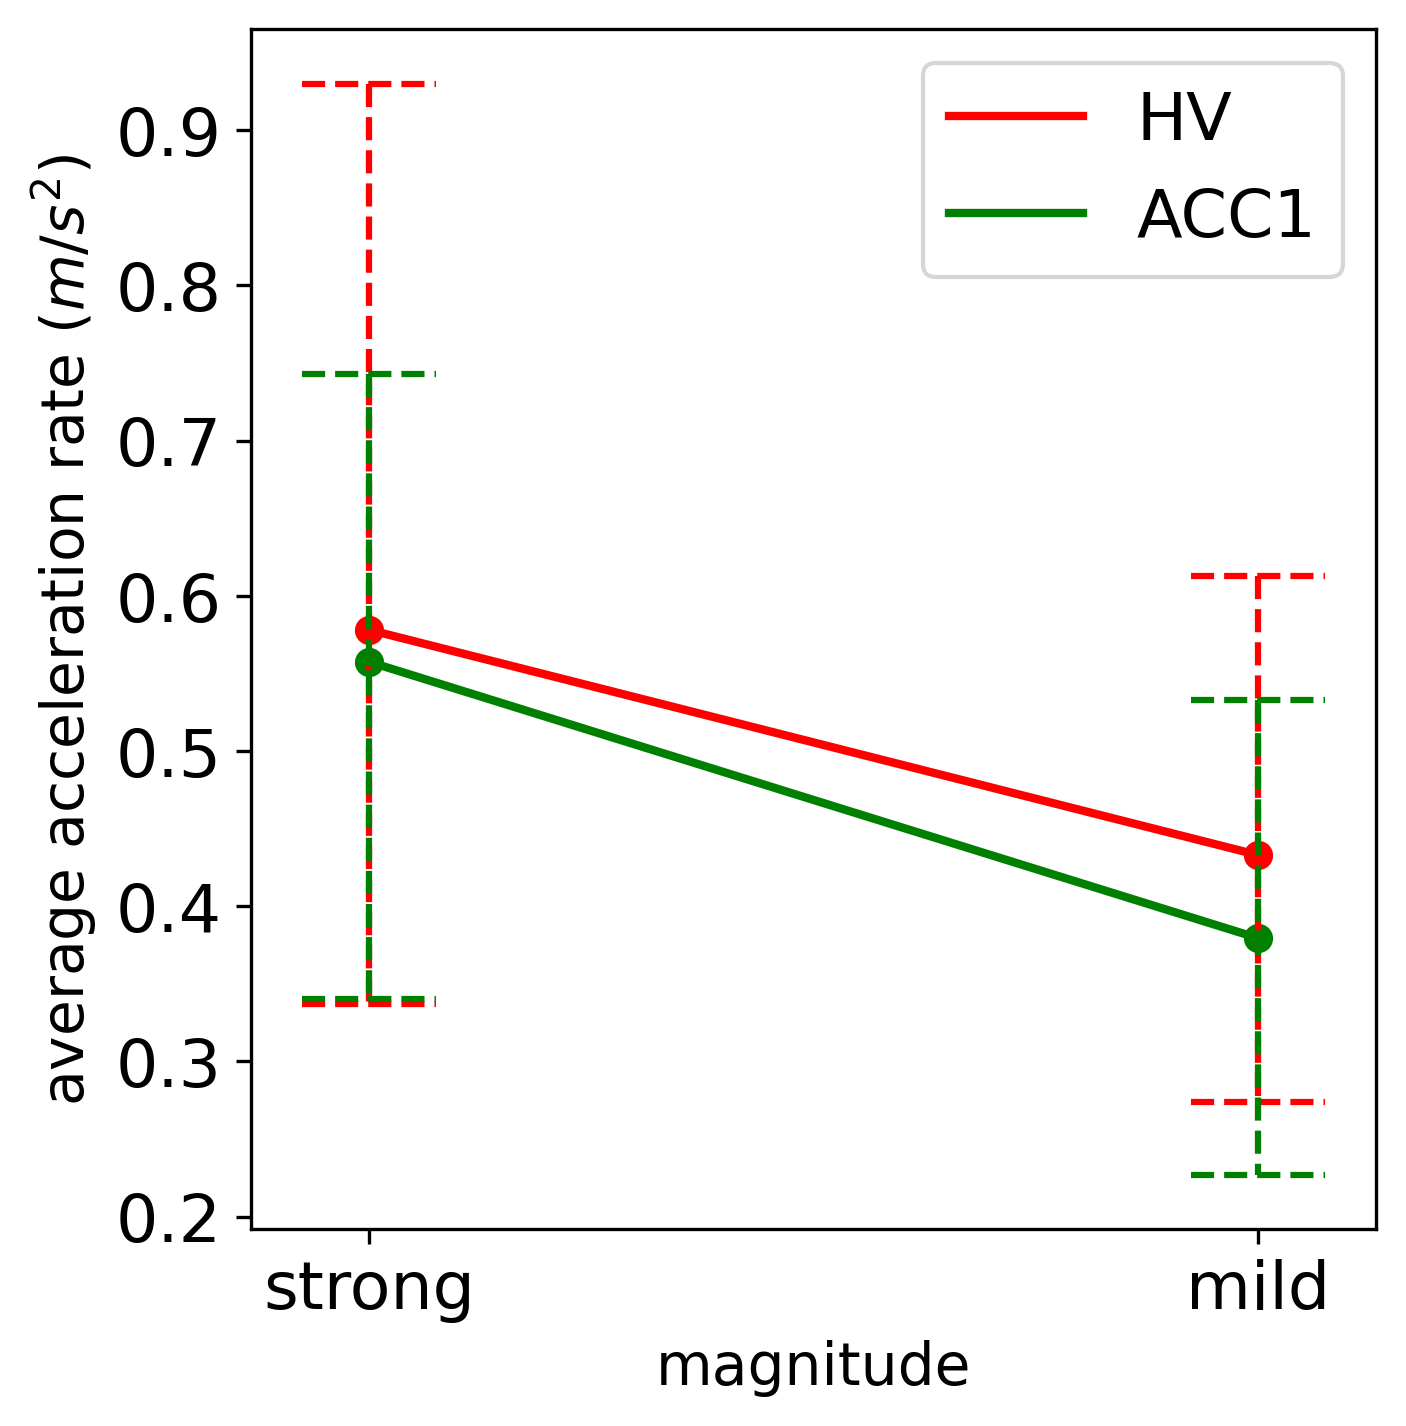

In [24]:
#3.4 deceleration & acceleration rate - magnitude
oscillation_features_copy = oscillation_features.copy()
for i in range(len(oscillation_features_copy)):
    oscillation_features_copy[i] = oscillation_features_copy[i] + oscillation_features_copy[i][6][0][:2]\
                                    + oscillation_features_copy[i][6][2][:2] \
                                    + oscillation_features_copy[i][6][1][:2] \
                                    + oscillation_features_copy[i][6][3][:2]

impact_factor_column = 9
impact_factor_group_label = ['strong', 'mild']
x_label = 'magnitude'

feature_column_group = [15, 16]
feature_column_group_label = ['HV', 'ACC1']
y_label = 'maximum deceleartion rate ($m$/$s^2$)'
bar_plot_inverse(oscillation_features_copy, impact_factor_column, feature_column_group,impact_factor_group_label, feature_column_group_label, 
         x_label, y_label, bar=True)

feature_column_group = [17, 18]
feature_column_group_label = ['HV', 'ACC1']
y_label = 'maximum acceleration rate ($m$/$s^2$)'
bar_plot_inverse(oscillation_features_copy, impact_factor_column, feature_column_group,impact_factor_group_label, feature_column_group_label, 
         x_label, y_label, bar=True)

feature_column_group = [11, 12]
feature_column_group_label = ['HV', 'ACC1']
y_label = 'average deceleartion rate ($m$/$s^2$)'
bar_plot_inverse(oscillation_features_copy, impact_factor_column, feature_column_group,impact_factor_group_label, feature_column_group_label, 
         x_label, y_label, bar=True)

feature_column_group = [13, 14]
feature_column_group_label = ['HV', 'ACC1']
y_label = 'average acceleration rate ($m$/$s^2$)'
bar_plot_inverse(oscillation_features_copy, impact_factor_column, feature_column_group,impact_factor_group_label, feature_column_group_label, 
         x_label, y_label, bar=True)

HV mild 0.86 strong 1.51 p-value 1.2378703567272665e-32


ACC1 mild 0.88 strong 1.6 p-value 1.2523839120502237e-26


strong ACC1 1.6 HV 1.51 p-value 0.07481006078090173


mild ACC1 0.88 HV 0.86 p-value 0.41473673957047963




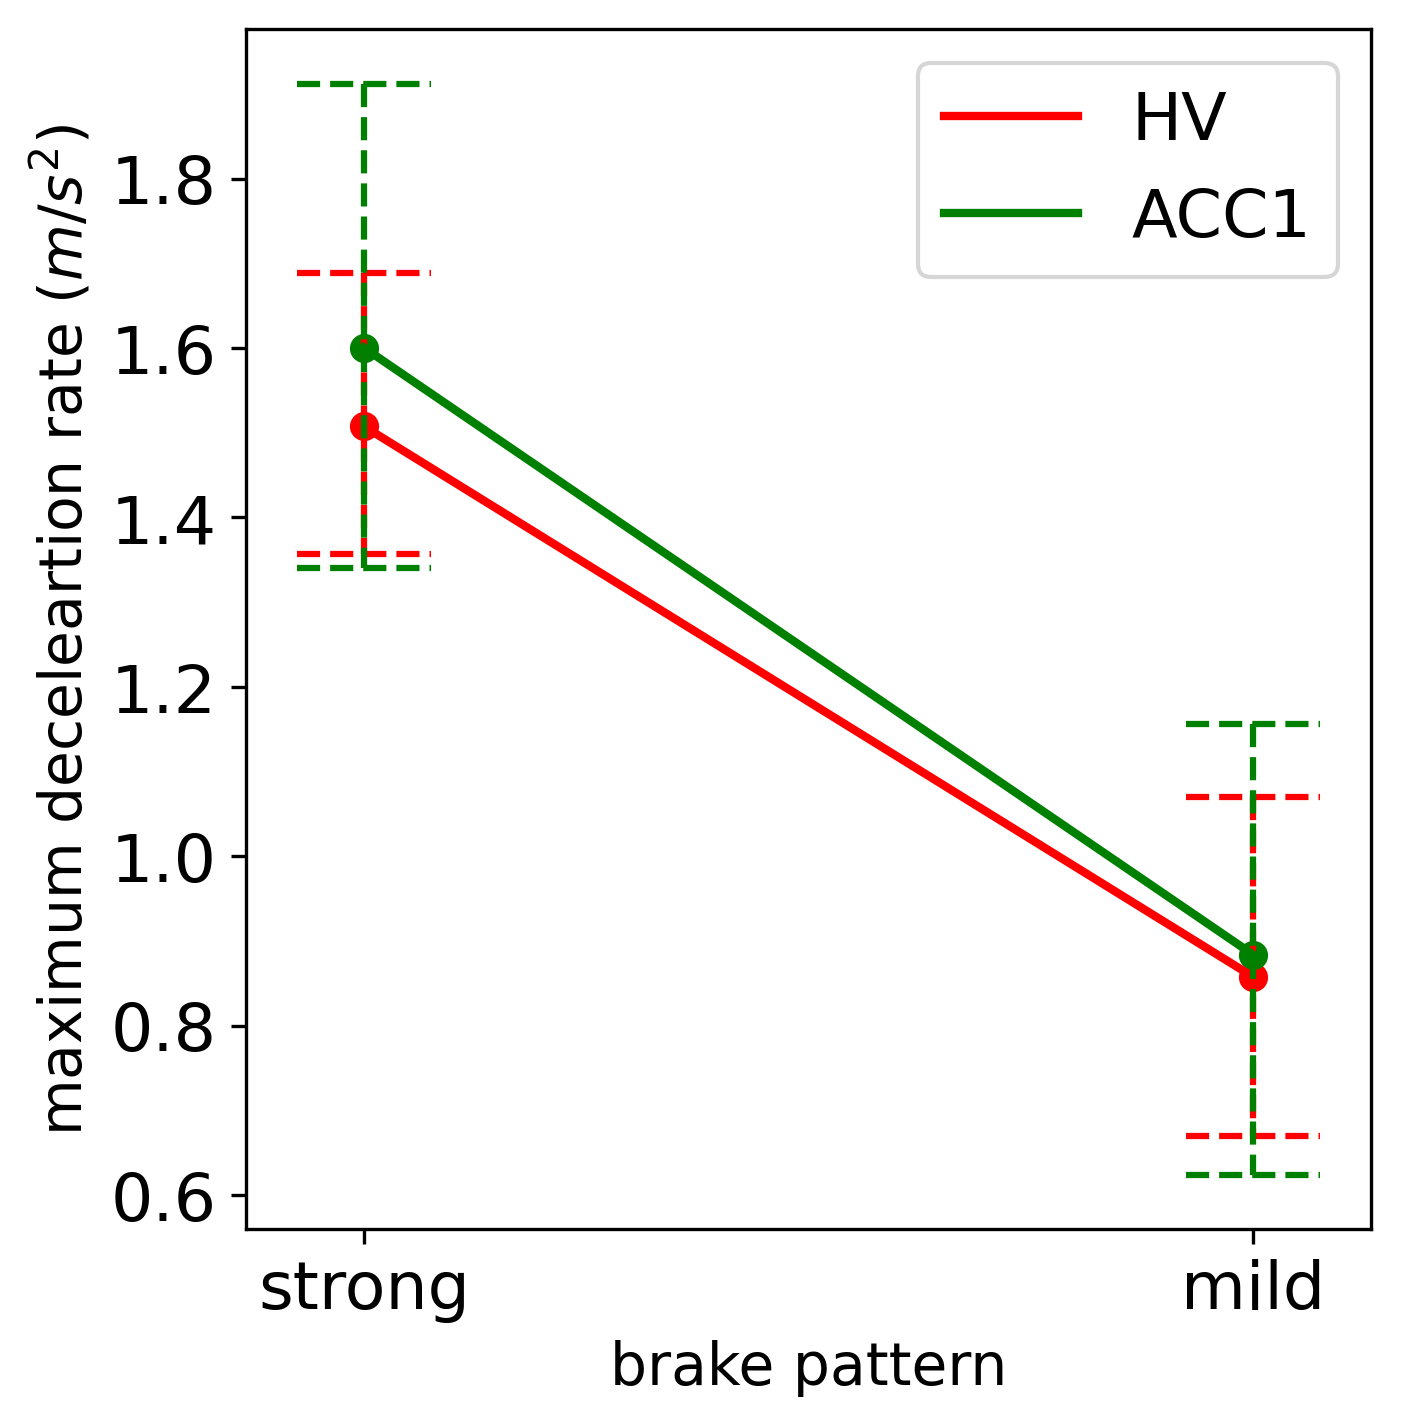

HV mild 0.66 strong 1.11 p-value 1.359120597803661e-20


ACC1 mild 0.69 strong 1.02 p-value 2.109817805187318e-15


strong ACC1 1.02 HV 1.11 p-value 0.04341681793838682


mild ACC1 0.69 HV 0.66 p-value 0.35916125862745185




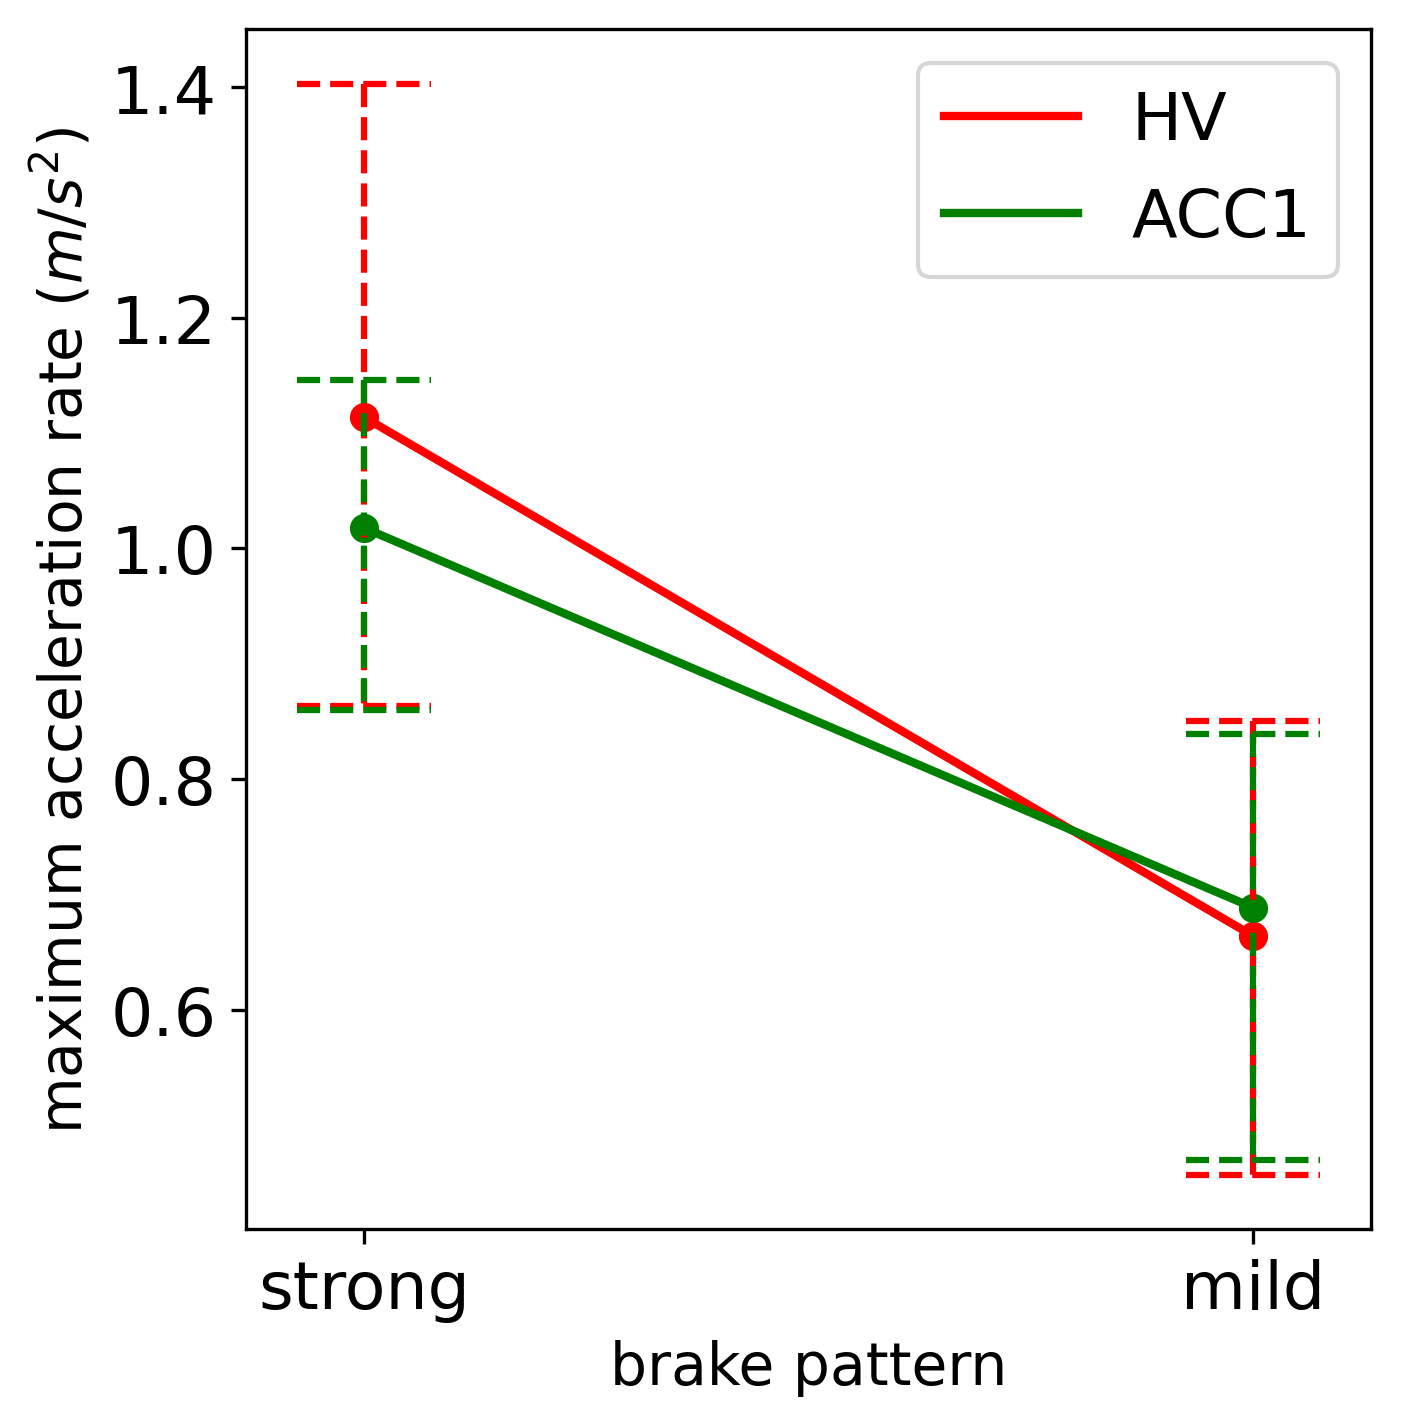

HV mild 0.58 strong 1.01 p-value 5.688316469575915e-25


ACC1 mild 0.59 strong 1.02 p-value 1.436198504500051e-19


strong ACC1 1.02 HV 1.01 p-value 0.8892708178381499


mild ACC1 0.59 HV 0.58 p-value 0.6581561694728159




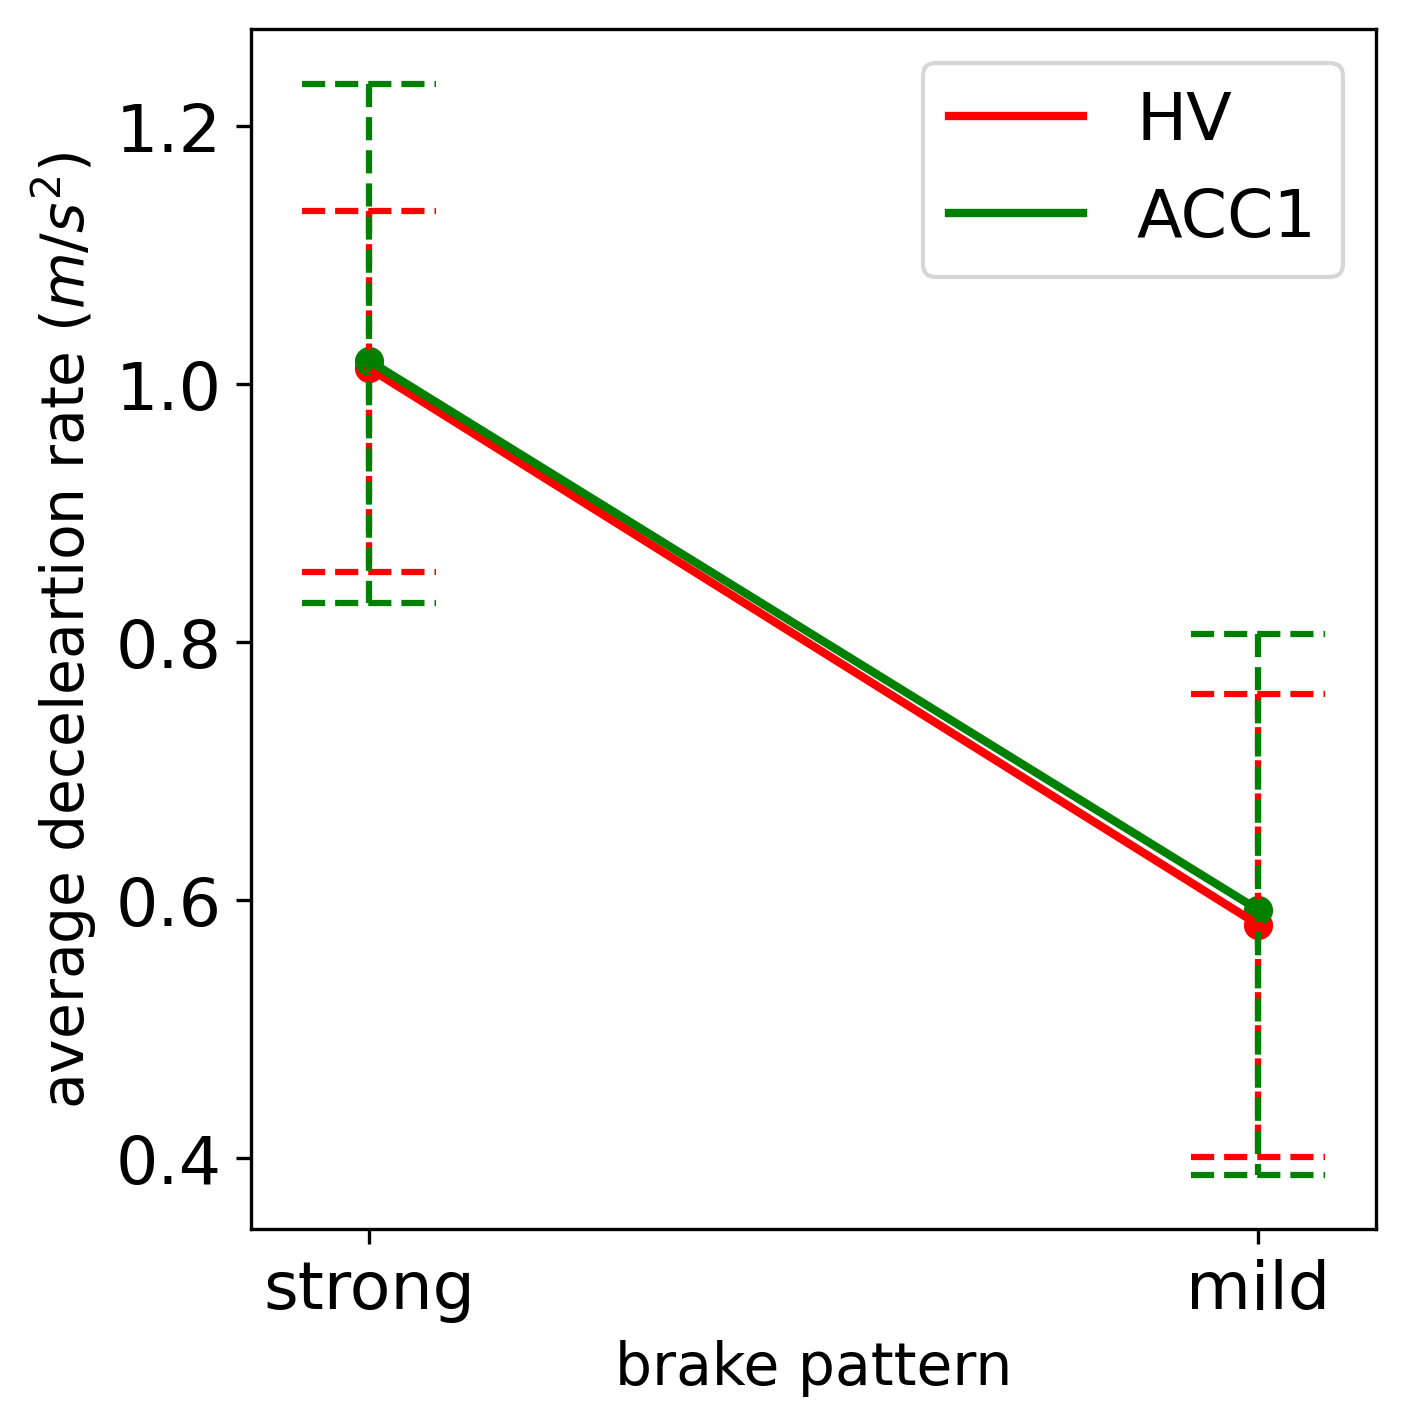

HV mild 0.43 strong 0.7 p-value 3.500303372079558e-13


ACC1 mild 0.4 strong 0.63 p-value 4.215920592464122e-11


strong ACC1 0.63 HV 0.7 p-value 0.10795888239685066


mild ACC1 0.4 HV 0.43 p-value 0.2950949200358829




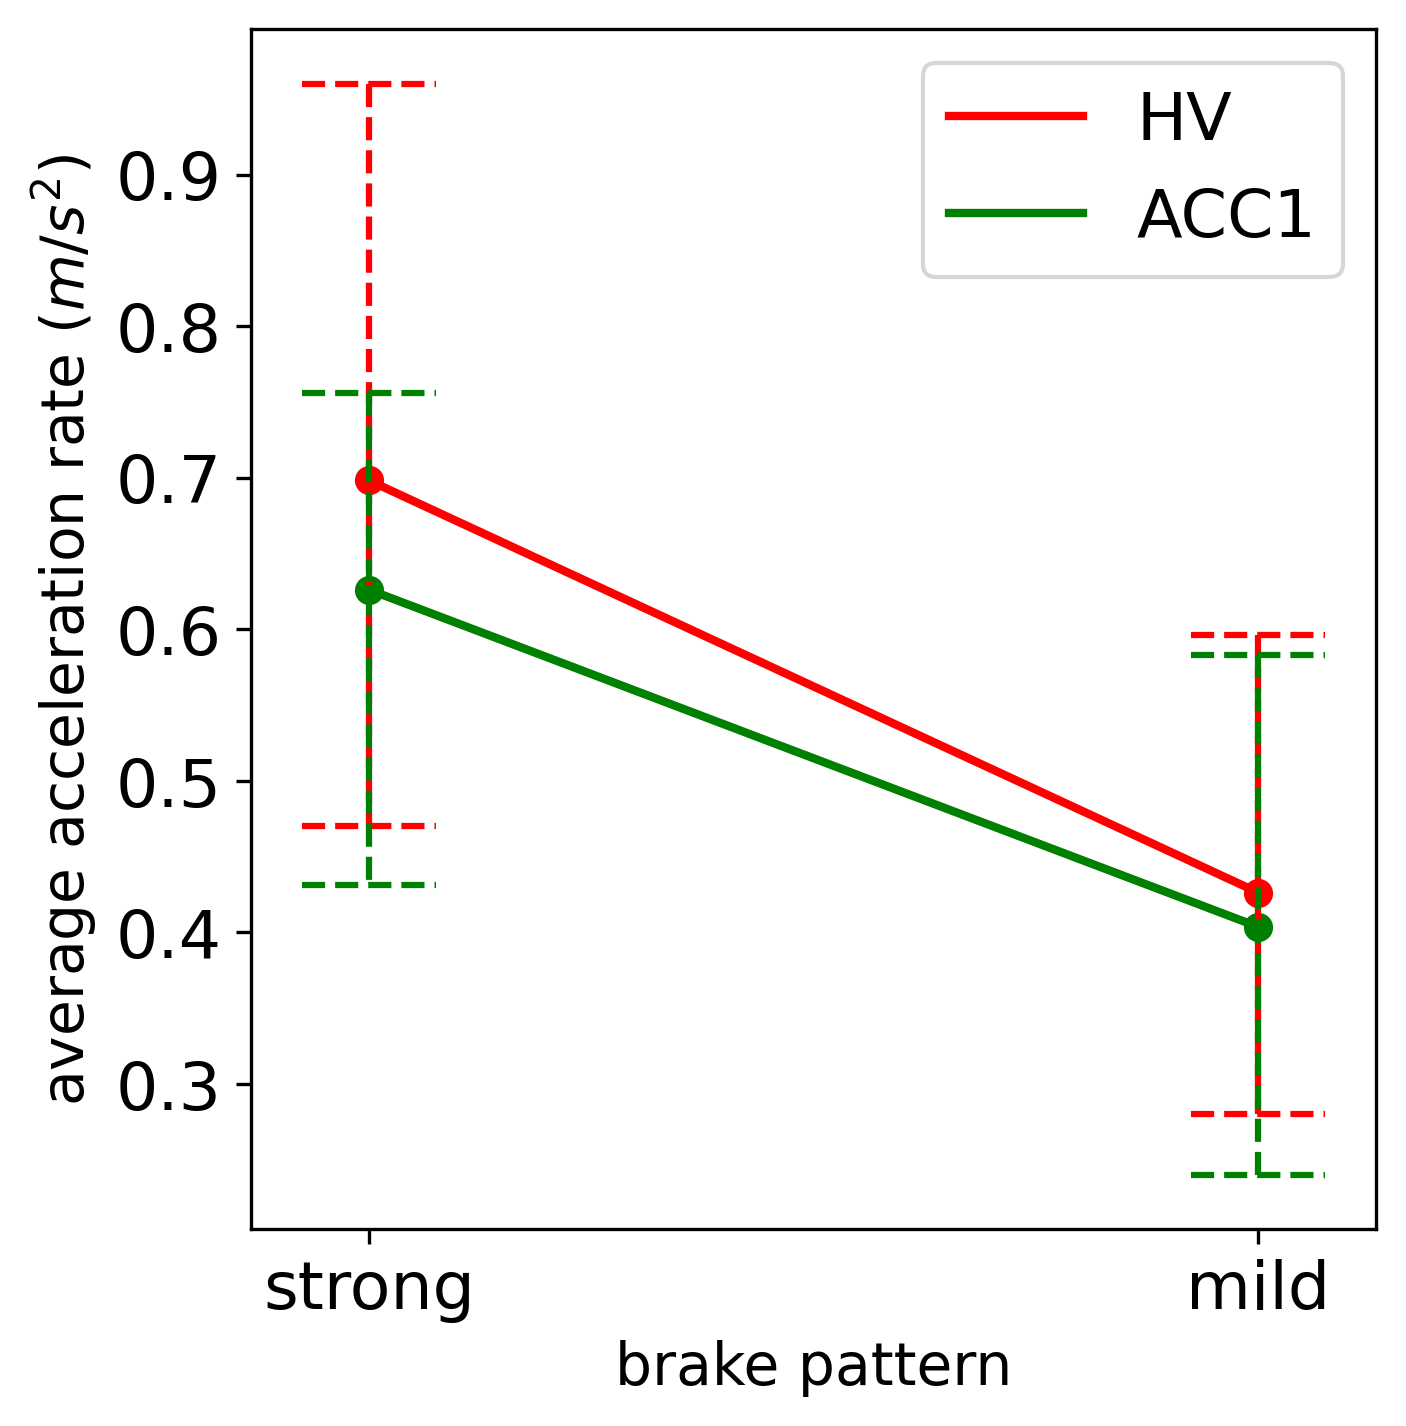

In [25]:
#3.5 deceleration & acceleration rate - brake pattern
oscillation_features_copy = oscillation_features.copy()
for i in range(len(oscillation_features_copy)):
    oscillation_features_copy[i] = oscillation_features_copy[i] + oscillation_features_copy[i][6][0][:2]\
                                    + oscillation_features_copy[i][6][2][:2] \
                                    + oscillation_features_copy[i][6][1][:2] \
                                    + oscillation_features_copy[i][6][3][:2]

impact_factor_column = 10
impact_factor_group_label = ['strong', 'mild']
x_label = 'brake pattern'

feature_column_group = [15, 16]
feature_column_group_label = ['HV', 'ACC1']
y_label = 'maximum deceleartion rate ($m$/$s^2$)'
bar_plot_inverse(oscillation_features_copy, impact_factor_column, feature_column_group,impact_factor_group_label, feature_column_group_label, 
         x_label, y_label, bar=True)

feature_column_group = [17, 18]
feature_column_group_label = ['HV', 'ACC1']
y_label = 'maximum acceleration rate ($m$/$s^2$)'
bar_plot_inverse(oscillation_features_copy, impact_factor_column, feature_column_group,impact_factor_group_label, feature_column_group_label, 
         x_label, y_label, bar=True)

feature_column_group = [11, 12]
feature_column_group_label = ['HV', 'ACC1']
y_label = 'average deceleartion rate ($m$/$s^2$)'
bar_plot_inverse(oscillation_features_copy, impact_factor_column, feature_column_group,impact_factor_group_label, feature_column_group_label, 
         x_label, y_label, bar=True)

feature_column_group = [13, 14]
feature_column_group_label = ['HV', 'ACC1']
y_label = 'average acceleration rate ($m$/$s^2$)'
bar_plot_inverse(oscillation_features_copy, impact_factor_column, feature_column_group,impact_factor_group_label, feature_column_group_label, 
         x_label, y_label, bar=True)

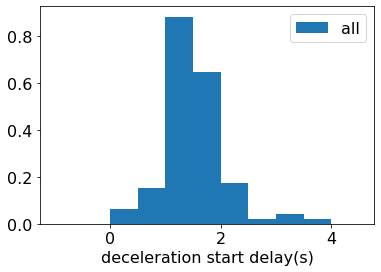

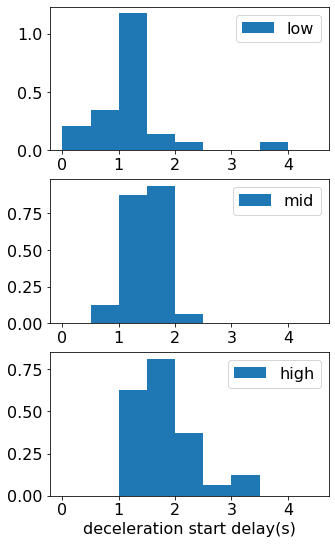

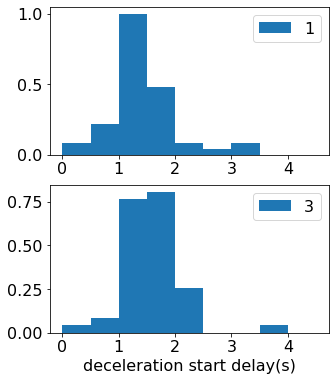

In [45]:
#initial delay distribution
oscillation_features_copy = oscillation_features.copy()
for i in range(len(oscillation_features_copy)):
    oscillation_features_copy[i] = oscillation_features_copy[i] + oscillation_features_copy[i][5][0]

#initial delay
feature_column = 11
Deceleartion_start = []
for d in oscillation_features_copy:
    Deceleartion_start.append(d[feature_column])
#     if d[feature_column]<.5:
#         print(d[2], d[feature_column])
    
plt.hist(Deceleartion_start,bins=np.arange(-1,5,.5),density=True,label='all')
plt.legend()
plt.xlabel('deceleration start delay(s)')
    
    
impact_factor_column = 3
impact_factor_group_label = ['low', 'mid', 'high']
Deceleartion_start_categorized = {}
for l in impact_factor_group_label:
    Deceleartion_start_categorized[l] = []
for d in oscillation_features_copy:
    Deceleartion_start_categorized[d[impact_factor_column]].append(d[feature_column])
plt.figure(figsize=(5, 9))
plt.subplot(311)
plt.hist(Deceleartion_start_categorized['low'],alpha=1,label='low',bins=np.arange(0,5,.5),density=True)
plt.legend()
plt.xticks(np.arange(0,5,1))
plt.subplot(312)
plt.hist(Deceleartion_start_categorized['mid'],alpha=1,label='mid',bins=np.arange(0,5,.5),density=True)
plt.legend()
plt.xticks(np.arange(0,5,1))
plt.subplot(313)
plt.hist(Deceleartion_start_categorized['high'],alpha=1,label='high',bins=np.arange(0,5,.5),density=True)
plt.legend()
plt.xticks(np.arange(0,5,1))
plt.xlabel('deceleration start delay(s)')

impact_factor_column = 8
impact_factor_group_label = ['1', '3']
Deceleartion_start_categorized = {}
for l in impact_factor_group_label:
    Deceleartion_start_categorized[l] = []
for d in oscillation_features_copy:
    Deceleartion_start_categorized[d[impact_factor_column]].append(d[feature_column])
plt.figure(figsize=(5, 6))
plt.subplot(211)
plt.hist(Deceleartion_start_categorized['1'],alpha=1,label='1',bins=np.arange(0,5,.5),density=True)
plt.legend()
plt.xticks(np.arange(0,5,1))
plt.subplot(212)
plt.hist(Deceleartion_start_categorized['3'],alpha=1,label='3',bins=np.arange(0,5,.5),density=True)
plt.legend()
plt.xticks(np.arange(0,5,1))
plt.xlabel('deceleration start delay(s)')


low 1 0.97 std 0.36 low 3 1.39 std 0.69 p-value 0.058
mid 1 1.36 std 0.24 mid 3 1.46 std 0.33 p-value 0.321
high 1 1.79 std 0.61 high 3 1.78 std 0.22 p-value 0.941


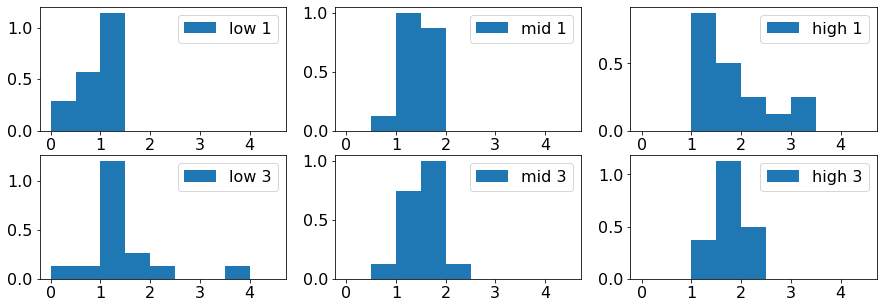

In [27]:
#initial delay distribution - more details
feature_column = 11
impact_factor_column = 3
impact_factor_group_label = ['low', 'mid', 'high']
impact_factor_column2 = 8
impact_factor_group_label2 = ['1', '3']
Deceleartion_start_categorized = {}
for l in impact_factor_group_label:
    Deceleartion_start_categorized[l] = {}
    for l2 in impact_factor_group_label2:
        Deceleartion_start_categorized[l][l2] = []
for d in comprehensive_oscillation_features_with_delay:
    Deceleartion_start_categorized[d[impact_factor_column]][d[impact_factor_column2]].append(d[feature_column])

print('low 1',round(np.mean(Deceleartion_start_categorized['low']['1']), 2),
      'std',round(np.std(Deceleartion_start_categorized['low']['1']), 2),
      'low 3', round(np.mean(Deceleartion_start_categorized['low']['3']), 2), 
      'std',round(np.std(Deceleartion_start_categorized['low']['3']), 2),
      'p-value', round(stats.ttest_ind(Deceleartion_start_categorized['low']['3'], 
                                       Deceleartion_start_categorized['low']['1'])[1],3))    
print('mid 1',round(np.mean(Deceleartion_start_categorized['mid']['1']), 2), 
      'std',round(np.std(Deceleartion_start_categorized['mid']['1']), 2),
      'mid 3', round(np.mean(Deceleartion_start_categorized['mid']['3']), 2), 
      'std',round(np.std(Deceleartion_start_categorized['mid']['3']), 2),
      'p-value', round(stats.ttest_ind(Deceleartion_start_categorized['mid']['3'], 
                                       Deceleartion_start_categorized['mid']['1'])[1],3))
print('high 1',round(np.mean(Deceleartion_start_categorized['high']['1']), 2), 
      'std',round(np.std(Deceleartion_start_categorized['high']['1']), 2),
      'high 3', round(np.mean(Deceleartion_start_categorized['high']['3']), 2), 
      'std',round(np.std(Deceleartion_start_categorized['high']['3']), 2),
      'p-value', round(stats.ttest_ind(Deceleartion_start_categorized['high']['3'], 
                                       Deceleartion_start_categorized['high']['1'])[1],3))
    
fig, axs = plt.subplots(2, 3, figsize=(15,5))
axs[0, 0].hist(Deceleartion_start_categorized['low']['1'],alpha=1,label='low 1',bins=np.arange(0,5,.5),density=True)
axs[0, 0].legend()
axs[0, 1].hist(Deceleartion_start_categorized['mid']['1'],alpha=1,label='mid 1',bins=np.arange(0,5,.5),density=True)
axs[0, 1].legend()
axs[0, 2].hist(Deceleartion_start_categorized['high']['1'],alpha=1,label='high 1',bins=np.arange(0,5,.5),density=True)
axs[0, 2].legend()
axs[1, 0].hist(Deceleartion_start_categorized['low']['3'],alpha=1,label='low 3',bins=np.arange(0,5,.5),density=True)
axs[1, 0].legend()
axs[1, 1].hist(Deceleartion_start_categorized['mid']['3'],alpha=1,label='mid 3',bins=np.arange(0,5,.5),density=True)
axs[1, 1].legend()
axs[1, 2].hist(Deceleartion_start_categorized['high']['3'],alpha=1,label='high 3',bins=np.arange(0,5,.5),density=True)
axs[1, 2].legend()


1 mid 1.36 low 0.97 p-value 0.0023564229831347415


1 high 1.79 mid 1.36 p-value 0.014674680616800757


3 mid 1.46 low 1.39 p-value 0.7288492942566915


3 high 1.78 mid 1.46 p-value 0.003956855770699213


low 3 1.39 1 0.97 p-value 0.058


mid 3 1.46 1 1.36 p-value 0.321


high 3 1.78 1 1.79 p-value 0.941




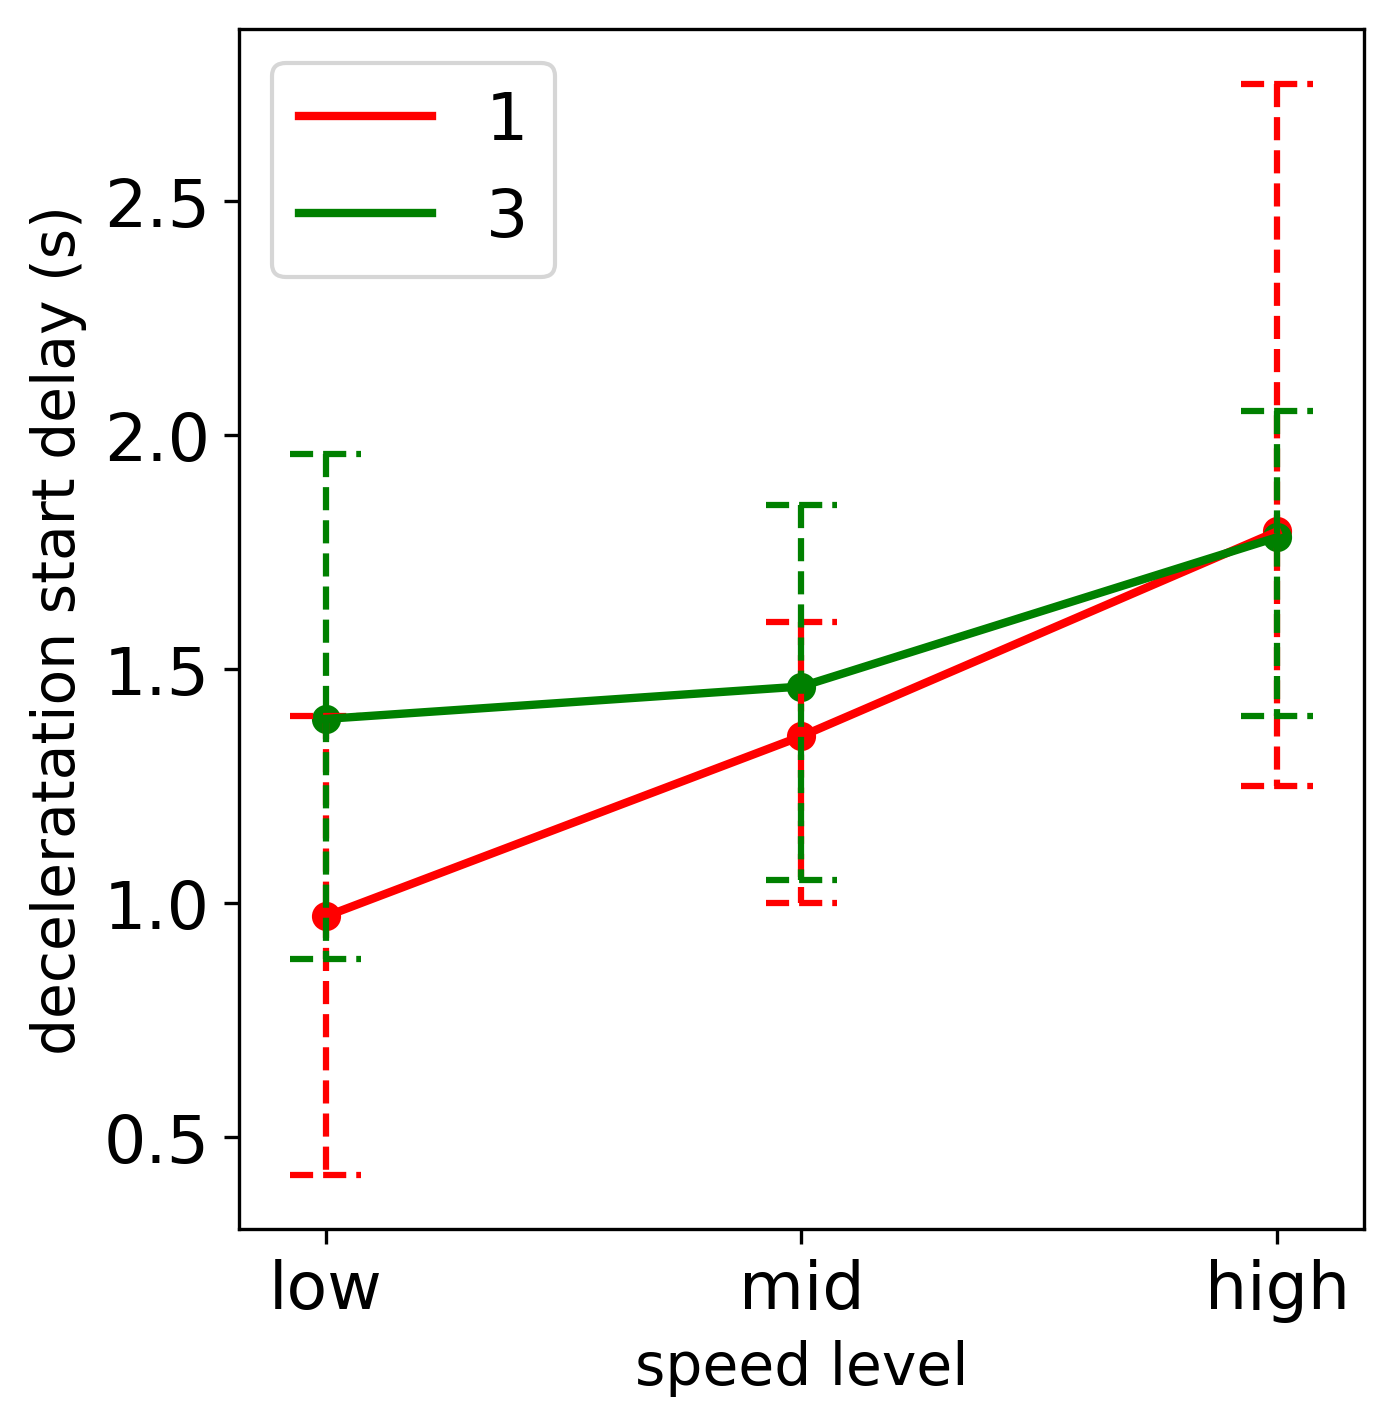

In [24]:
#initial delay bar plot in different scenarios
impact_factor_column2 = 3
impact_factor_group_label2 = ['low', 'mid', 'high']
impact_factor_column = 8
impact_factor_group_label = ['1', '3']
data_group = {}
for l in impact_factor_group_label:
    data_group[l] = {}
    for l2 in impact_factor_group_label2:
        data_group[l][l2] = []
for d in comprehensive_oscillation_features_with_delay:
    data_group[d[impact_factor_column]][d[impact_factor_column2]].append(d[11])

color_group = ['r', 'g', 'b']
fig = plt.figure(figsize=(5, 5), dpi=300)
ax = fig.add_subplot(111)
ax.set_position([0.2, 0.15, 0.75, 0.8])
label_num = 0
overall_mean_value = []
for label in data_group.keys():
    mean_value = []
    data_points_y_group = data_group[label]
    for fl in data_points_y_group.keys():
        data_points_y = data_points_y_group[fl]
        mean_value.append((np.mean(data_points_y),  # 0 y-mean location
                           np.percentile(data_points_y, 90),  # 1 y-90th location
                           np.percentile(data_points_y, 10),  # 2 y-10th location
                           np.std(data_points_y),  # 3 y std
                           label,  # 4 label
                           data_points_y,  # 5 y samples
                           fl))  # 6 feature label

    for i in range(len(mean_value)):
        if i >= 1:
            print(mean_value[i][4], mean_value[i][6], round(mean_value[i][0], 2), mean_value[i - 1][6],
                  round(mean_value[i - 1][0], 2), 'p-value',
                  stats.ttest_ind(mean_value[i][5], mean_value[i - 1][5])[1])
            print('\n')
    plt.plot(np.arange(1, len(mean_value) + 1), [np.mean(mv[5]) for mv in mean_value],
             linewidth=2, label=impact_factor_group_label[label_num], color=color_group[label_num], linestyle='-')
    plt.scatter(np.arange(1, len(mean_value) + 1), [np.mean(mv[5]) for mv in mean_value],
                color=color_group[label_num])
    stick_width = .075
    stick_line_style = '--'
    stick_line_width = 1.5
    for i in range(len(mean_value)):
        line2_1 = plt.plot([i + 1, i + 1], [mean_value[i][1], mean_value[i][2]], color=color_group[label_num],
                           linewidth=stick_line_width, alpha=1, linestyle=stick_line_style)
        plt.plot([i + 1 - stick_width, i + 1 + stick_width], [mean_value[i][1], mean_value[i][1]],
                 color=color_group[label_num],
                 linewidth=stick_line_width, alpha=1, linestyle=stick_line_style)
        plt.plot([i + 1 - stick_width, i + 1 + stick_width], [mean_value[i][2], mean_value[i][2]],
                 color=color_group[label_num],
                 linewidth=stick_line_width, alpha=1, linestyle=stick_line_style)
    label_num += 1
    overall_mean_value.append(mean_value)

for j in range(len(overall_mean_value)):
    if j >= 1:
        for i in range(len(mean_value)):
            print(overall_mean_value[j][i][6], overall_mean_value[j][i][4], round(overall_mean_value[j][i][0], 2),
                  overall_mean_value[j-1][i][4], round(overall_mean_value[j-1][i][0], 2), 'p-value',
                  round(stats.ttest_ind(overall_mean_value[j][i][5], overall_mean_value[j-1][i][5])[1],3))
            print('\n')

plt.legend()
plt.xticks(np.arange(1, len(mean_value) + 1), impact_factor_group_label2)
plt.xlabel('speed level',fontsize=14)
plt.ylabel('deceleratation start delay (s)',fontsize=14)
plt.show()

low 1 21.61 std 2.29 low 3 29.77 std 1.64 p-value 0.0
mid 1 28.55 std 2.58 mid 3 36.18 std 2.46 p-value 0.0
high 1 36.17 std 3.5 high 3 48.5 std 2.88 p-value 0.0


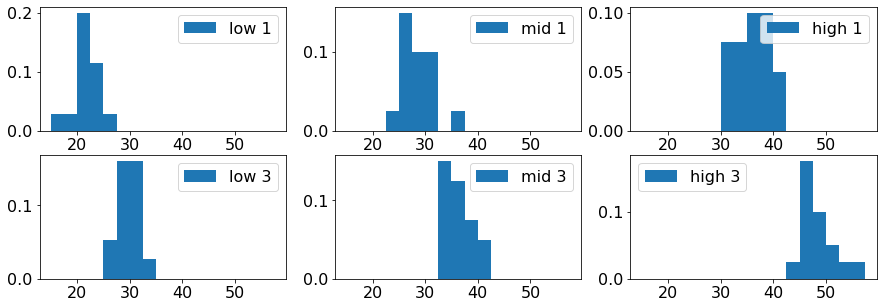

In [28]:
#initial spacing distribution
impact_factor_column = 3
impact_factor_group_label = ['low', 'mid', 'high']
impact_factor_column2 = 8
impact_factor_group_label2 = ['1', '3']
Deceleartion_start_categorized = {}
for l in impact_factor_group_label:
    Deceleartion_start_categorized[l] = {}
    for l2 in impact_factor_group_label2:
        Deceleartion_start_categorized[l][l2] = []
for d in comprehensive_oscillation_features_with_delay:
    Deceleartion_start_categorized[d[impact_factor_column]][d[impact_factor_column2]].append(d[15][-1])

print('low 1',round(np.mean(Deceleartion_start_categorized['low']['1']), 2),
      'std',round(np.std(Deceleartion_start_categorized['low']['1']), 2),
      'low 3', round(np.mean(Deceleartion_start_categorized['low']['3']), 2), 
      'std',round(np.std(Deceleartion_start_categorized['low']['3']), 2),
      'p-value', round(stats.ttest_ind(Deceleartion_start_categorized['low']['3'], 
                                       Deceleartion_start_categorized['low']['1'])[1],3))    
print('mid 1',round(np.mean(Deceleartion_start_categorized['mid']['1']), 2), 
      'std',round(np.std(Deceleartion_start_categorized['mid']['1']), 2),
      'mid 3', round(np.mean(Deceleartion_start_categorized['mid']['3']), 2), 
      'std',round(np.std(Deceleartion_start_categorized['mid']['3']), 2),
      'p-value', round(stats.ttest_ind(Deceleartion_start_categorized['mid']['3'], 
                                       Deceleartion_start_categorized['mid']['1'])[1],3))
print('high 1',round(np.mean(Deceleartion_start_categorized['high']['1']), 2), 
      'std',round(np.std(Deceleartion_start_categorized['high']['1']), 2),
      'high 3', round(np.mean(Deceleartion_start_categorized['high']['3']), 2), 
      'std',round(np.std(Deceleartion_start_categorized['high']['3']), 2),
      'p-value', round(stats.ttest_ind(Deceleartion_start_categorized['high']['3'], 
                                       Deceleartion_start_categorized['high']['1'])[1],3))

fig, axs = plt.subplots(2, 3, figsize=(15,5))
axs[0, 0].hist(Deceleartion_start_categorized['low']['1'],alpha=1,label='low 1',bins=np.arange(15,60,2.5),density=True)
axs[0, 0].legend()
axs[0, 1].hist(Deceleartion_start_categorized['mid']['1'],alpha=1,label='mid 1',bins=np.arange(15,60,2.5),density=True)
axs[0, 1].legend()
axs[0, 2].hist(Deceleartion_start_categorized['high']['1'],alpha=1,label='high 1',bins=np.arange(15,60,2.5),density=True)
axs[0, 2].legend()
axs[1, 0].hist(Deceleartion_start_categorized['low']['3'],alpha=1,label='low 3',bins=np.arange(15,60,2.5),density=True)
axs[1, 0].legend()
axs[1, 1].hist(Deceleartion_start_categorized['mid']['3'],alpha=1,label='mid 3',bins=np.arange(15,60,2.5),density=True)
axs[1, 1].legend()
axs[1, 2].hist(Deceleartion_start_categorized['high']['3'],alpha=1,label='high 3',bins=np.arange(15,60,2.5),density=True)
axs[1, 2].legend()


1 mid 28.55 low 21.61 p-value 3.866609634499715e-08


1 high 36.17 mid 28.55 p-value 1.5530799798636727e-07


3 mid 36.18 low 29.77 p-value 4.990186054578646e-09


3 high 48.5 mid 36.18 p-value 1.6246075151679577e-13


low 3 29.77 1 21.61 p-value 0.0


mid 3 36.18 1 28.55 p-value 0.0


high 3 48.5 1 36.17 p-value 0.0




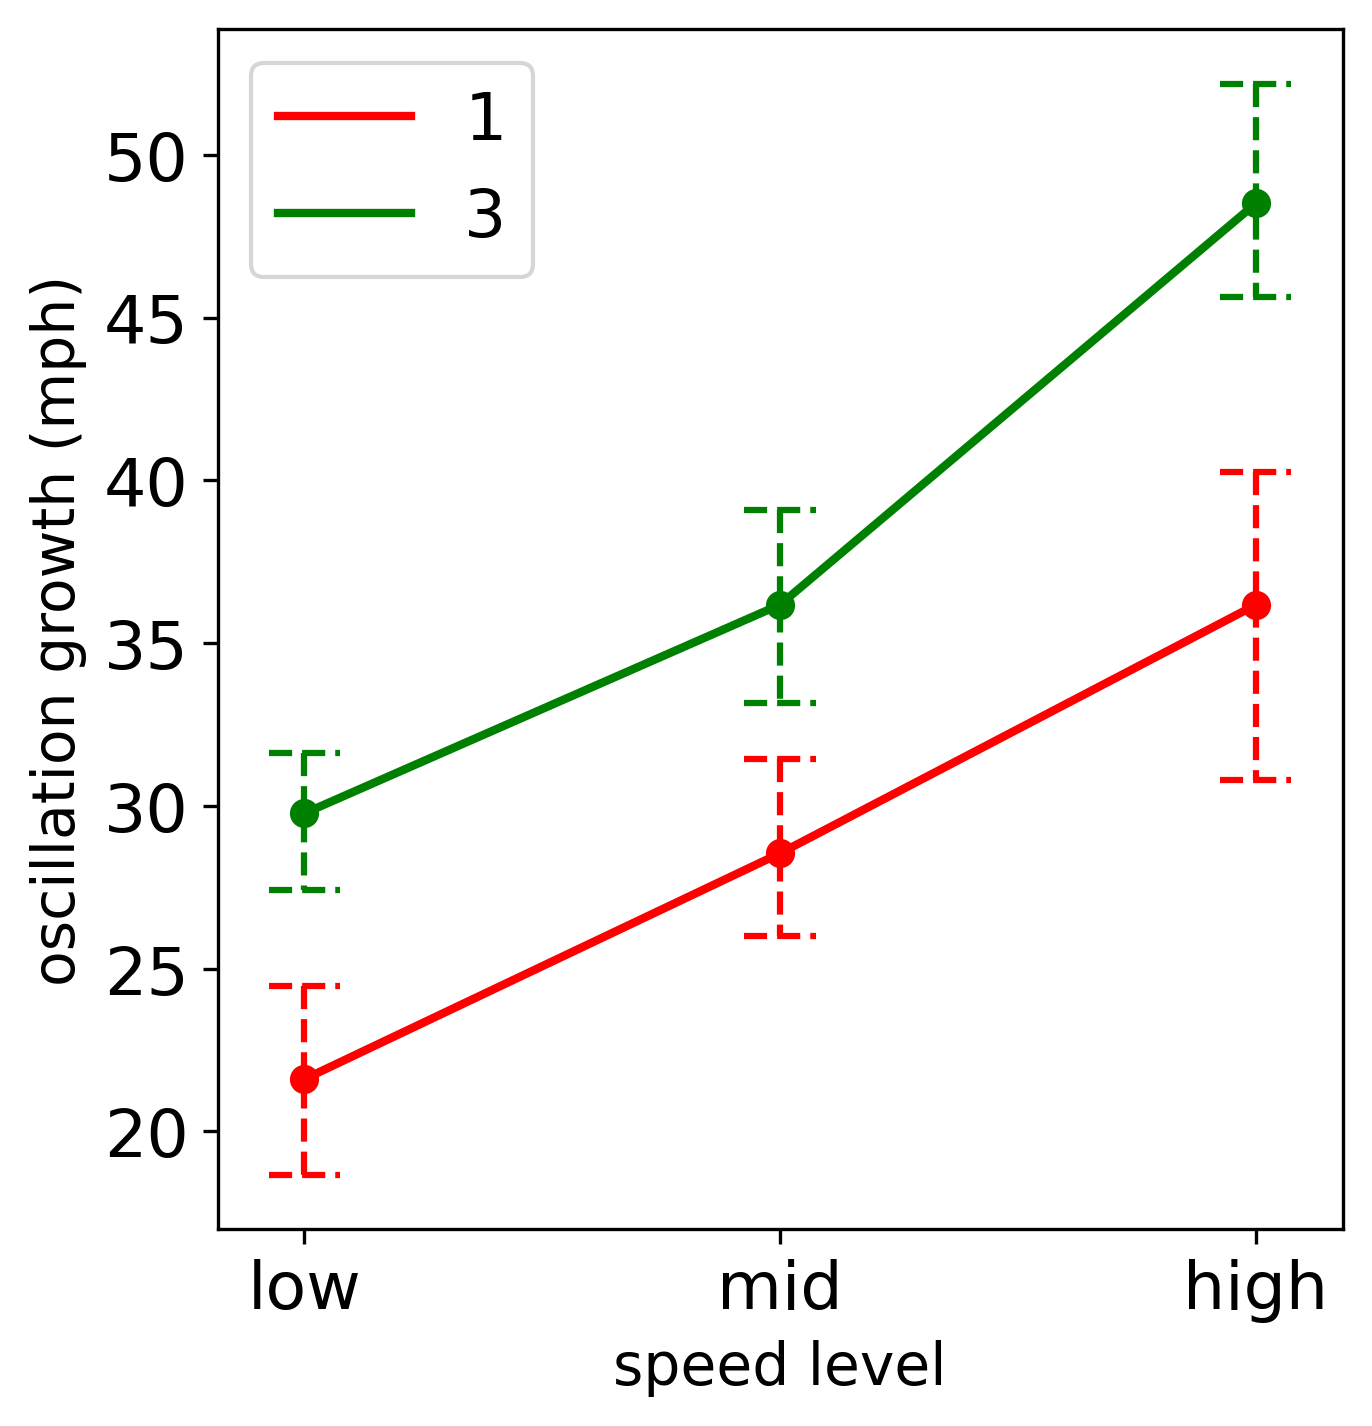

In [31]:
#initial spacing bar plot
impact_factor_column2 = 3
impact_factor_group_label2 = ['low', 'mid', 'high']
impact_factor_column = 8
impact_factor_group_label = ['1', '3']
data_group = {}
for l in impact_factor_group_label:
    data_group[l] = {}
    for l2 in impact_factor_group_label2:
        data_group[l][l2] = []
for d in comprehensive_oscillation_features_with_delay:
    data_group[d[impact_factor_column]][d[impact_factor_column2]].append(d[15][-1])

color_group = ['r', 'g', 'b']
fig = plt.figure(figsize=(5, 5), dpi=300)
ax = fig.add_subplot(111)
ax.set_position([0.2, 0.15, 0.75, 0.8])
label_num = 0
overall_mean_value = []
for label in data_group.keys():
    mean_value = []
    data_points_y_group = data_group[label]
    for fl in data_points_y_group.keys():
        data_points_y = data_points_y_group[fl]
        mean_value.append((np.mean(data_points_y),  # 0 y-mean location
                           np.percentile(data_points_y, 90),  # 1 y-90th location
                           np.percentile(data_points_y, 10),  # 2 y-10th location
                           np.std(data_points_y),  # 3 y std
                           label,  # 4 label
                           data_points_y,  # 5 y samples
                           fl))  # 6 feature label

    for i in range(len(mean_value)):
        if i >= 1:
            print(mean_value[i][4], mean_value[i][6], round(mean_value[i][0], 2), mean_value[i - 1][6],
                  round(mean_value[i - 1][0], 2), 'p-value',
                  stats.ttest_ind(mean_value[i][5], mean_value[i - 1][5])[1])
            print('\n')
    plt.plot(np.arange(1, len(mean_value) + 1), [np.mean(mv[5]) for mv in mean_value],
             linewidth=2, label=impact_factor_group_label[label_num], color=color_group[label_num], linestyle='-')
    plt.scatter(np.arange(1, len(mean_value) + 1), [np.mean(mv[5]) for mv in mean_value],
                color=color_group[label_num])
    stick_width = .075
    stick_line_style = '--'
    stick_line_width = 1.5
    for i in range(len(mean_value)):
        line2_1 = plt.plot([i + 1, i + 1], [mean_value[i][1], mean_value[i][2]], color=color_group[label_num],
                           linewidth=stick_line_width, alpha=1, linestyle=stick_line_style)
        plt.plot([i + 1 - stick_width, i + 1 + stick_width], [mean_value[i][1], mean_value[i][1]],
                 color=color_group[label_num],
                 linewidth=stick_line_width, alpha=1, linestyle=stick_line_style)
        plt.plot([i + 1 - stick_width, i + 1 + stick_width], [mean_value[i][2], mean_value[i][2]],
                 color=color_group[label_num],
                 linewidth=stick_line_width, alpha=1, linestyle=stick_line_style)
    label_num += 1
    overall_mean_value.append(mean_value)

for j in range(len(overall_mean_value)):
    if j >= 1:
        for i in range(len(mean_value)):
            print(overall_mean_value[j][i][6], overall_mean_value[j][i][4], round(overall_mean_value[j][i][0], 2),
                  overall_mean_value[j-1][i][4], round(overall_mean_value[j-1][i][0], 2), 'p-value',
                  round(stats.ttest_ind(overall_mean_value[j][i][5], overall_mean_value[j-1][i][5])[1],3))
            print('\n')

plt.legend()
plt.xticks(np.arange(1, len(mean_value) + 1), impact_factor_group_label2)
plt.xlabel('speed level',fontsize=14)
plt.ylabel('oscillation growth (mph)',fontsize=14)
plt.show()

low 1 -0.73 std 0.46 low 3 -0.26 std 0.5 p-value 0.017
mid 1 -0.82 std 0.6 mid 3 -0.28 std 0.35 p-value 0.005
high 1 -0.16 std 0.21 high 3 0.33 std 0.34 p-value 0.0


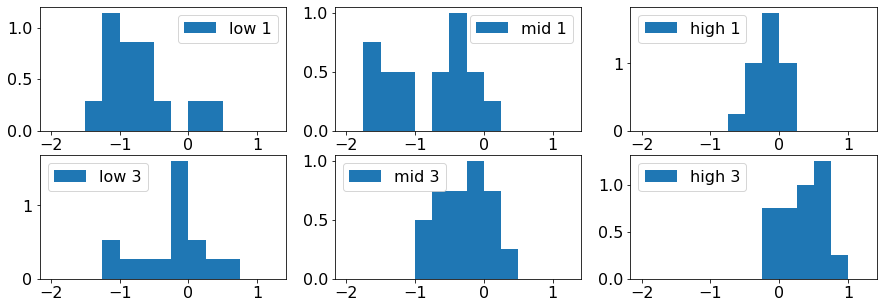

In [30]:
#oscillation growth distribution
impact_factor_column = 3
impact_factor_group_label = ['low', 'mid', 'high']
impact_factor_column2 = 8
impact_factor_group_label2 = ['1', '3']
Deceleartion_start_categorized = {}
for l in impact_factor_group_label:
    Deceleartion_start_categorized[l] = {}
    for l2 in impact_factor_group_label2:
        Deceleartion_start_categorized[l][l2] = []
for d in comprehensive_oscillation_features_with_delay:
    Deceleartion_start_categorized[d[impact_factor_column]][d[impact_factor_column2]].append(d[0])

print('low 1',round(np.mean(Deceleartion_start_categorized['low']['1']), 2),
      'std',round(np.std(Deceleartion_start_categorized['low']['1']), 2),
      'low 3', round(np.mean(Deceleartion_start_categorized['low']['3']), 2), 
      'std',round(np.std(Deceleartion_start_categorized['low']['3']), 2),
      'p-value', round(stats.ttest_ind(Deceleartion_start_categorized['low']['3'], 
                                       Deceleartion_start_categorized['low']['1'])[1],3))    
print('mid 1',round(np.mean(Deceleartion_start_categorized['mid']['1']), 2), 
      'std',round(np.std(Deceleartion_start_categorized['mid']['1']), 2),
      'mid 3', round(np.mean(Deceleartion_start_categorized['mid']['3']), 2), 
      'std',round(np.std(Deceleartion_start_categorized['mid']['3']), 2),
      'p-value', round(stats.ttest_ind(Deceleartion_start_categorized['mid']['3'], 
                                       Deceleartion_start_categorized['mid']['1'])[1],3))
print('high 1',round(np.mean(Deceleartion_start_categorized['high']['1']), 2), 
      'std',round(np.std(Deceleartion_start_categorized['high']['1']), 2),
      'high 3', round(np.mean(Deceleartion_start_categorized['high']['3']), 2), 
      'std',round(np.std(Deceleartion_start_categorized['high']['3']), 2),
      'p-value', round(stats.ttest_ind(Deceleartion_start_categorized['high']['3'], 
                                       Deceleartion_start_categorized['high']['1'])[1],3))

fig, axs = plt.subplots(2, 3, figsize=(15,5))
axs[0, 0].hist(Deceleartion_start_categorized['low']['1'],alpha=1,label='low 1',bins=np.arange(-2,1.5,.25),density=True)
axs[0, 0].legend()
axs[0, 1].hist(Deceleartion_start_categorized['mid']['1'],alpha=1,label='mid 1',bins=np.arange(-2,1.5,.25),density=True)
axs[0, 1].legend()
axs[0, 2].hist(Deceleartion_start_categorized['high']['1'],alpha=1,label='high 1',bins=np.arange(-2,1.5,.25),density=True)
axs[0, 2].legend()
axs[1, 0].hist(Deceleartion_start_categorized['low']['3'],alpha=1,label='low 3',bins=np.arange(-2,1.5,.25),density=True)
axs[1, 0].legend()
axs[1, 1].hist(Deceleartion_start_categorized['mid']['3'],alpha=1,label='mid 3',bins=np.arange(-2,1.5,.25),density=True)
axs[1, 1].legend()
axs[1, 2].hist(Deceleartion_start_categorized['high']['3'],alpha=1,label='high 3',bins=np.arange(-2,1.5,.25),density=True)
axs[1, 2].legend()

1 mid -0.82 low -0.73 p-value 0.6587570982101896


1 high -0.16 mid -0.82 p-value 0.0004227852660237437


3 mid -0.28 low -0.26 p-value 0.9189420741651817


3 high 0.33 mid -0.28 p-value 3.5611914917792855e-05


low 3 -0.26 1 -0.73 p-value 0.017


mid 3 -0.28 1 -0.82 p-value 0.005


high 3 0.33 1 -0.16 p-value 0.0




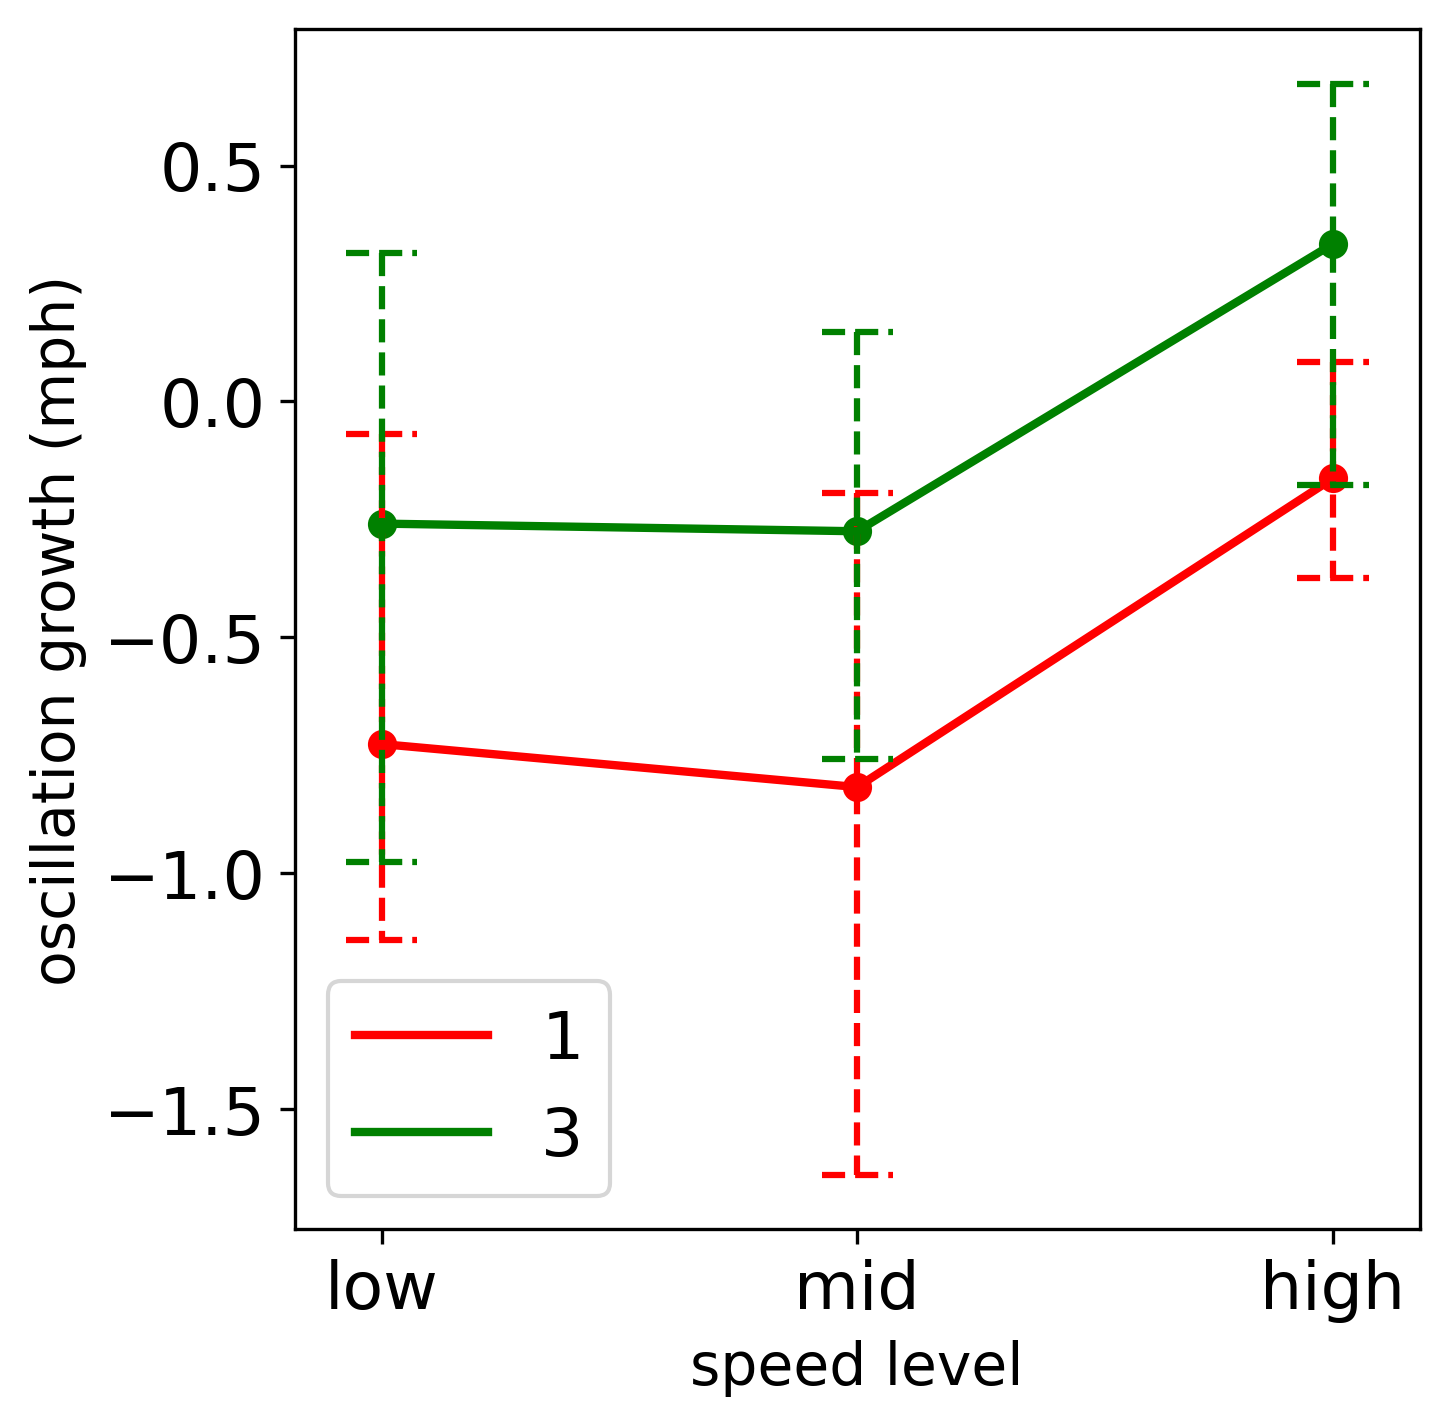

In [22]:
#oscillation growth bar plot
impact_factor_column2 = 3
impact_factor_group_label2 = ['low', 'mid', 'high']
impact_factor_column = 8
impact_factor_group_label = ['1', '3']
data_group = {}
for l in impact_factor_group_label:
    data_group[l] = {}
    for l2 in impact_factor_group_label2:
        data_group[l][l2] = []
for d in comprehensive_oscillation_features_with_delay:
    data_group[d[impact_factor_column]][d[impact_factor_column2]].append(d[0])

color_group = ['r', 'g', 'b']
fig = plt.figure(figsize=(5, 5), dpi=300)
ax = fig.add_subplot(111)
ax.set_position([0.2, 0.15, 0.75, 0.8])
label_num = 0
overall_mean_value = []
for label in data_group.keys():
    mean_value = []
    data_points_y_group = data_group[label]
    for fl in data_points_y_group.keys():
        data_points_y = data_points_y_group[fl]
        mean_value.append((np.mean(data_points_y),  # 0 y-mean location
                           np.percentile(data_points_y, 90),  # 1 y-90th location
                           np.percentile(data_points_y, 10),  # 2 y-10th location
                           np.std(data_points_y),  # 3 y std
                           label,  # 4 label
                           data_points_y,  # 5 y samples
                           fl))  # 6 feature label

    for i in range(len(mean_value)):
        if i >= 1:
            print(mean_value[i][4], mean_value[i][6], round(mean_value[i][0], 2), mean_value[i - 1][6],
                  round(mean_value[i - 1][0], 2), 'p-value',
                  stats.ttest_ind(mean_value[i][5], mean_value[i - 1][5])[1])
            print('\n')
    plt.plot(np.arange(1, len(mean_value) + 1), [np.mean(mv[5]) for mv in mean_value],
             linewidth=2, label=impact_factor_group_label[label_num], color=color_group[label_num], linestyle='-')
    plt.scatter(np.arange(1, len(mean_value) + 1), [np.mean(mv[5]) for mv in mean_value],
                color=color_group[label_num])
    stick_width = .075
    stick_line_style = '--'
    stick_line_width = 1.5
    for i in range(len(mean_value)):
        line2_1 = plt.plot([i + 1, i + 1], [mean_value[i][1], mean_value[i][2]], color=color_group[label_num],
                           linewidth=stick_line_width, alpha=1, linestyle=stick_line_style)
        plt.plot([i + 1 - stick_width, i + 1 + stick_width], [mean_value[i][1], mean_value[i][1]],
                 color=color_group[label_num],
                 linewidth=stick_line_width, alpha=1, linestyle=stick_line_style)
        plt.plot([i + 1 - stick_width, i + 1 + stick_width], [mean_value[i][2], mean_value[i][2]],
                 color=color_group[label_num],
                 linewidth=stick_line_width, alpha=1, linestyle=stick_line_style)
    label_num += 1
    overall_mean_value.append(mean_value)

for j in range(len(overall_mean_value)):
    if j >= 1:
        for i in range(len(mean_value)):
            print(overall_mean_value[j][i][6], overall_mean_value[j][i][4], round(overall_mean_value[j][i][0], 2),
                  overall_mean_value[j-1][i][4], round(overall_mean_value[j-1][i][0], 2), 'p-value',
                  round(stats.ttest_ind(overall_mean_value[j][i][5], overall_mean_value[j-1][i][5])[1],3))
            print('\n')

plt.legend()
plt.xticks(np.arange(1, len(mean_value) + 1), impact_factor_group_label2)
plt.xlabel('speed level',fontsize=14)
plt.ylabel('oscillation growth (mph)',fontsize=14)
plt.show()
    


coef: 0.35 intercept: -0.85 p-value: 0.02
coef: 1.12 intercept: -1.97 p-value: 0.003
coef: 0.15 intercept: -0.56 p-value: 0.294


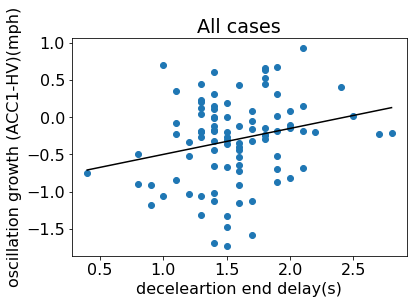

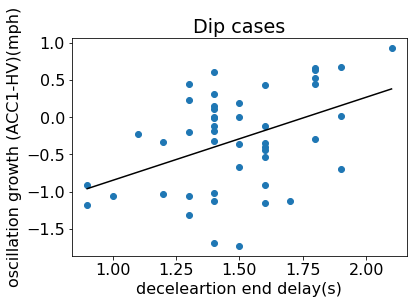

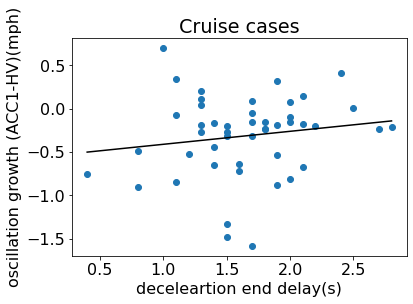

In [4]:
#oscillation growth extra analysis - deceleration end delay

x_column = 12
y_column = 0
x_label = 'deceleartion end delay(s)'
y_label = 'oscillation growth (ACC1-HV)(mph)'
title = 'All cases'
scatter_plot(comprehensive_oscillation_features_with_delay, x_column, y_column, x_label, y_label, title)

title = 'Dip cases'
filter_column = 7
filter_label = 'no'
scatter_plot(comprehensive_oscillation_features_with_delay, x_column, y_column, x_label, y_label, 
             title, filter_column, filter_label)

title = 'Cruise cases'
filter_column = 7
filter_label = 'long'
scatter_plot(comprehensive_oscillation_features_with_delay, x_column, y_column, x_label, y_label, 
             title, filter_column, filter_label)


coef: 0.43 intercept: -0.94 p-value: 0.017
coef: 0.17 intercept: 1.23 p-value: 0.013


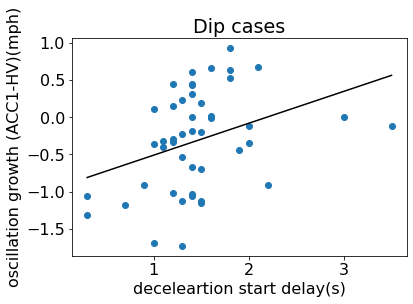

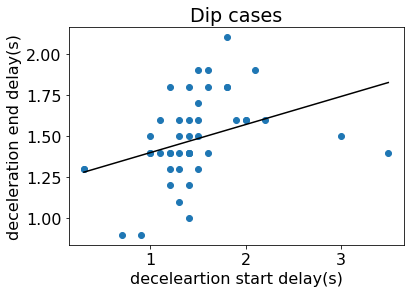

In [6]:
#oscillation growth extra analysis - deceleration start delay

x_column = 11
y_column = 0
x_label = 'deceleartion start delay(s)'
y_label = 'oscillation growth (ACC1-HV)(mph)'
title = 'Dip cases'
filter_column = 7
filter_label = 'no'
scatter_plot(comprehensive_oscillation_features_with_delay, x_column, y_column, x_label, y_label, 
             title, filter_column, filter_label)

x_column = 11
y_column = 12
x_label = 'deceleartion start delay(s)'
y_label = 'deceleration end delay(s)'
title = 'Dip cases'
filter_column = 7
filter_label = 'no'
scatter_plot(comprehensive_oscillation_features_with_delay, x_column, y_column, x_label, y_label, 
             title, filter_column, filter_label)

ALL - coef: 8.04 intercept: 21.93 p-value: 0.0
HIGH - coef: 0.31 intercept: 41.79 p-value: 0.912
MID - coef: 6.48 intercept: 23.24 p-value: 0.018
LOW - coef: 2.83 intercept: 22.47 p-value: 0.048


Text(0.5, 1.0, 'All cases')

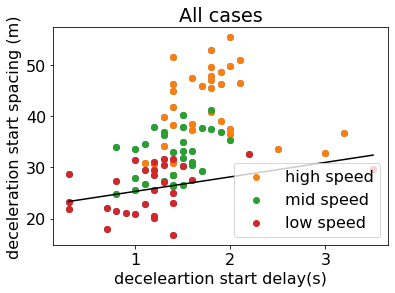

In [36]:
#oscillation growth extra analysis - deceleration start delay with spacing

x_column = 11
x_label = 'deceleartion start delay(s)'
y_label = 'deceleration start spacing (m)'
title = 'All cases'

filter_column = None
X = []
Y = []
for d in comprehensive_oscillation_features_with_delay:
    if filter_column is not None:
        if d[filter_column] != filter_label:
            continue
    X.append(d[x_column])
    Y.append(d[15][-1])
coef, intercept, p_value = linear_regression(X,Y)
print('ALL - coef:',coef,'intercept:',intercept,'p-value:',round(p_value,3))


X_high = []
Y_high = []
filter_column = 3
filter_label = 'high'
for d in comprehensive_oscillation_features_with_delay:
    if filter_column is not None:
        if d[filter_column] != filter_label:
            continue
    X_high.append(d[x_column])
    Y_high.append(d[15][-1])
coef, intercept, p_value = linear_regression(X_high,Y_high)
print('HIGH - coef:',coef,'intercept:',intercept,'p-value:',round(p_value,3))
X_mid = []
Y_mid = []
filter_column = 3
filter_label = 'mid'
for d in comprehensive_oscillation_features_with_delay:
    if filter_column is not None:
        if d[filter_column] != filter_label:
            continue
    X_mid.append(d[x_column])
    Y_mid.append(d[15][-1])
coef, intercept, p_value = linear_regression(X_mid,Y_mid)
print('MID - coef:',coef,'intercept:',intercept,'p-value:',round(p_value,3))
X_low = []
Y_low = []
filter_column = 3
filter_label = 'low'
for d in comprehensive_oscillation_features_with_delay:
    if filter_column is not None:
        if d[filter_column] != filter_label:
            continue
    X_low.append(d[x_column])
    Y_low.append(d[15][-1])
coef, intercept, p_value = linear_regression(X_low,Y_low)
print('LOW - coef:',coef,'intercept:',intercept,'p-value:',round(p_value,3))    
plt.figure()
plt.scatter(X, Y)
plt.scatter(X_high, Y_high, label = 'high speed')
plt.scatter(X_mid, Y_mid, label = 'mid speed')
plt.scatter(X_low, Y_low, label = 'low speed')
plt.legend()
plt.plot([min(X), max(X)], 
         [min(X) * coef + intercept, max(X) * coef + intercept], c='k')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)

# plt.figure()
# plt.hist(Y_low,alpha=1,label='low',density=True)
# plt.legend()
# plt.xlabel('spacing (m)')
# print('average:',round(np.mean(Y_low),2),'STD:',round(np.std(Y_low),2))

# plt.figure()
# plt.hist(Y_mid,alpha=1,label='mid',density=True)
# plt.legend()
# plt.xlabel('spacing (m)')
# print('average:',round(np.mean(Y_mid),2),'STD:',round(np.std(Y_mid),2))

# plt.figure()
# plt.hist(Y_high,alpha=1,label='high',density=True)
# plt.legend()
# plt.xlabel('spacing (m)')
# print('average:',round(np.mean(Y_high),2),'STD:',round(np.std(Y_high),2))


coef: 8.04 intercept: 21.93 p-value: 0.0
coef: 1.23 intercept: 39.01 p-value: 0.789
coef: 6.66 intercept: 22.53 p-value: 0.146
coef: 3.26 intercept: 21.45 p-value: 0.093


Text(0.5, 1.0, 'Dip cases')

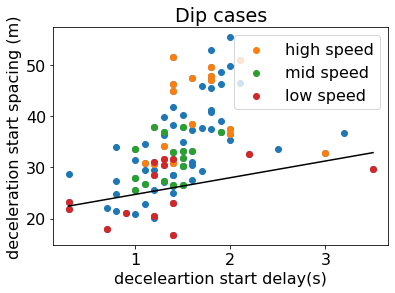

In [34]:
#oscillation growth extra analysis - deceleration start delay with spacing

x_column = 11
x_label = 'deceleartion start delay(s)'
y_label = 'deceleration start spacing (m)'
title = 'Dip cases'

filter_column = None
X = []
Y = []
for d in comprehensive_oscillation_features_with_delay:
    if filter_column is not None:
        if d[filter_column] != filter_label:
            continue
    if d[7] != 'no':
        continue
    X.append(d[x_column])
    Y.append(d[15][-1])
coef, intercept, p_value = linear_regression(X,Y)
print('coef:',coef,'intercept:',intercept,'p-value:',round(p_value,3))


X_high = []
Y_high = []
filter_column = 3
filter_label = 'high'
for d in comprehensive_oscillation_features_with_delay:
    if filter_column is not None:
        if d[filter_column] != filter_label:
            continue
    if d[7] != 'no':
        continue
    X_high.append(d[x_column])
    Y_high.append(d[15][-1])


    
X_mid = []
Y_mid = []
filter_column = 3
filter_label = 'mid'
for d in comprehensive_oscillation_features_with_delay:
    if filter_column is not None:
        if d[filter_column] != filter_label:
            continue
    if d[7] != 'no':
        continue
    X_mid.append(d[x_column])
    Y_mid.append(d[15][-1])


    
X_low = []
Y_low = []
filter_column = 3
filter_label = 'low'
for d in comprehensive_oscillation_features_with_delay:
    if filter_column is not None:
        if d[filter_column] != filter_label:
            continue
    if d[7] != 'no':
        continue
    X_low.append(d[x_column])
    Y_low.append(d[15][-1])


    
plt.figure()
plt.scatter(X, Y)
plt.scatter(X_high, Y_high, label = 'high speed')
plt.scatter(X_mid, Y_mid, label = 'mid speed')
plt.scatter(X_low, Y_low, label = 'low speed')
plt.legend()
plt.plot([min(X), max(X)], 
         [min(X) * coef + intercept, max(X) * coef + intercept], c='k')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)


coef: 0.06 intercept: -2.18 p-value: 0.0


Text(0.5, 1.0, 'Dip cases')

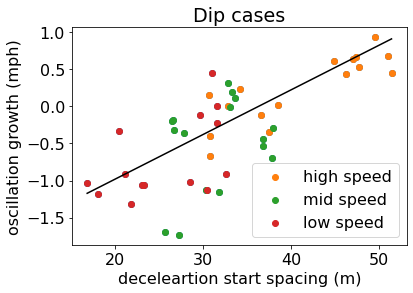

In [43]:
#oscillation growth extra analysis - deceleration start spacing
x_column = 0
x_label = 'deceleartion start spacing (m)'
y_label = 'oscillation growth (mph)'
title = 'Dip cases'

filter_column = None
X = []
Y = []
for d in comprehensive_oscillation_features_with_delay:
    if filter_column is not None:
        if d[filter_column] != filter_label:
            continue
    if d[7] != 'no':
        continue
    Y.append(d[x_column])
    X.append(d[15][-1])
coef, intercept, p_value = linear_regression(X,Y)
print('coef:',coef,'intercept:',intercept,'p-value:',round(p_value,3))


X_high = []
Y_high = []
filter_column = 3
filter_label = 'high'
for d in comprehensive_oscillation_features_with_delay:
    if filter_column is not None:
        if d[filter_column] != filter_label:
            continue
    if d[7] != 'no':
        continue
    Y_high.append(d[x_column])
    X_high.append(d[15][-1])

X_mid = []
Y_mid = []
filter_column = 3
filter_label = 'mid'
for d in comprehensive_oscillation_features_with_delay:
    if filter_column is not None:
        if d[filter_column] != filter_label:
            continue
    if d[7] != 'no':
        continue
    Y_mid.append(d[x_column])
    X_mid.append(d[15][-1])

X_low = []
Y_low = []
filter_column = 3
filter_label = 'low'
for d in comprehensive_oscillation_features_with_delay:
    if filter_column is not None:
        if d[filter_column] != filter_label:
            continue
    if d[7] != 'no':
        continue
    Y_low.append(d[x_column])
    X_low.append(d[15][-1])
    
plt.figure()
plt.scatter(X, Y)
plt.scatter(X_high, Y_high, label = 'high speed')
plt.scatter(X_mid, Y_mid, label = 'mid speed')
plt.scatter(X_low, Y_low, label = 'low speed')
plt.legend()
plt.plot([min(X), max(X)], 
         [min(X) * coef + intercept, max(X) * coef + intercept], c='k')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)

coef: 0.06 intercept: -2.19 p-value: 0.0


Text(0.5, 1.0, 'Dip cases')

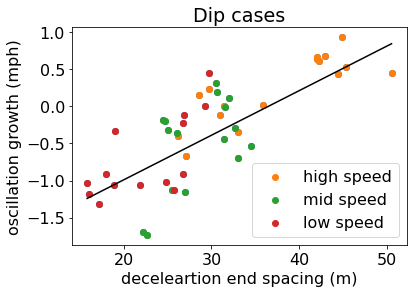

In [44]:
#oscillation growth extra analysis - deceleration end spacing
x_column = 0
x_label = 'deceleartion end spacing (m)'
y_label = 'oscillation growth (mph)'
title = 'Dip cases'

filter_column = None
X = []
Y = []
for d in comprehensive_oscillation_features_with_delay:
    if filter_column is not None:
        if d[filter_column] != filter_label:
            continue
    if d[7] != 'no':
        continue
    Y.append(d[x_column])
    X.append(d[16][600 + int(d[17] * 10)])
coef, intercept, p_value = linear_regression(X,Y)
print('coef:',coef,'intercept:',intercept,'p-value:',round(p_value,3))

X_high = []
Y_high = []
filter_column = 3
filter_label = 'high'
for d in comprehensive_oscillation_features_with_delay:
    if filter_column is not None:
        if d[filter_column] != filter_label:
            continue
    if d[7] != 'no':
        continue
    Y_high.append(d[x_column])
    X_high.append(d[16][600 + int(d[17] * 10)])

X_mid = []
Y_mid = []
filter_column = 3
filter_label = 'mid'
for d in comprehensive_oscillation_features_with_delay:
    if filter_column is not None:
        if d[filter_column] != filter_label:
            continue
    if d[7] != 'no':
        continue
    Y_mid.append(d[x_column])
    X_mid.append(d[16][600 + int(d[17] * 10)])

X_low = []
Y_low = []
filter_column = 3
filter_label = 'low'
for d in comprehensive_oscillation_features_with_delay:
    if filter_column is not None:
        if d[filter_column] != filter_label:
            continue
    if d[7] != 'no':
        continue
    Y_low.append(d[x_column])
    X_low.append(d[16][600 + int(d[17] * 10)])
    
plt.figure()
plt.scatter(X, Y)
plt.scatter(X_high, Y_high, label = 'high speed')
plt.scatter(X_mid, Y_mid, label = 'mid speed')
plt.scatter(X_low, Y_low, label = 'low speed')
plt.legend()
plt.plot([min(X), max(X)], 
         [min(X) * coef + intercept, max(X) * coef + intercept], c='k')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)

coef: 0.94 intercept: -1.4 p-value: 0.0


Text(0.5, 1.0, 'Dip cases')

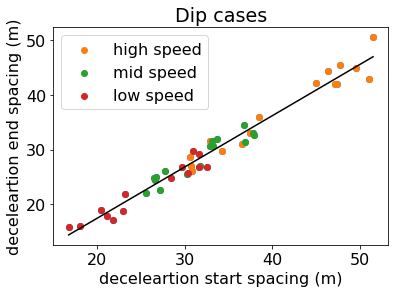

In [57]:
#oscillation growth extra analysis - deceleration start and end spacing
x_label = 'deceleartion start spacing (m)'
y_label = 'deceleartion end spacing (m)'
title = 'Dip cases'

filter_column = None
X = []
Y = []
for d in comprehensive_oscillation_features_with_delay:
    if filter_column is not None:
        if d[filter_column] != filter_label:
            continue
    if d[7] != 'no':
        continue
    Y.append(d[16][600 + int(d[17] * 10)])
    X.append(d[15][-1])
coef, intercept, p_value = linear_regression(X,Y)
print('coef:',coef,'intercept:',intercept,'p-value:',round(p_value,3))


X_high = []
Y_high = []
filter_column = 3
filter_label = 'high'
for d in comprehensive_oscillation_features_with_delay:
    if filter_column is not None:
        if d[filter_column] != filter_label:
            continue
    if d[7] != 'no':
        continue
    Y_high.append(d[16][600 + int(d[17] * 10)])
    X_high.append(d[15][-1])

X_mid = []
Y_mid = []
filter_column = 3
filter_label = 'mid'
for d in comprehensive_oscillation_features_with_delay:
    if filter_column is not None:
        if d[filter_column] != filter_label:
            continue
    if d[7] != 'no':
        continue
    Y_mid.append(d[16][600 + int(d[17] * 10)])
    X_mid.append(d[15][-1])

X_low = []
Y_low = []
filter_column = 3
filter_label = 'low'
for d in comprehensive_oscillation_features_with_delay:
    if filter_column is not None:
        if d[filter_column] != filter_label:
            continue
    if d[7] != 'no':
        continue
    Y_low.append(d[16][600 + int(d[17] * 10)])
    X_low.append(d[15][-1])
    
plt.figure()
plt.scatter(X, Y)
plt.scatter(X_high, Y_high, label = 'high speed')
plt.scatter(X_mid, Y_mid, label = 'mid speed')
plt.scatter(X_low, Y_low, label = 'low speed')
plt.legend()
plt.plot([min(X), max(X)], 
         [min(X) * coef + intercept, max(X) * coef + intercept], c='k')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)

In [17]:
a[600-11]

-1.099999999999163